# NCoR Motif Analysis

In [236]:
### header ###
__author__ = "Jenhan Tao"
__license__ = "BSD"
__email__ = "jenhantao@gmail.com"
%load_ext autoreload
%autoreload 2
### imports ###
import sys
%matplotlib inline
sys.path.append("/home/jenhan/code/seq_merge_pipe/")
import os
import pandas as pd
import numpy as np
import argparse
import matplotlib
import itertools
import scipy
import matplotlib.pyplot as plt 
import seaborn as sns
from IPython.display import Image, display
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram
import scipy
matplotlib.pylab.rcParams['savefig.dpi'] = 200
sys.setrecursionlimit(3000)
os.chdir('/home/jenhan/analysis/ncor_analysis/')
import pickle
sns.set_context('talk')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Generate Score Files

### Convert motif files

### Create group summary file

In [237]:
# create group summary file
!bash /home/jenhan/code/seq_merge_pipe/makeSummaryFile.sh /home/jenhan/analysis/ncor_analysis/peak_files/* > /home/jenhan/analysis/ncor_analysis/output/group_summary.tsv
! cp merged.tsv /home/jenhan/analysis/ncor_analysis/group/merged_peaks.tsv

	Max distance to merge: direct overlap required (-d given)
	Merging peaks... 
	Comparing /home/jenhan/analysis/ncor_analysis/peak_files/gps2_kla_peaks.tsv (5907 total) and /home/jenhan/analysis/ncor_analysis/peak_files/gps2_kla_peaks.tsv (5907 total)
	Comparing /home/jenhan/analysis/ncor_analysis/peak_files/gps2_kla_peaks.tsv (5907 total) and /home/jenhan/analysis/ncor_analysis/peak_files/gps2_notx_peaks.tsv (1700 total)
	Comparing /home/jenhan/analysis/ncor_analysis/peak_files/gps2_kla_peaks.tsv (5907 total) and /home/jenhan/analysis/ncor_analysis/peak_files/lxr_notx_peaks.tsv (23392 total)
	Comparing /home/jenhan/analysis/ncor_analysis/peak_files/gps2_kla_peaks.tsv (5907 total) and /home/jenhan/analysis/ncor_analysis/peak_files/ncor-ko_kla_peaks.tsv (1162 total)
	Comparing /home/jenhan/analysis/ncor_analysis/peak_files/gps2_kla_peaks.tsv (5907 total) and /home/jenhan/analysis/ncor_analysis/peak_files/ncor-ko_notx_peaks.tsv (172 total)
	Comparing /home/jenhan/analysis/ncor_analysis/pe

### Retrieve sequences under peaks for finding motifs

In [238]:
%%capture
# get sequences to scan for motifsx`
!/home/jenhan/code/motif_tools/getTargetSequencesWrapper.sh /home/jenhan/analysis/ncor_analysis/group/ /home/jenhan/analysis/ncor_analysis/group 100


## Annotate with GRO-seq, H3K27Ac, H3K4me3, and PolII

In [239]:
%%capture
!annotatePeaks.pl /home/jenhan/analysis/ncor_analysis/group/merged_peaks.tsv mm10 -size 1000 -d ./tag_directories_enhancerMarks/* > merged_annotated_peaks.tsv

### Scan for motifs using FIMO

In [240]:
# create a script to scan for motifs using FIMO
! if [ ! -d /home/jenhan/analysis/cobinding_motif_analysis/fimo_out/ ]; then mkdir /home/jenhan/analysis/cobinding_motif_analysis/fimo_out/; fi
pthresh = 0.01
motif_dir = '/home/jenhan/analysis/ncor_analysis/fimo_motifs/'

fimo_results_dir = '/home/jenhan/analysis/ncor_analysis/fimo_results'
p='/home/jenhan/analysis/ncor_analysis/group/merged.fa'
count = 0
scriptFile = open('scanMotifs.sh','w')
for m in os.listdir(motif_dir):
    if 'fimo' in m:
        fimo_out_dir = '/home/jenhan/analysis/ncor_analysis/fimo_out/' + m.replace('.fimo','')
        outPath = fimo_results_dir + '/merged_'+ m.replace('.fimo','') +'.txt'
        scriptFile.write(
            '(sleep ' + str(30 * 0) + 
            's; fimo --max-stored-scores 2000000 --output-pthresh ' + 
            str(pthresh) +' --oc ' + fimo_out_dir + ' ' +
            motif_dir + '/' + m + ' /home/jenhan/analysis/ncor_analysis/group/merged.fa; '+
            'mv ' + fimo_out_dir + '/fimo.txt ' + 
            outPath + ' ) & \n')
        count+=1
scriptFile.close()

!bash scanMotifs.sh

Reading txt file vmajor: 4, vminor: 4, vbug: 0
Reading txt file vmajor: 4, vminor: 4, vbug: 0
Using nucleotide alphabet (ACGTURYKMSWBDHVN).
Using nucleotide alphabet (ACGTURYKMSWBDHVN).
Using background frequencies from NR sequence database.
Using background frequencies from NR sequence database.
Reading txt file vmajor: 4, vminor: 4, vbug: 0
Read 1 motifs.
Read 1 motifs.
Reading txt file vmajor: 4, vminor: 4, vbug: 0
Reading txt file vmajor: 4, vminor: 4, vbug: 0
Reading txt file vmajor: 4, vminor: 4, vbug: 0
Using nucleotide alphabet (ACGTURYKMSWBDHVN).
Using background frequencies from NR sequence database.
Using nucleotide alphabet (ACGTURYKMSWBDHVN).
Reading txt file vmajor: 4, vminor: 4, vbug: 0
Reading txt file vmajor: 4, vminor: 4, vbug: 0
Reading txt file vmajor: 4, vminor: 4, vbug: 0
Using nucleotide alphabet (ACGTURYKMSWBDHVN).
Using nucleotide alphabet (ACGTURYKMSWBDHVN).
Using background frequencies from NR sequence database.
Using nucleotide alphabet (ACGTURYKMSWBDHVN).
U

In [222]:
%%bash
./scanMotifs.sh

bash: line 1: ./scanMotifsh.sh: No such file or directory


## Read in Score Files

### Read in Peak scores as floating point and boolean values

In [241]:
# read in peak data data
summary_frame = pd.read_csv('/home/jenhan/analysis/ncor_analysis/output/group_summary.tsv' , sep='\t')
summary_frame = summary_frame.fillna('0')
for col in summary_frame.columns[4:]:
    floatValues = []
    for val in summary_frame[col].values.astype(str):
        if ',' in val:
            maxVal = np.max([float(x) for x in val.split(',')])
            floatValues.append(maxVal)
        else:
            floatValues.append(float(val))
    summary_frame[col] = floatValues
    
summary_frame['chr'] = [x.split(':')[0] for x in summary_frame['Position'].values]
summary_frame['numFactors'] = [len(x.split(',')) for x in summary_frame['Factors'].values]

# drop every peak that appears in the NCoR knockout
summary_frame = summary_frame[~summary_frame['Factors'].str.contains('ncor-ko')]

summary_frame.index = summary_frame['ID'].values
newCols = list(summary_frame.columns.values)[:4] + ['chr', 'numFactors'] + list(summary_frame.columns.values)[4:-2]
newCols = [x for x in newCols if not 'ncor-ko' in x]
summary_frame = summary_frame[newCols]



del summary_frame['Group Number']
del summary_frame['numFactors']

bool_frame = summary_frame.copy()
bool_frame.index = summary_frame.index
del bool_frame['Position']
del bool_frame['chr']
del bool_frame['Factors']
del bool_frame['ID']



bool_frame['chr'] =summary_frame['chr']
bool_frame = bool_frame[['chr'] + list(bool_frame.columns.values[:-1])]


kla_cols= ['chr']
notx_cols = ['chr']
for col in bool_frame.columns:
    if 'kla' in col:
        kla_cols.append(col)
    elif 'notx' in col:
        notx_cols.append(col)
        
bool_frame_kla = bool_frame[kla_cols]
bool_frame_kla = bool_frame_kla[bool_frame_kla.sum(axis=1)>0]

bool_frame_notx = bool_frame[notx_cols]
bool_frame_notx = bool_frame_notx[bool_frame_notx.sum(axis=1)>0]

bool_frame.to_pickle('bool_frame.pickle')


factors = sorted(list(set([x.split('_')[0] for x in bool_frame.columns if '_' in x])))

### Read in GRO, PolII, and H3K27Ac scores

In [242]:
# read in GRO, PolII, and H3K27Ac scores
data_frame = pd.read_csv('merged_annotated_peaks.tsv', sep='\t')
data_frame.index=data_frame.ix[:,0].values
columns = data_frame.columns.values
columns[0] = 'ID'
columns = [x.split('/')[-1].split()[0] if '/' in x else x for x in columns]
data_frame.columns = columns
data_frame['PolII-KLA'] = np.mean(data_frame[['BMDM_NCoR-WT_ChIP_PolII_KLA-1h_Josh_14-03-19']], axis=1)
data_frame['PolII-notx'] = np.mean(data_frame[['BMDM_NCoR-WT_ChIP_PolII_Veh_Josh_14-03-19']], axis=1)
data_frame['H3K27Ac-KLA'] = np.mean(data_frame[['BMDM_NCoR-WT_ChIP_H3K27Ac_KLA-1h_JSS_14-11-04',
                                               'BMDM_NCoR-WT_ChIP_H3K27Ac_KLA-1h_JSS_15-07-14']], axis=1)
data_frame['H3K27Ac-notx'] = np.mean(data_frame[['BMDM_NCoR-WT_ChIP_H3K27Ac_Veh_JSS_14-11-04', 
                                               'BMDM_NCoR-WT_ChIP_H3K27Ac_Veh_JSS_15-07-14']], axis=1)
data_frame['Gro-KLA'] = np.mean(data_frame[['ThioMac_NCoR-WT_Gro_KLA-1h_NJS_10-08-13', 
                                               'ThioMac_NCoR-WT_Gro_KLA-1h_NJS_10-09-01']], axis=1)
data_frame['Gro-notx'] = np.mean(data_frame[['ThioMac_NCoR-WT_Gro_notx-1h_NJS_10-08-13', 
                                               'ThioMac_NCoR-WT_Gro_notx-1h_NJS_10-09-01']], axis=1)
data_frame['H3K4me3-KLA'] = np.mean(data_frame[['BMDM_NCoR-WT_ChIP_H3K4me3_KLA-1h_Josh_14-07-07']], axis=1)
data_frame['H3K4me3-notx'] = np.mean(data_frame[['BMDM_NCoR-WT_ChIP_H3K4me3_Veh-1h_Josh_14-07-07']], axis=1)

data_frame = data_frame[['ID'] + list(data_frame.columns.values[-8:])]
summary_frame = summary_frame.merge(data_frame, on='ID')
summary_frame.index = summary_frame['ID'].values

# remove outlier GRO-seq values
summary_frame.loc[summary_frame['Gro-notx'] > 10000, 'Gro-notx' ] = 0
summary_frame.loc[summary_frame['Gro-KLA'] > 10000, 'Gro-KLA' ] = 0
summary_frame.to_pickle('summary_frame.pickle')

### Read in Peak Genomic Annotations as Dictionary

In [243]:
data = pd.read_csv('merged_annotated_peaks.tsv', sep='\t')
data['Annotation'] = [str(x).split()[0] for x in data['Annotation'].values]
annotationTypes = set(data['Annotation'].values)
id_annotation_dict = dict(zip(data.ix[:,0].values, data['Annotation']))
id_tssDistance_dict = dict(zip(data.ix[:,0].values, data['Distance to TSS']))

### Read in motif scores

In [244]:
motif_dir = '/home/jenhan/analysis/ncor_analysis/fimo_motifs/'
merged_motif_frame = summary_frame[['ID', 'Factors', 'chr']]
merged_motif_frame.index=merged_motif_frame['ID'].values
for m in os.listdir(motif_dir):
    if '.fimo' in m:
        motif_results = './fimo_results/merged_' + m.replace('.fimo','') +'.txt'
        fimo_result_frame=pd.read_csv(motif_results, sep='\t')
        motif_name = m.replace('.fimo','')
        id_score_dict = {}
        ids = fimo_result_frame['sequence name'].values
        scores = fimo_result_frame['score'].values
        for i in range(len(ids)):
            if ids[i] in id_score_dict:
                if scores[i] > id_score_dict[ids[i]]:
                    id_score_dict[ids[i]] = scores[i]
            else:
                id_score_dict[ids[i]] = scores[i]
        merged_motif_frame[motif_name] = [id_score_dict[x] if x in id_score_dict else -10 for x in merged_motif_frame['ID'].values]

# only keep rows where the ID appears in summary_frame
merged_motif_frame = merged_motif_frame[merged_motif_frame['ID'].isin(summary_frame['ID'])]

# save merged_motif_frame to a pickle
merged_motif_frame.to_pickle('motif_frame.pickle')



## Analysis of motif scores peak scores

### Plot Distributions of peak and motif scores

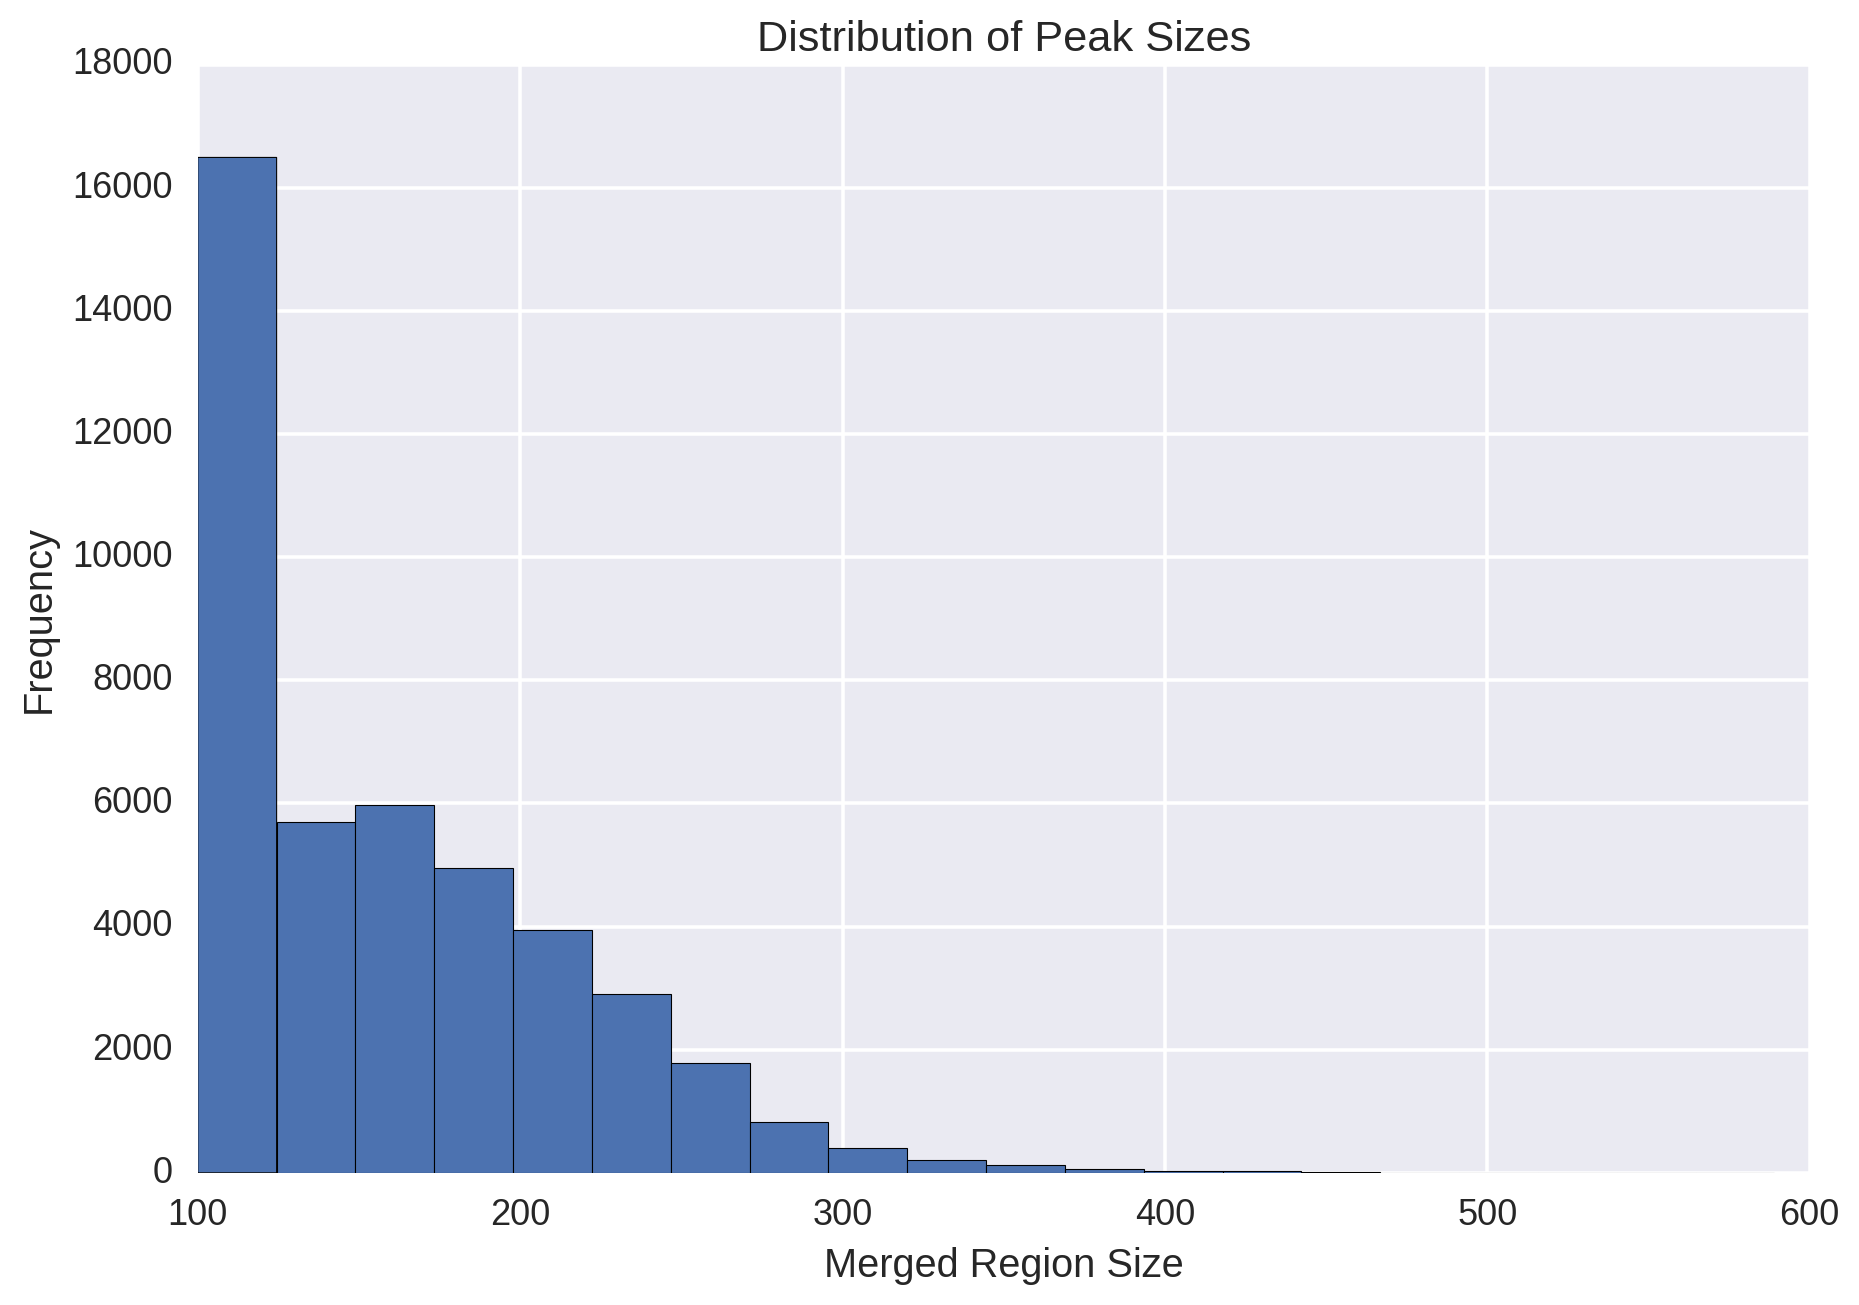

In [245]:
merged_motif_frame=pd.read_pickle('motif_frame.pickle')
summary_frame = pd.read_pickle('summary_frame.pickle')

# plot motif positions to make sure that nothing went wrong with the merging
positions = [x.split(':')[1] for x in summary_frame['Position'].values]
sizes = [int(x.split('-')[1]) - int(x.split('-')[0]) for x in positions]
plt.hist(sizes, bins = 20);
plt.xlabel('Merged Region Size')
plt.ylabel('Frequency')
plt.title('Distribution of Peak Sizes')

/bioinformatics/software/anaconda3/lib/python3.4/site-packages/seaborn/categorical.py:1613: UserWarning: The boxplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)
/bioinformatics/software/anaconda3/lib/python3.4/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


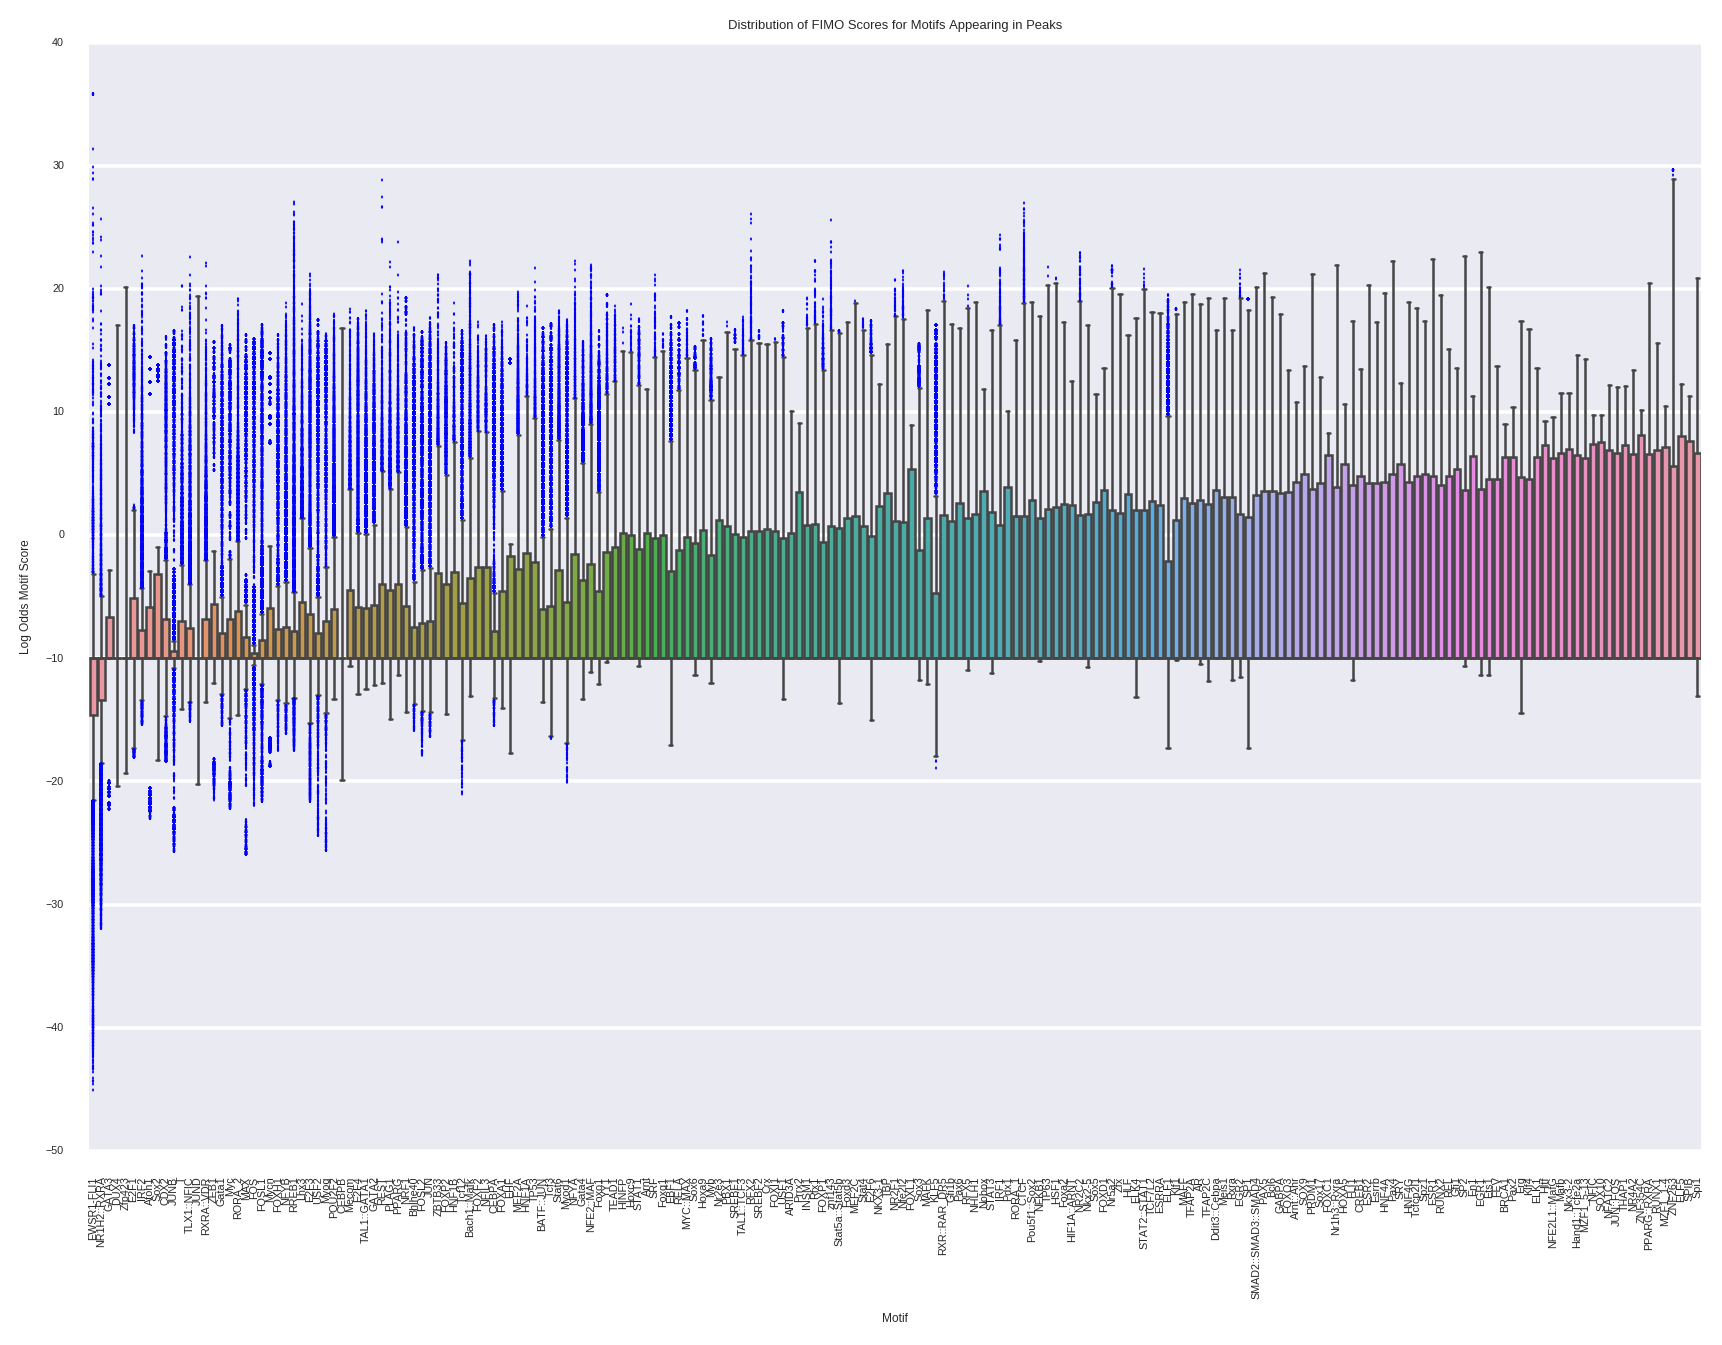

In [246]:
# plot distribution of motif scores
sns.set_context('talk', font_scale=0.3)
data_dict = {}
count = 0
sort_list = []
for col in merged_motif_frame.columns[3:]:
    data_dict[col] = merged_motif_frame[col].values
    sort_list.append((col, np.mean(merged_motif_frame[col].values)))
sort_list = sorted(sort_list,key=lambda x:x[1])
order = [x[0] for x in sort_list]
sns.boxplot(pd.DataFrame(data_dict), 
            fliersize = 1.0,linewidth=0.9,
            order = order)
plt.xticks(rotation=90)
# plt.xticks([])
plt.xlabel("Motif")
plt.ylabel("Log Odds Motif Score")
plt.title("Distribution of FIMO Scores for Motifs Appearing in Peaks")
plt.savefig('motifScore_boxplot.pdf')
del data_dict
sns.set_context('talk', font_scale=1.0)



### Clustering

In [ ]:
numColors = 16
colorDict = dict(zip(range(numColors),sns.color_palette("Set1") + sns.color_palette("Set2") + sns.color_palette("colorblind")))
# co clustering on peak scores
numRowClusters = 6
numColClusters = 4

for chrom in sorted(list(set(summary_frame['chr'].values))):
    if not "Un" in chrom and not "random" in chrom:
        currentPeakData = summary_frame[summary_frame['chr']== chrom].ix[:,3:]
        currentMotifData = merged_motif_frame[merged_motif_frame['chr']== chrom].ix[:,3:]

        if currentPeakData.shape[0]> 2 and currentMotifData.shape[0] > 2:
            print('merged_' +chrom + ' (' + str(currentPeakData.shape[0]) + ' peaks)')

            cg = sns.clustermap(np.log2(currentPeakData + 1), yticklabels=False, cmap='Blues')
            plt.close()
            reordered_indices = cg.dendrogram_row.reordered_ind
            row_linkage = cg.dendrogram_row.linkage
            col_linkage = cg.dendrogram_col.linkage
            
            row_flatCluster = scipy.cluster.hierarchy.fcluster(row_linkage, numRowClusters, criterion="maxclust")
            col_flatCluster = scipy.cluster.hierarchy.fcluster(col_linkage, numColClusters, criterion="maxclust")
            
            row_colors = [colorDict[row_flatCluster[i] -1] for i in range(len(currentPeakData.index))]
            col_colors = [colorDict[col_flatCluster[i] -1] for i in range(len(currentPeakData.columns))]
            sns.clustermap(np.log2(currentPeakData+0.0000001), 
                         row_linkage = row_linkage,
                         col_linkage = col_linkage,
                         row_colors = row_colors,
                         cmap="Blues",
                         yticklabels = False
                         )
            plt.title('merged_peakScores_coclustered_' +chrom + ' (' + str(currentPeakData.shape[0]) + ' peaks)')
            plt.savefig('merged_peakScores_coclustered_' + chrom +'_clustermap.png')
            plt.close()
            
#             sns.clustermap(currentMotifData, 
#                          row_linkage = row_linkage,
#                          row_colors = row_colors,
#                          cmap="Greens",
#                          yticklabels = False,
#                          xticklabels = False
#                          )
#             plt.title('merged_motif_peakScoreCoclustered_' +chrom + ' (' + str(currentMotifData.shape[0]) + ' peaks)')
#             plt.savefig('merged_motif_peakScoreCoclustered_' + chrom +'_clustermap.png')
#             plt.close()





### Finding significant motifs

In [12]:
# find significant motifs with significantly different scores depending on binding or no binding of a factor in notx conditions
#
# use the following tests:
# t-test
# mann-whitney u-test
# Kolmogorov–Smirnov test
p_threshold = 0.01

ttest_dict = {x:[] for x in summary_frame.columns[4:-6]}
mannwhitney_dict = {x:[] for x in summary_frame.columns[4:-6]}
ks_dict = {x:[] for x in summary_frame.columns[4:-6]}
for f in summary_frame.columns[4:-6]:
    print(f)
    binding_positions = (summary_frame[f] > 0).values
    null_positions = (summary_frame[f] == 0).values
    
    current_ttest = ttest_dict[f]
    current_mwu = mannwhitney_dict[f]
    current_ks = ks_dict[f]
    
    for col in merged_motif_frame.columns[3:]:

        binding_scores = merged_motif_frame[col][binding_positions].values
        null_scores = merged_motif_frame[col][null_positions].values       

        ttest_val, ttest_pval = scipy.stats.ttest_ind(binding_scores,null_scores,equal_var=False)
        mwu_stat, mwu_pval = scipy.stats.mannwhitneyu(binding_scores, null_scores)
        D, ks_pval = scipy.stats.ks_2samp(binding_scores,null_scores)
        
        current_ttest.append(ttest_pval)
        current_mwu.append(mwu_pval/2.0) # correct for one tailed test
        current_ks.append(ks_pval)

# convert dictionaries to data frames for plotting
ttest_frame = pd.DataFrame(ttest_dict)
ttest_frame = ttest_frame.fillna(1)
ttest_frame.index = merged_motif_frame.columns[3:]

mannwhitney_frame = pd.DataFrame(mannwhitney_dict)
mannwhitney_frame =mannwhitney_frame.fillna(1)
mannwhitney_frame.index = merged_motif_frame.columns[3:]

ks_frame = pd.DataFrame(ks_dict)
ks_frame = ks_frame.fillna(1)
ks_frame.index = merged_motif_frame.columns[3:]

lxr_notx
ncor_kla
ncor_notx
p65_kla
p65_notx
pparg_notx
PolII-KLA
PolII-notx


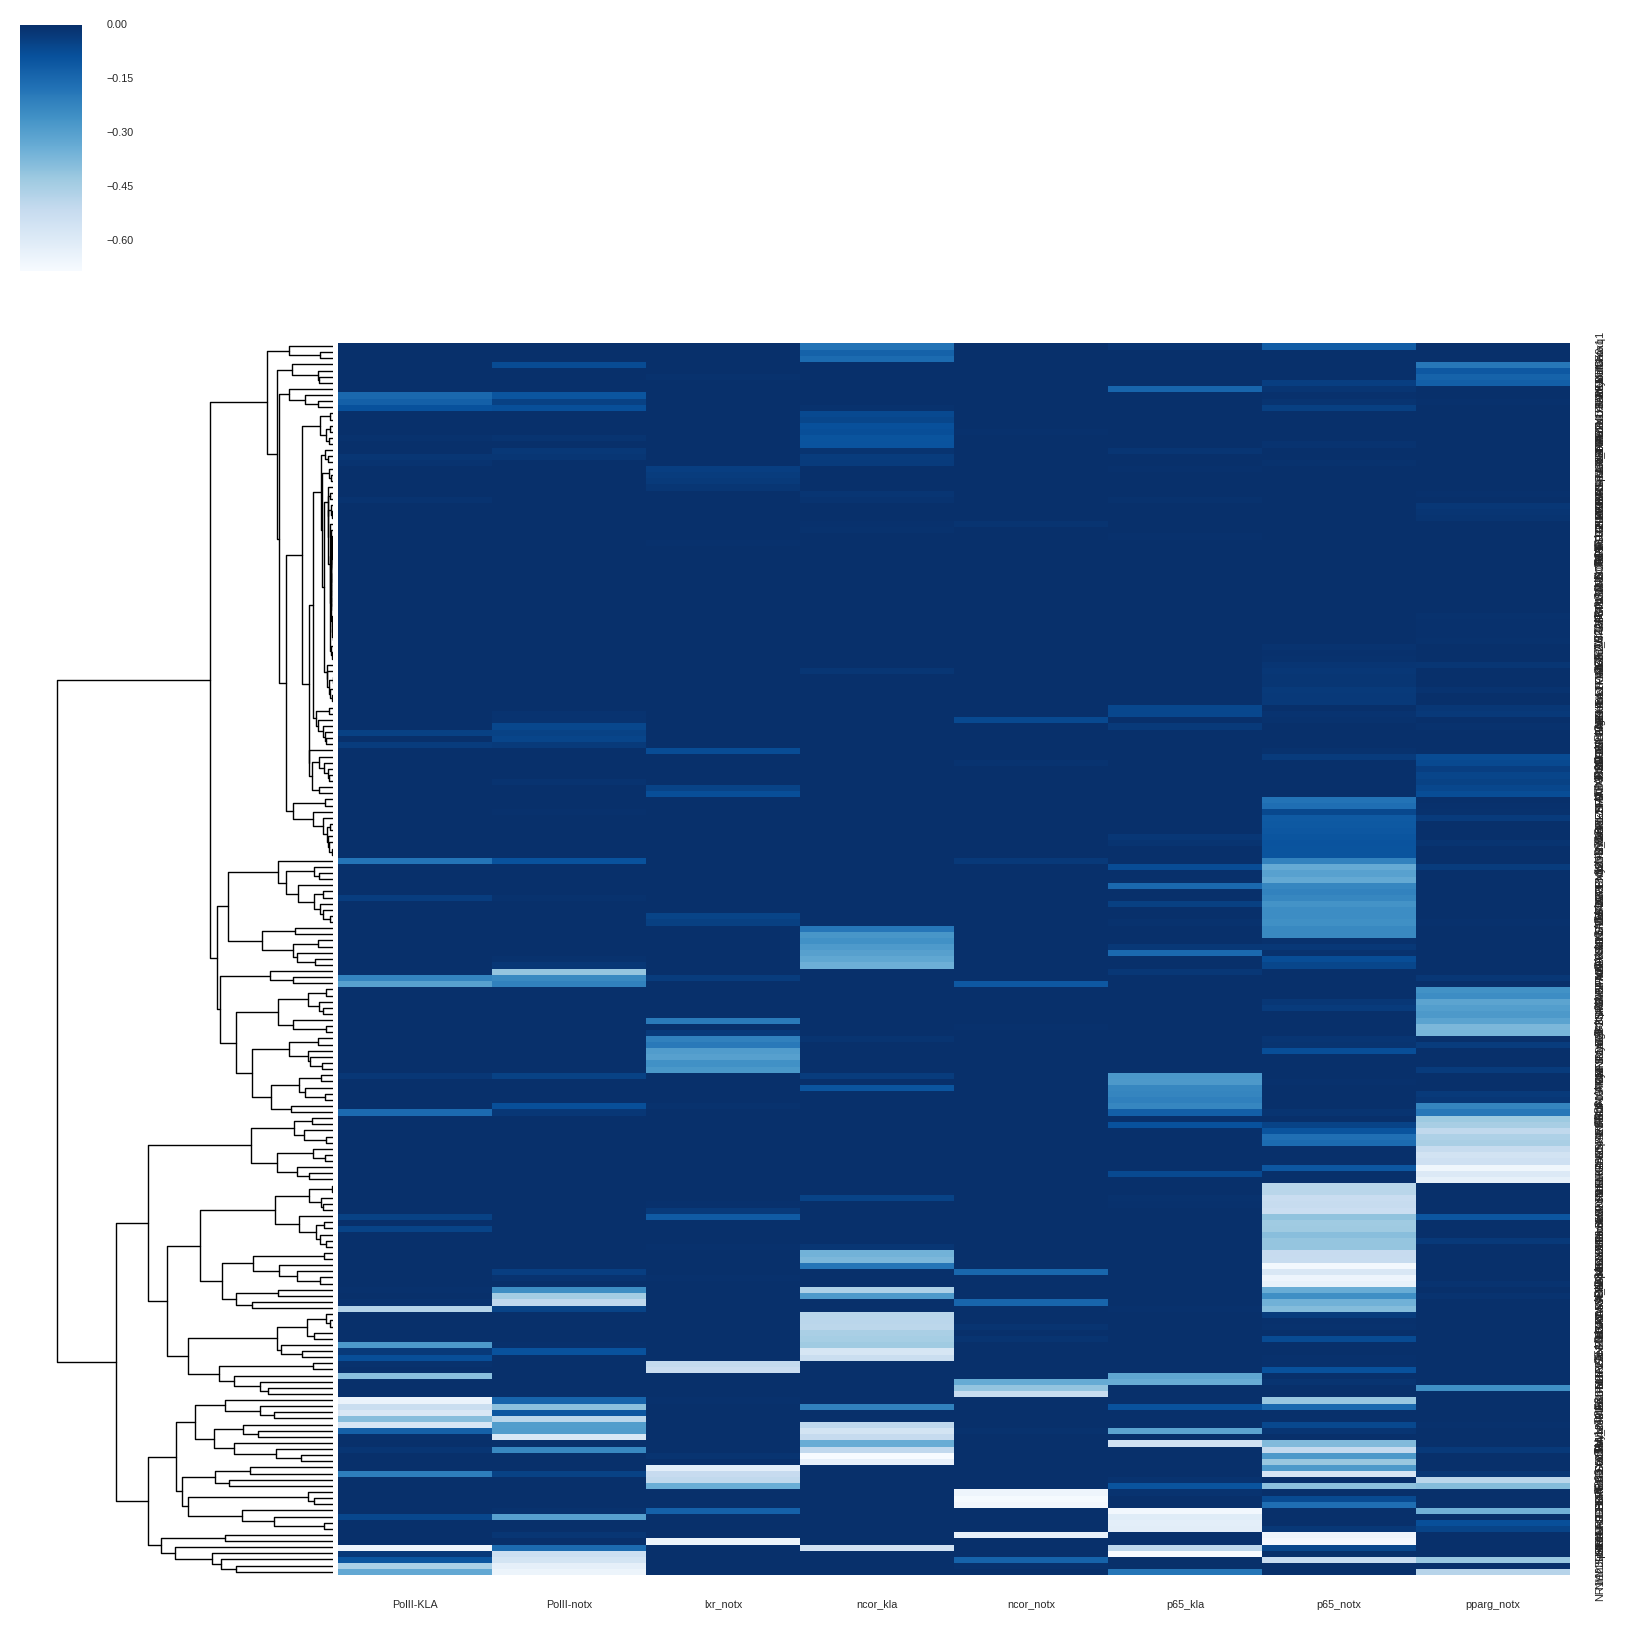

In [13]:
sns.set_context('talk',font_scale=0.3)
sns.clustermap(-1* np.log(ttest_frame+1), cmap='Blues', col_cluster=False)
sns.set_context('talk',font_scale=1.0)



lxr_notx
ncor_kla
ncor_notx
p65_kla
p65_notx
pparg_notx
PolII-KLA
PolII-notx


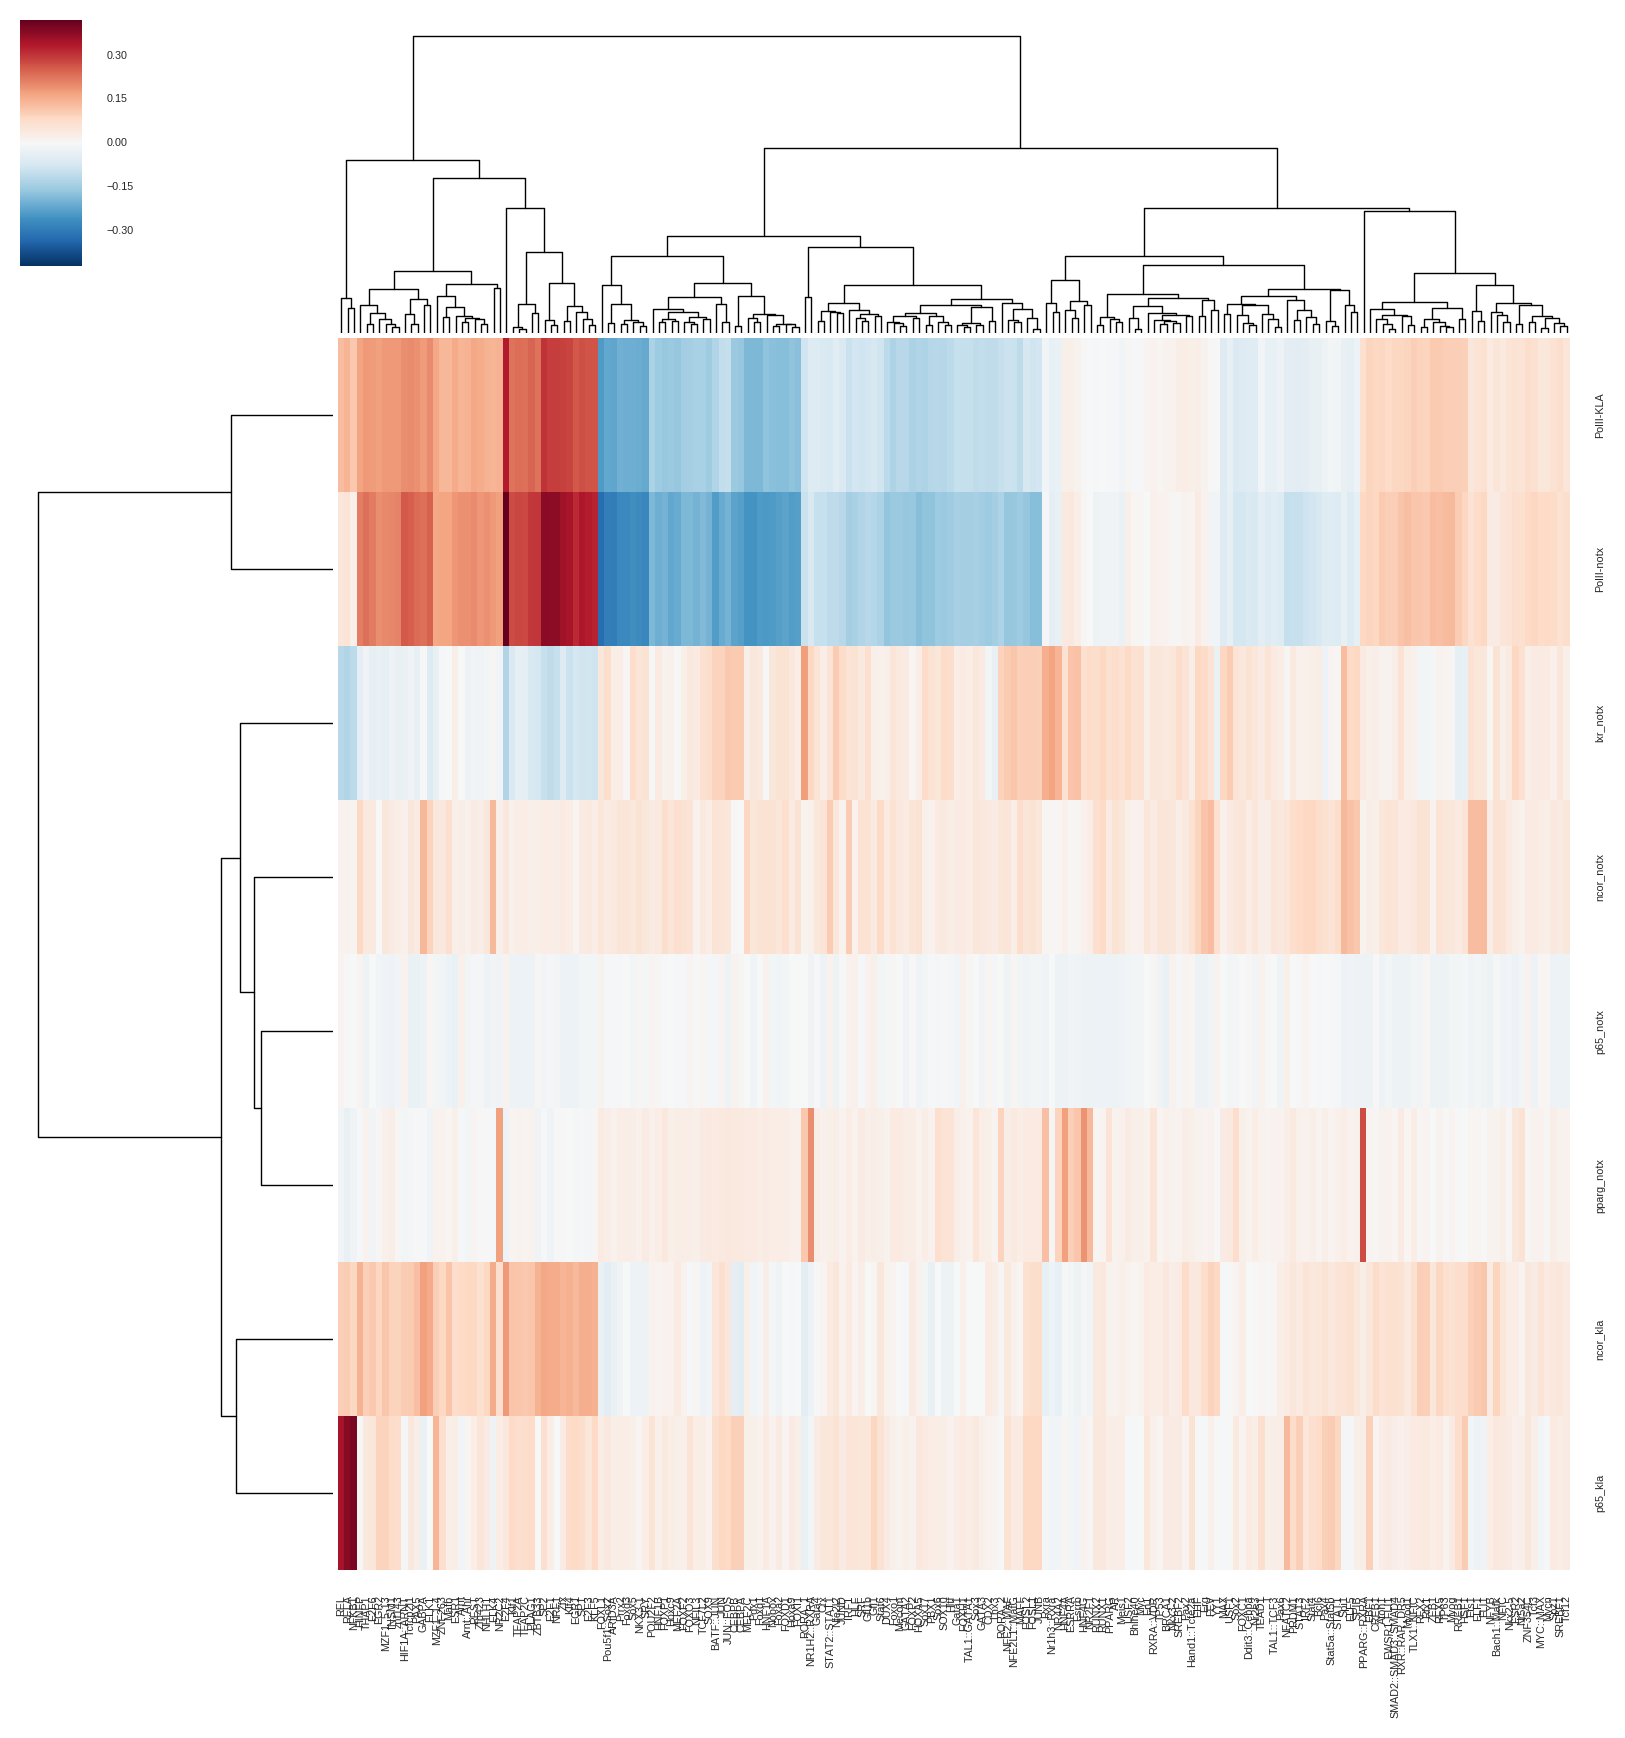

In [14]:
# plot the correlation between motif scores and peak scores
factorTreatments = summary_frame.columns[4:-6].values
motifs = merged_motif_frame.columns[4:-6].values
pearson_matrix = np.zeros((len(factorTreatments), len(motifs)))
spearman_matrix = np.zeros((len(factorTreatments), len(motifs)))
for i in range(len(factorTreatments)):
    ft = factorTreatments[i]
    print(ft)
    for j in range(len(motifs)):
        m = motifs[j]
        peak_scores = summary_frame[ft].values
        motif_scores = merged_motif_frame[m].values
        pearson,  pearson_p_val= scipy.stats.pearsonr(peak_scores, motif_scores)
        spearman, spearman_p_val = scipy.stats.spearmanr(peak_scores, motif_scores)
        pearson_matrix[i][j] = pearson
        spearman_matrix[i][j] = spearman

spearman_frame = pd.DataFrame(spearman_matrix)
spearman_frame.index = factorTreatments
spearman_frame.columns = motifs

pearson_frame = pd.DataFrame(spearman_matrix)
pearson_frame.index = factorTreatments
pearson_frame.columns = motifs

# fill in missing values
# pearson_frame = pearson_frame.fillna(0)
# spearman_frame = spearman_frame.fillna(0)
sns.set_context('talk',font_scale=0.3)
sns.clustermap(spearman_frame)
plt.savefig('spearman_motifScore_peakScore.pdf')
sns.set_context('talk',font_scale=1.0)



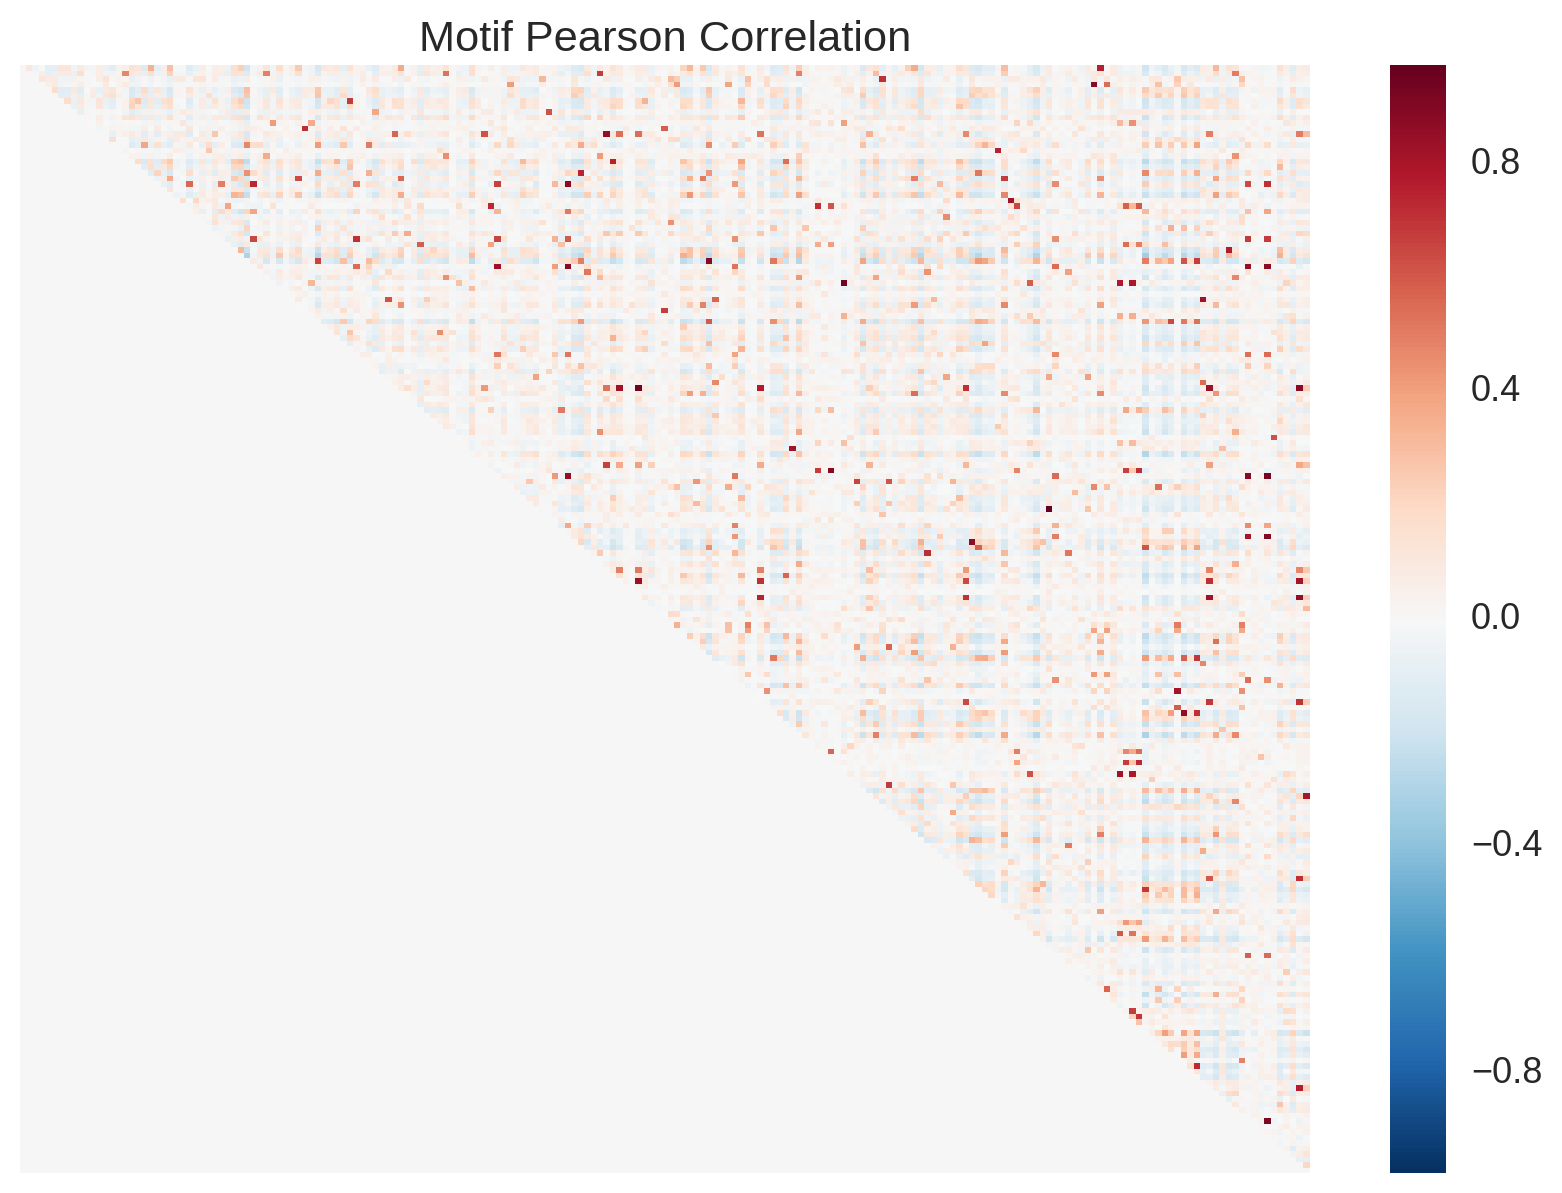

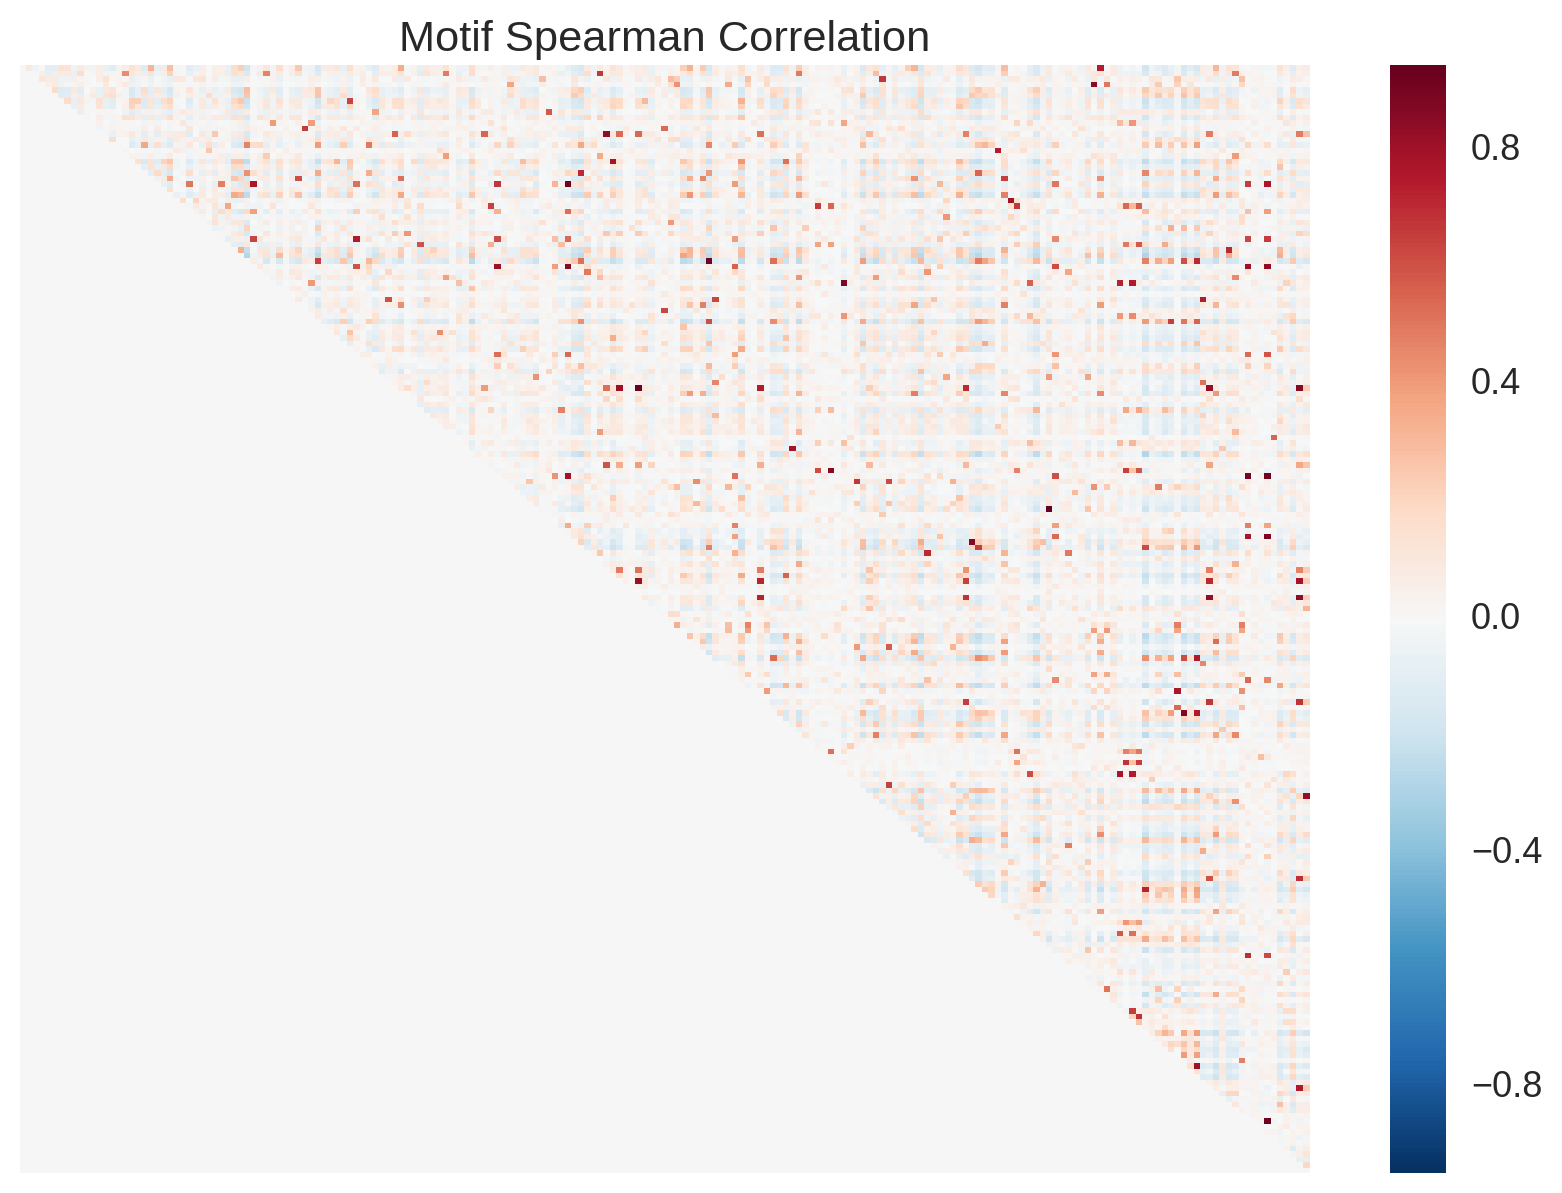

In [15]:
# Show how motif scores correlate to one another
# plot distribution of motif scores
data_dict = {}
count = 0
sort_list = []
motifs = merged_motif_frame.columns[3:]
motif_corr_pearson_matrix = np.zeros((len(motifs), len(motifs)))
motif_corr_spearman_matrix = np.zeros((len(motifs), len(motifs)))
# for every pair of motifs
for i in range(len(motifs) -1 ):
    for j in range(i+1, len(motifs)):
        motif1 = motifs[i]
        motif2 = motifs[j]
        # get relevant motif scores
        motifScores1 = merged_motif_frame[motif1].values
        motifScores2 = merged_motif_frame[motif2].values
        # calculate spearman and peason correlation
        r, p_val_pearson = scipy.stats.pearsonr(motifScores1, motifScores2)
        rho, p_val_spearman = scipy.stats.spearmanr(motifScores1, motifScores2)
        # fill in position in matrix
        motif_corr_pearson_matrix[i][j] = r
        motif_corr_spearman_matrix[i][j] = rho

# create data frames
motif_corr_pearson_frame = pd.DataFrame(motif_corr_pearson_matrix)
motif_corr_spearman_frame = pd.DataFrame(motif_corr_spearman_matrix)

motif_corr_pearson_frame = motif_corr_pearson_frame.fillna(0)
motif_corr_pearson_frame.columns = motifs
motif_corr_pearson_frame.index = motifs

motif_corr_spearman_frame = motif_corr_spearman_frame.fillna(0)
motif_corr_spearman_frame.columns = motifs
motif_corr_spearman_frame.index = motifs

sns.heatmap(motif_corr_pearson_frame,xticklabels = False, yticklabels = False)
plt.title('Motif Pearson Correlation')
plt.show()

sns.heatmap(motif_corr_spearman_frame,xticklabels = False, yticklabels = False)
plt.title('Motif Spearman Correlation')
plt.show()

## Visualize Annotations of NCoR Peaks

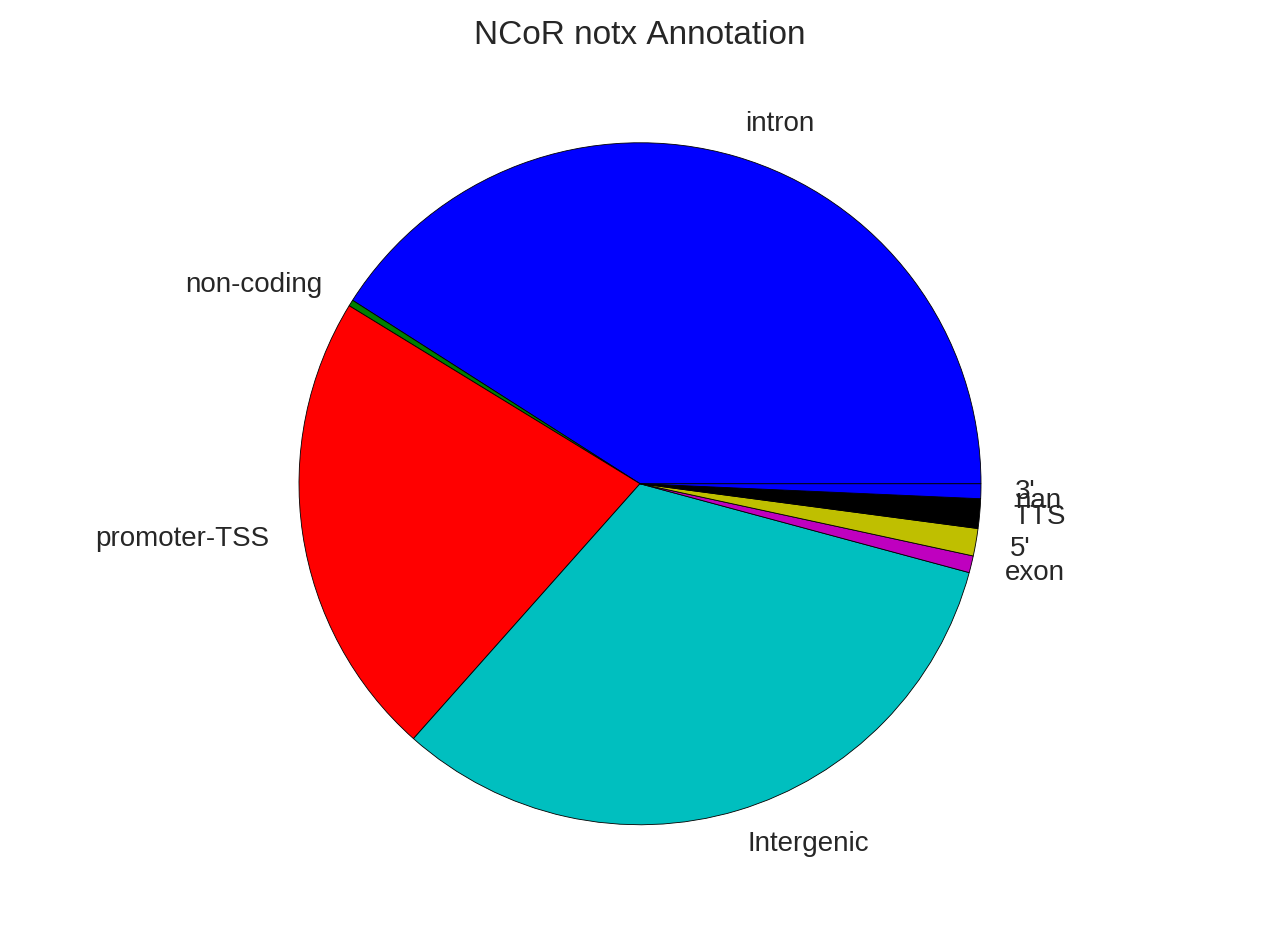

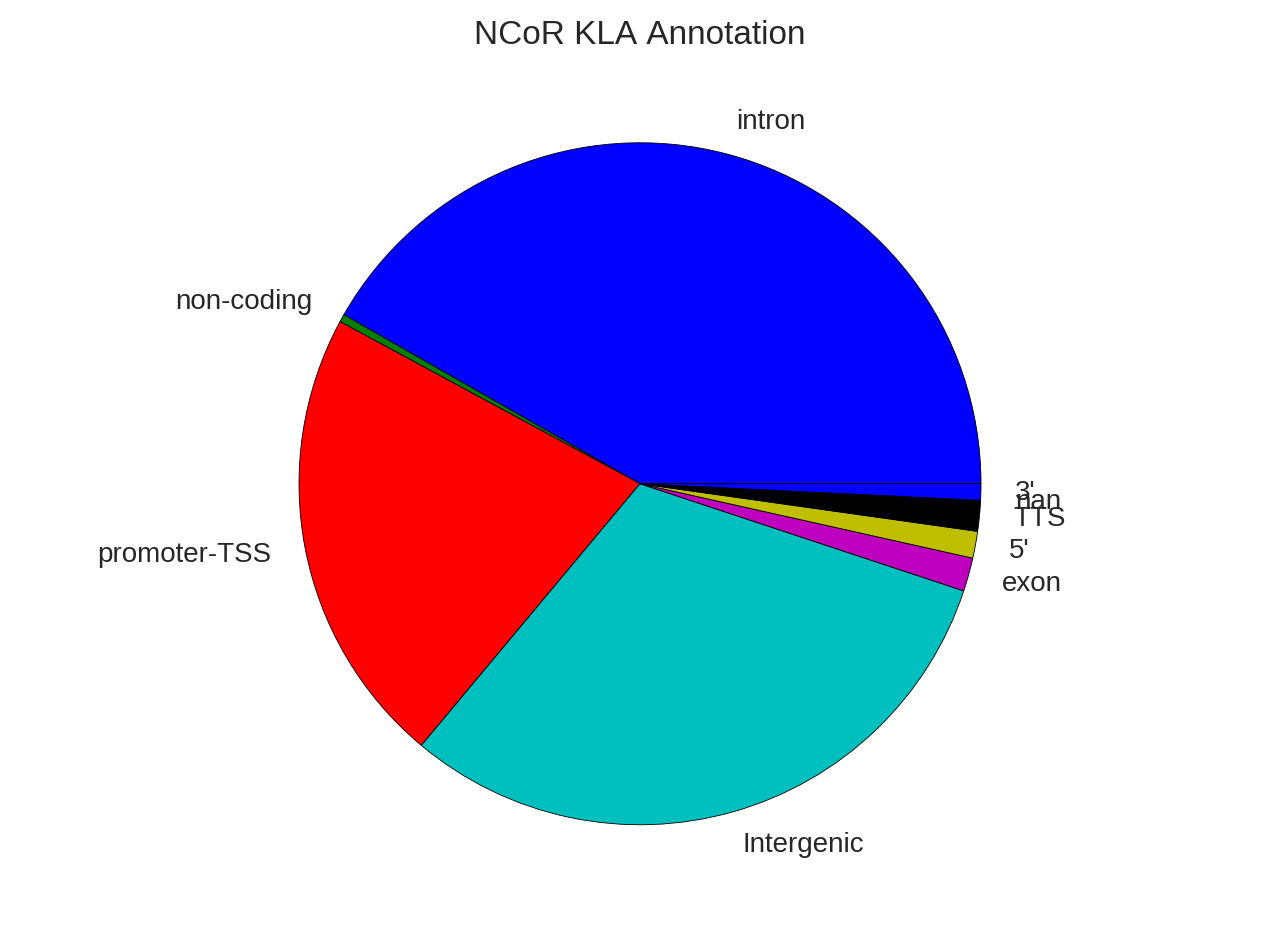

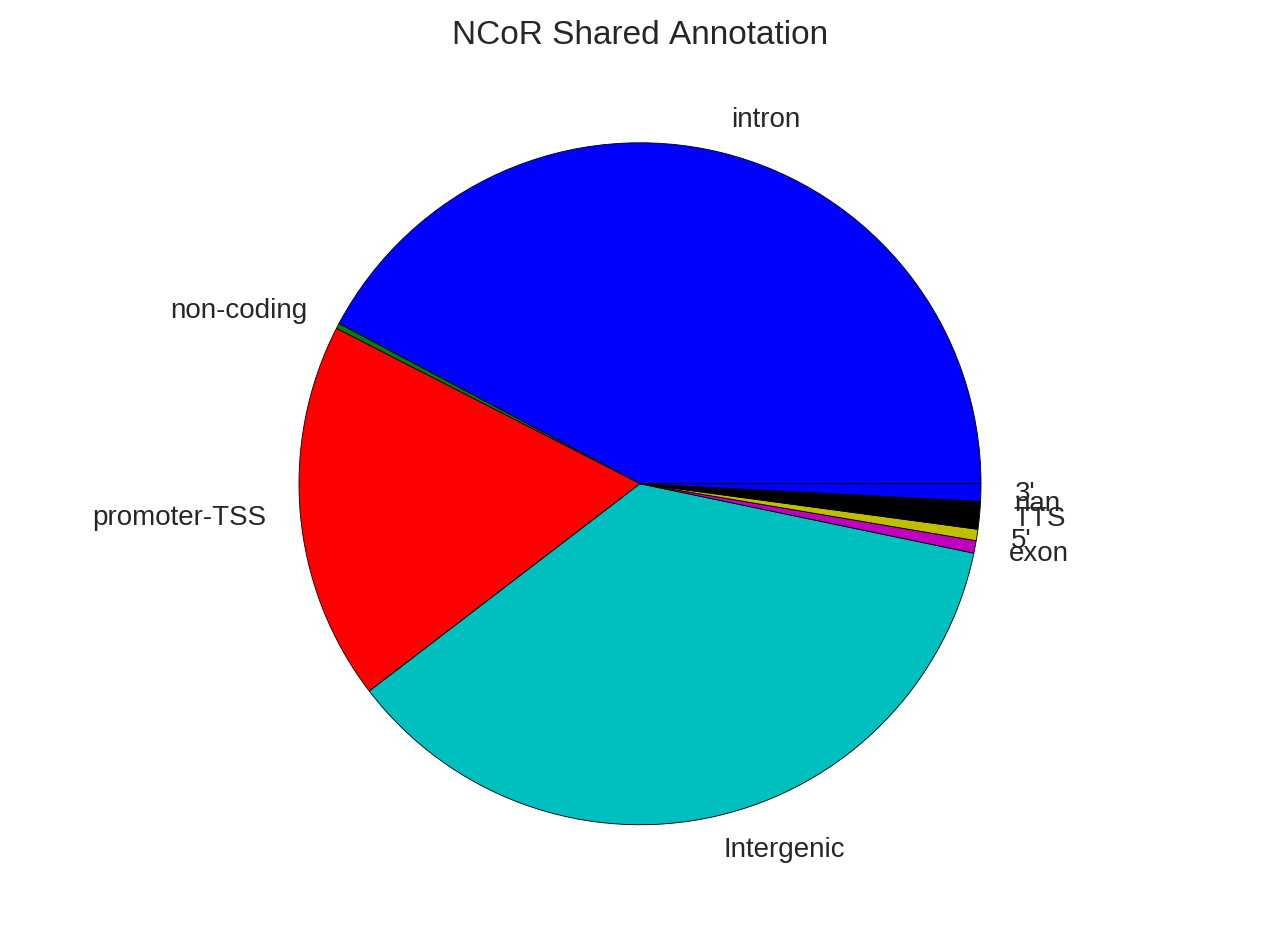

In [247]:
sns.set_context('notebook',font_scale=1.0)

plt.axis('equal')

# for notx only peaks
labels = []
counts =  []
notx_ids = summary_frame[(summary_frame['ncor_notx'] > 0) & (summary_frame['ncor_kla'] == 0)]['ID'].values
annotations = [id_annotation_dict[x] for x in notx_ids]
for ann in annotationTypes:
    labels.append(ann)
    counts.append(annotations.count(ann))
plt.pie(counts, labels = labels);
plt.title('NCoR notx Annotation')
plt.show()

# for KLA only peaks
plt.axis('equal')
labels = []
counts =  []
kla_ids = summary_frame[(summary_frame['ncor_notx'] == 0) & (summary_frame['ncor_kla'] > 0)]['ID'].values
annotations = [id_annotation_dict[x] for x in kla_ids]
for ann in annotationTypes:
    labels.append(ann)
    counts.append(annotations.count(ann))
plt.pie(counts, labels = labels);
plt.title('NCoR KLA Annotation')
plt.show()

# for shared peaks
plt.axis('equal')
labels = []
counts =  []
shared_ids = summary_frame[(summary_frame['ncor_notx'] > 0) & (summary_frame['ncor_kla'] > 0)]['ID'].values
annotations = [id_annotation_dict[x] for x in shared_ids]
for ann in annotationTypes:
    labels.append(ann)
    counts.append(annotations.count(ann))
plt.pie(counts, labels = labels);
plt.title('NCoR Shared Annotation')
plt.show()

## Work with marks of active enhancers

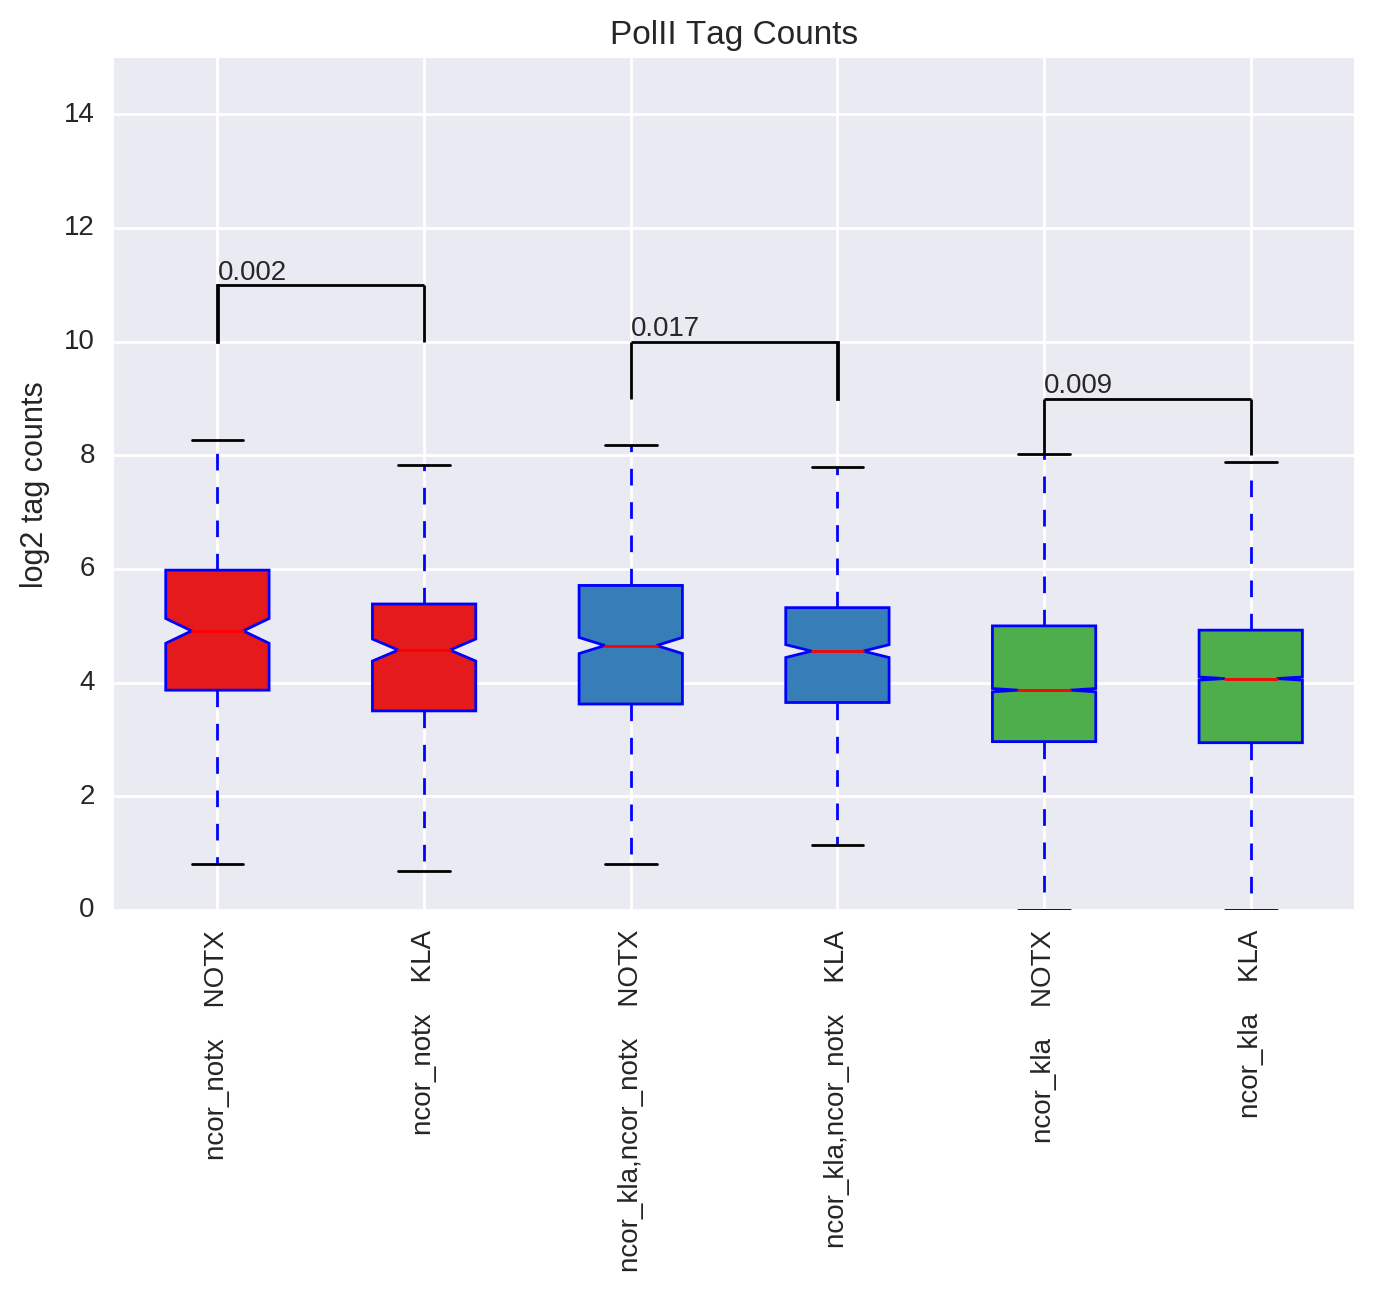

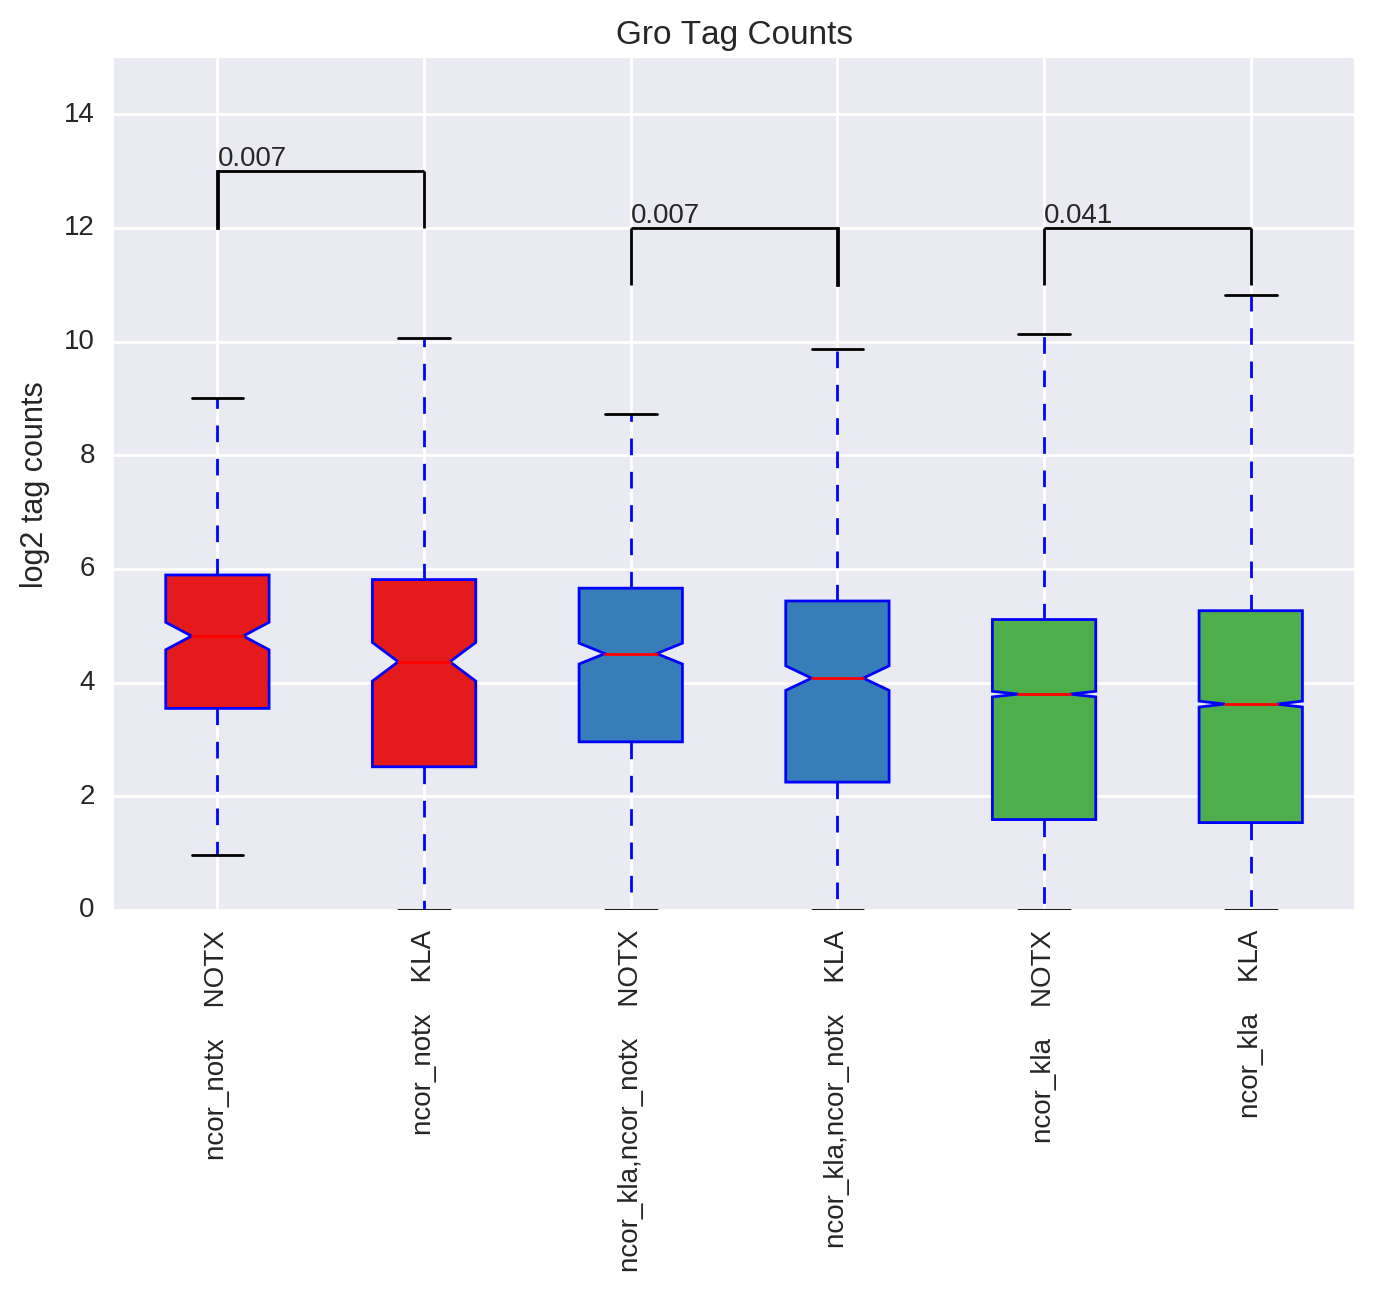

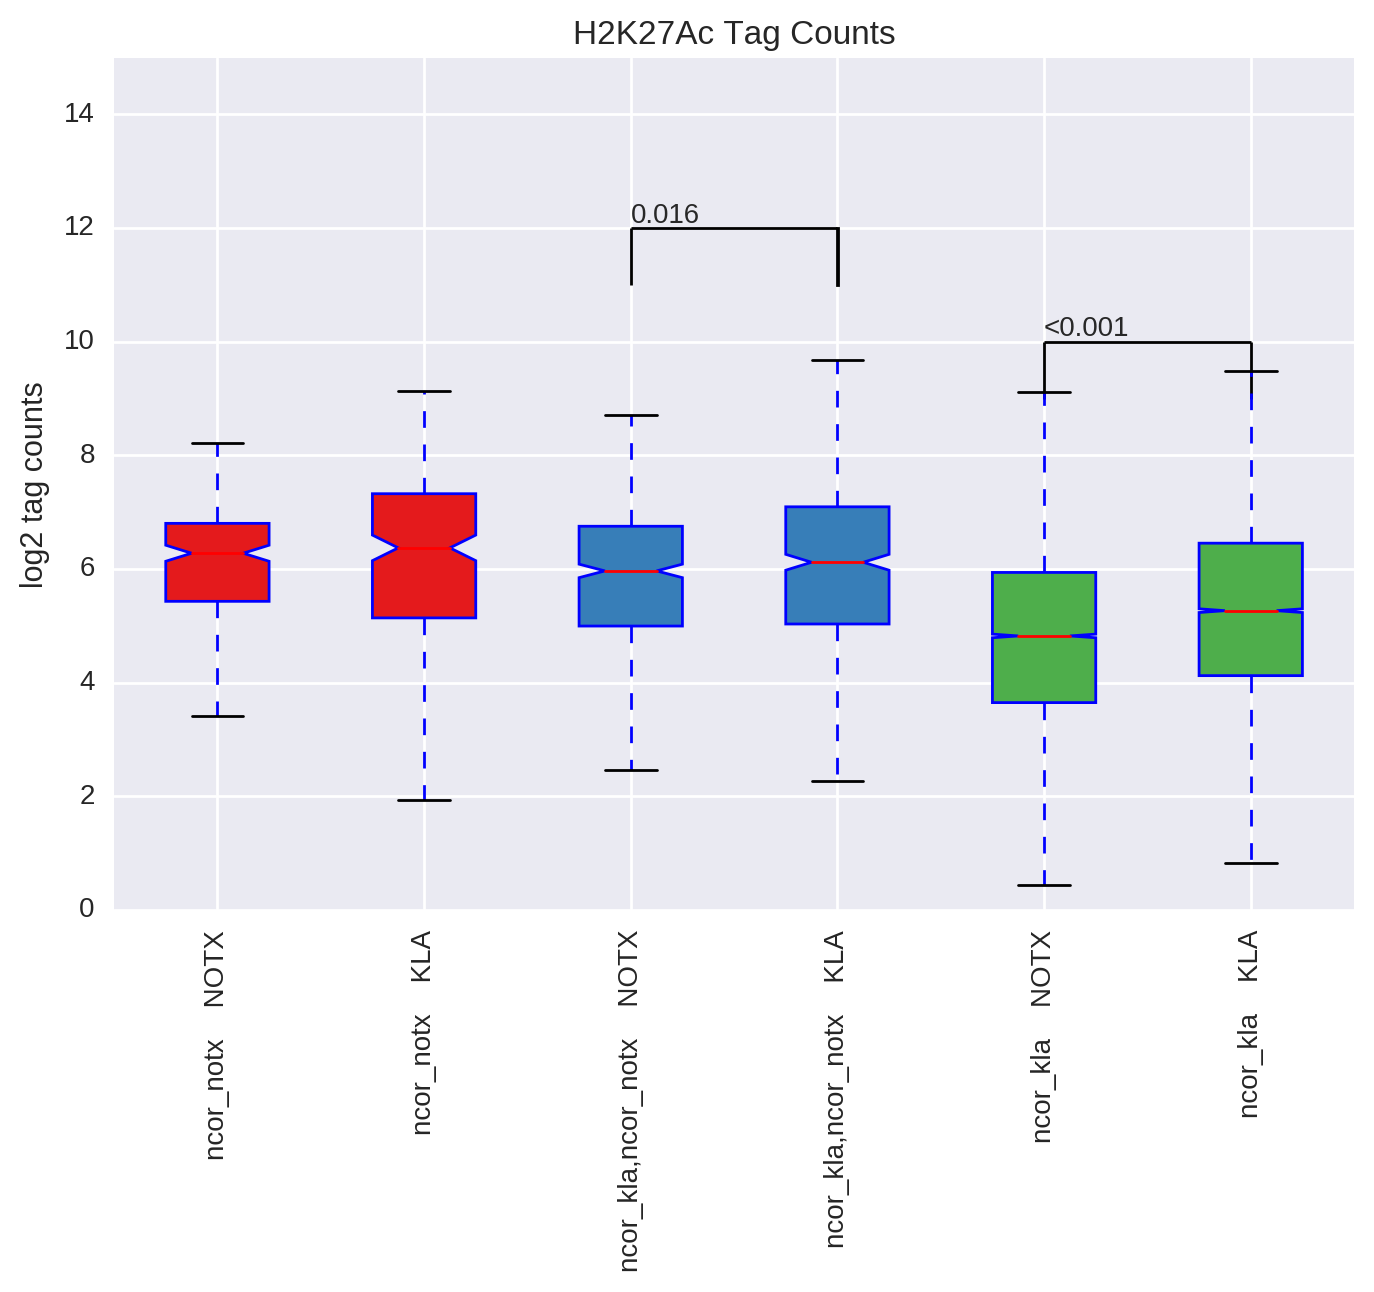

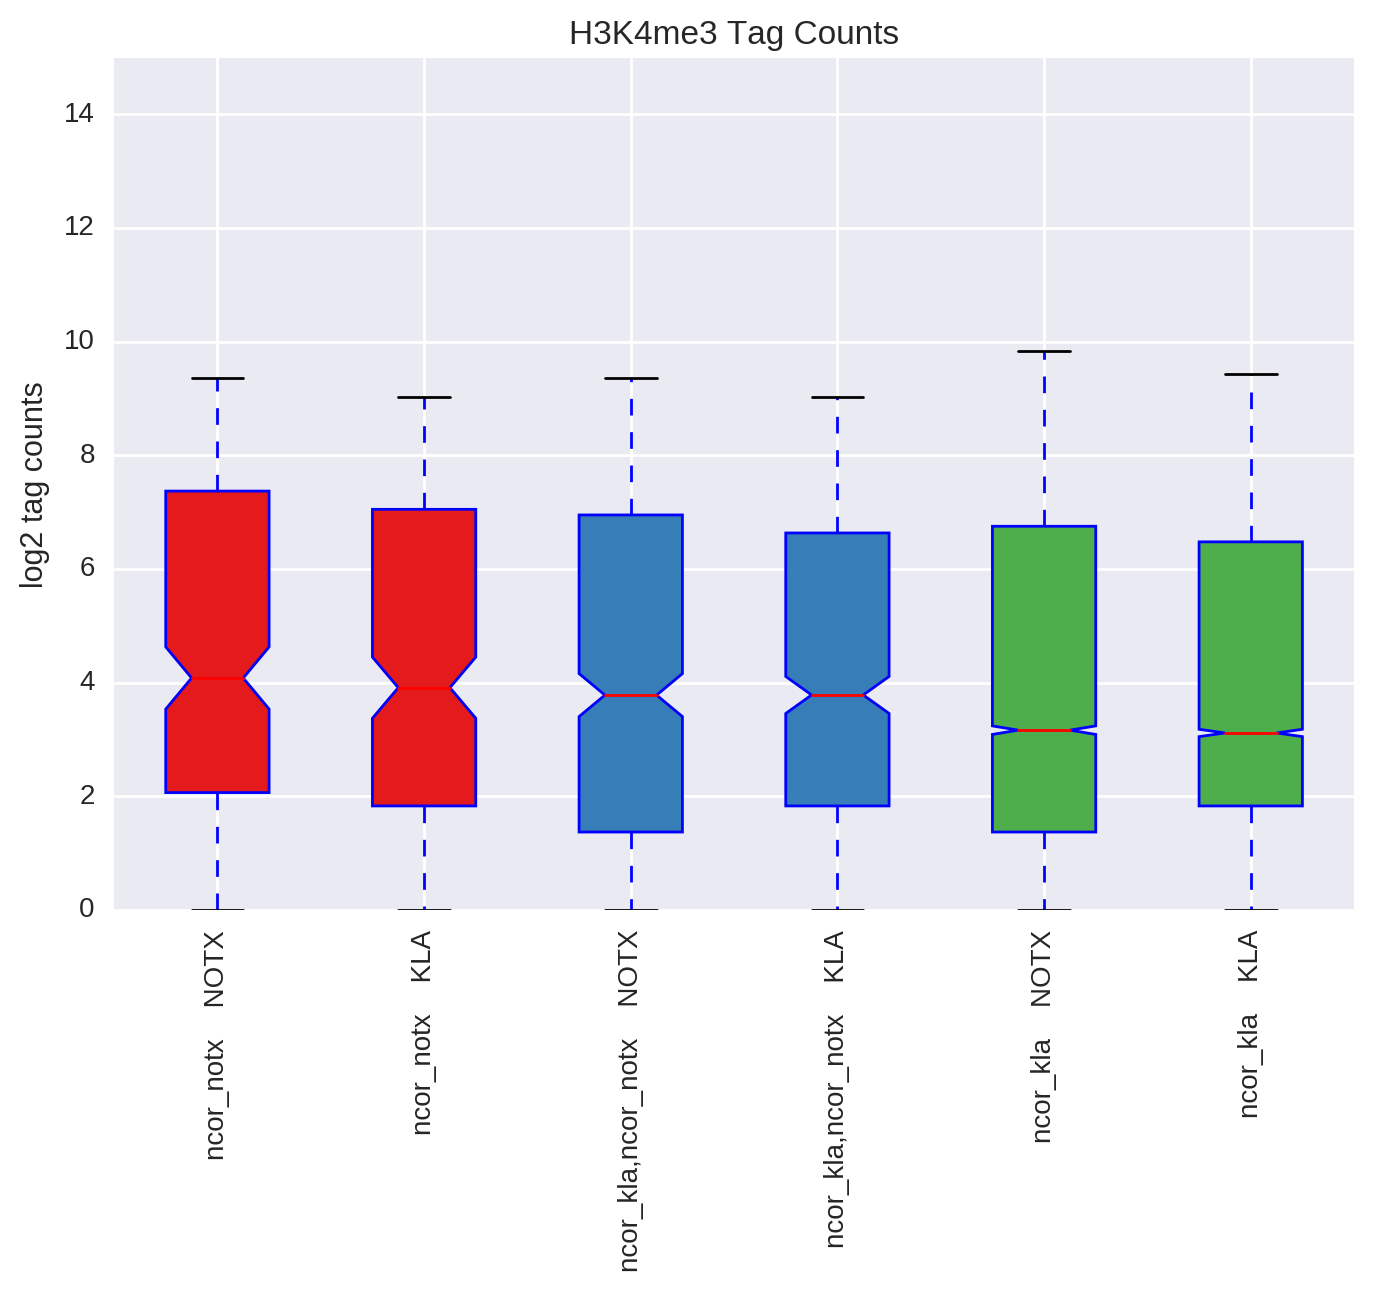

In [248]:
# factor_groups = set(summary_frame['Factors'].values)
numColors = 16
colorDict = dict(zip(range(numColors),sns.color_palette("Set1") + sns.color_palette("Set2") + sns.color_palette("colorblind")))

summary_frame['tempFactors'] = [','.join([y for y in x.split(',') if 'ncor' in y]) for x in summary_frame['Factors'].values]

factor_groups =['ncor_notx',
                'ncor_kla,ncor_notx',
                'ncor_kla' 
 ]

colorValues = list(colorDict.values())
colors = []

for i in range(len(factor_groups)):
    colors.append(colorValues[i])
    colors.append(colorValues[i])

p_threshold = 0.05
# for Pol II
counts = []
labels = []
pvals = []

for cluster in factor_groups:
    cluster_name = cluster
    ids = summary_frame[summary_frame['tempFactors'] == cluster_name].index.values
    notx_values = summary_frame.ix[ids,'PolII-notx'].values
    kla_values = summary_frame.ix[ids,'PolII-KLA'].values
    notx_values = np.log2(notx_values + 1)
    kla_values = np.log2(kla_values + 1)


    if np.sum(notx_values) > 0 or np.sum(kla_values) > 0 :
        labels.append(cluster_name +'    NOTX')
        labels.append(cluster_name +'    KLA')
        stat, p = scipy.stats.ttest_ind(notx_values,kla_values)
        counts.append(notx_values)
        counts.append(kla_values)
        stat, p = scipy.stats.ttest_ind(notx_values,kla_values)
        pvals.append(p)
box = plt.boxplot(counts, notch=True, patch_artist=True);

for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
# annotate plot with p_values
ax = plt.gca()
for i in range(len(pvals)):
    p = pvals[i]
    if p < p_threshold: 
        height = int(np.percentile(counts[2*i] + counts[2*i+1], 75))
        ax.arrow(2*i+1, height, 0,-1, linewidth=1.0,head_width=0.0)
        ax.arrow(2*i+2, height, 0,-1, linewidth=1.0,head_width=0.0)
        ax.arrow(2*i+1,height ,1,0, linewidth=1.0,head_width=0.0)
        ax.annotate("{:.3f}".format(p).replace('0.000','<0.001'),xy=(2*i+1,height+0.1))
    
plt.xticks(range(1,len(labels)+1), labels, rotation =90);
plt.ylim([0,15])
plt.ylabel('log2 tag counts')
plt.title('PolII Tag Counts')
plt.show()


# For GRO-seq
counts = []
labels = []
pvals = []

for cluster in factor_groups:
    cluster_name = cluster
    ids = summary_frame[summary_frame['tempFactors'] == cluster_name].index.values
    notx_values = summary_frame.ix[ids,'Gro-notx'].values
    kla_values = summary_frame.ix[ids,'Gro-KLA'].values
    notx_values = np.log2(notx_values + 1)
    kla_values = np.log2(kla_values + 1)

    if np.sum(notx_values) > 0 or np.sum(kla_values) > 0 :
        labels.append(cluster_name +'    NOTX')
        labels.append(cluster_name +'    KLA')
        stat, p = scipy.stats.ttest_ind(notx_values,kla_values)
        counts.append(notx_values)
        counts.append(kla_values)
        stat, p = scipy.stats.ttest_ind(notx_values,kla_values)
        pvals.append(p)
box = plt.boxplot(counts, notch=True, patch_artist=True);

for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
# annotate plot with p_values
ax = plt.gca()
for i in range(len(pvals)):
    p = pvals[i]
    if p < p_threshold: 
        height = int(np.percentile(counts[2*i] + counts[2*i+1], 90))
        ax.arrow(2*i+1, height, 0,-1, linewidth=1.0,head_width=0.0)
        ax.arrow(2*i+2, height, 0,-1, linewidth=1.0,head_width=0.0)
        ax.arrow(2*i+1,height ,1,0, linewidth=1.0,head_width=0.0)
        ax.annotate("{:.3f}".format(p).replace('0.000','<0.001'),xy=(2*i+1,height+0.1))
        
plt.xticks(range(1,len(labels)+1), labels, rotation =90);
plt.ylabel('log2 tag counts')
plt.title('Gro Tag Counts')
plt.ylim([0,15])
plt.show()

# For H3K27Ac
counts = []
labels = []
pvals = []
for cluster in factor_groups:
    cluster_name = cluster
    ids = summary_frame[summary_frame['tempFactors'] == cluster_name].index.values
    notx_values = summary_frame.ix[ids,'H3K27Ac-notx'].values
    kla_values = summary_frame.ix[ids,'H3K27Ac-KLA'].values
    notx_values = np.log2(notx_values + 1)
    kla_values = np.log2(kla_values + 1)

    if np.sum(notx_values) > 0 or np.sum(kla_values) > 0 :
        labels.append(cluster_name +'    NOTX')
        labels.append(cluster_name +'    KLA')
        stat, p = scipy.stats.ttest_ind(notx_values,kla_values)
        counts.append(notx_values)
        counts.append(kla_values)
        stat, p = scipy.stats.ttest_ind(notx_values,kla_values)
        pvals.append(p)
box = plt.boxplot(counts, notch=True, patch_artist=True);

for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
# annotate plot with p_values
ax = plt.gca()
for i in range(len(pvals)):
    p = pvals[i]
    if p < p_threshold: 
        height = int(np.percentile(counts[2*i] + counts[2*i+1], 50))
        ax.arrow(2*i+1, height, 0,-1, linewidth=1.0,head_width=0.0)
        ax.arrow(2*i+2, height, 0,-1, linewidth=1.0,head_width=0.0)
        ax.arrow(2*i+1,height ,1,0, linewidth=1.0,head_width=0.0)
        ax.annotate("{:.3f}".format(p).replace('0.000','<0.001'),xy=(2*i+1,height+0.1))
plt.xticks(range(1,len(labels)+1), labels, rotation =90);
plt.ylim([0,15])
plt.ylabel('log2 tag counts')
plt.title('H2K27Ac Tag Counts')
plt.ylim([0,15])
plt.show()

# For H3K27Ac
counts = []
labels = []
pvals = []
for cluster in factor_groups:
    cluster_name = cluster
    ids = summary_frame[summary_frame['tempFactors'] == cluster_name].index.values
    notx_values = summary_frame.ix[ids,'H3K4me3-notx'].values
    kla_values = summary_frame.ix[ids,'H3K4me3-KLA'].values
    notx_values = np.log2(notx_values + 1)
    kla_values = np.log2(kla_values + 1)

    if np.sum(notx_values) > 0 or np.sum(kla_values) > 0 :
        labels.append(cluster_name +'    NOTX')
        labels.append(cluster_name +'    KLA')
        stat, p = scipy.stats.ttest_ind(notx_values,kla_values)
        counts.append(notx_values)
        counts.append(kla_values)
        stat, p = scipy.stats.ttest_ind(notx_values,kla_values)
        pvals.append(p)
box = plt.boxplot(counts, notch=True, patch_artist=True);

for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
# annotate plot with p_values
ax = plt.gca()
for i in range(len(pvals)):
    p = pvals[i]
    if p < p_threshold: 
        height = int(np.percentile(counts[2*i] + counts[2*i+1], 50))
        ax.arrow(2*i+1, height, 0,-1, linewidth=1.0,head_width=0.0)
        ax.arrow(2*i+2, height, 0,-1, linewidth=1.0,head_width=0.0)
        ax.arrow(2*i+1,height ,1,0, linewidth=1.0,head_width=0.0)
        ax.annotate("{:.3f}".format(p).replace('0.000','<0.001'),xy=(2*i+1,height+0.1))
plt.xticks(range(1,len(labels)+1), labels, rotation =90);
plt.ylim([0,15])
plt.ylabel('log2 tag counts')
plt.title('H3K4me3 Tag Counts')
plt.ylim([0,15])
plt.show()
del summary_frame['tempFactors']

In [249]:

# calculate the difference before and after KLA treatment
difference_frame = summary_frame[['ID', 'chr', 'ncor_notx', 'ncor_kla']]
difference_frame = difference_frame[difference_frame.sum(axis=1) > 0]
difference_frame['Gro_difference'] = summary_frame['Gro-KLA'] - summary_frame['Gro-notx']
difference_frame['PolII_difference'] = summary_frame['PolII-KLA'] - summary_frame['PolII-notx']
difference_frame['H3K27Ac_difference'] = summary_frame['H3K27Ac-KLA'] - summary_frame['H3K27Ac-notx']

# difference_frame = difference_frame[difference_frame['chr']=='chr1']
for col in difference_frame.columns[4:]:
    difference_frame[col] = [np.log2(x+1) if x > 0 else -1 * np.log2(-1*x +1) for x in difference_frame[col].values]

notx_difference_frame = difference_frame[(difference_frame['ncor_notx'] > 0) & (difference_frame['ncor_kla'] == 0)]
kla_difference_frame = difference_frame[(difference_frame['ncor_notx'] == 0) & (difference_frame['ncor_kla'] > 0)]
shared_difference_frame = difference_frame[(difference_frame['ncor_notx'] > 0) & (difference_frame['ncor_kla'] > 0)]

In [249]:
### for notx peaks
separation=50
numRowClusters = 4
data = notx_difference_frame.ix[:,-3:]

cg_notx = sns.clustermap(data,col_cluster=False, yticklabels=False, cmap='Greys')
plt.close()

cg_pickle_file = open('cg_notx.pickle','wb')
pickle.dump(cg_notx,cg_pickle_file)
cg_pickle_file.close()

### for KLA peaks
data = kla_difference_frame.ix[:,-3:]

cg_kla = sns.clustermap(data,col_cluster=False, yticklabels=False, cmap='Greys')
plt.close()

cg_pickle_file = open('cg_kla.pickle','wb')
pickle.dump(cg_kla,cg_pickle_file)
cg_pickle_file.close()

### for shared peaks
data = shared_difference_frame.ix[:,-3:]

cg_shared = sns.clustermap(data,col_cluster=False, yticklabels=False, cmap='Greys')
plt.close()

cg_pickle_file = open('cg_shared.pickle','wb')
pickle.dump(cg_shared,cg_pickle_file)
cg_pickle_file.close()

KeyboardInterrupt: 

Exception ignored in: 'zmq.backend.cython.message.Frame.__dealloc__'
Traceback (most recent call last):
  File "checkrc.pxd", line 11, in zmq.backend.cython.checkrc._check_rc (zmq/backend/cython/message.c:3591)
KeyboardInterrupt

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f1fda6bac80> (for post_execute):


ValueError: object too deep for desired array

KeyboardInterrupt: 

In [ ]:
# for notx peaks
separation=70
numRowClusters = 6
data = notx_difference_frame.ix[:,-3:]

cg_notx = pickle.load(open('cg_notx.pickle','rb'))
reordered_indices = cg_notx.dendrogram_row.reordered_ind
row_linkage = cg_notx.dendrogram_row.linkage
row_flatCluster = scipy.cluster.hierarchy.fcluster(row_linkage, numRowClusters, criterion="maxclust")
row_colors = [colorDict[row_flatCluster[i] -1] for i in range(len(data.index))]
sns.clustermap(data, 
             row_linkage = row_linkage,
             col_cluster=False,
             row_colors = row_colors,
             yticklabels = False,
             cmap=sns.diverging_palette(265, 10, s=90, l=40, sep=separation, as_cmap=True)
             )
plt.title('NCoR notx peaks')
plt.show()

# for KLA peaks
data = kla_difference_frame.ix[:,-3:]

cg_kla = pickle.load(open('cg_kla.pickle','rb'))

reordered_indices = cg_kla.dendrogram_row.reordered_ind
row_linkage = cg_kla.dendrogram_row.linkage
row_flatCluster = scipy.cluster.hierarchy.fcluster(row_linkage, numRowClusters, criterion="maxclust")
row_colors = [colorDict[row_flatCluster[i] -1] for i in range(len(data.index))]

sns.clustermap(data, 
             row_linkage = row_linkage,
             col_cluster=False,
             row_colors = row_colors,
             yticklabels = False,
             cmap=sns.diverging_palette(265, 10, s=90, l=40, sep=separation, as_cmap=True)
             )
plt.title('NCoR KLA peaks')
plt.show()

# for shared peaks
data = shared_difference_frame.ix[:,-3:]

cg_shared = pickle.load(open('cg_shared.pickle','rb'))

reordered_indices = cg_shared.dendrogram_row.reordered_ind
row_linkage = cg_shared.dendrogram_row.linkage
row_flatCluster = scipy.cluster.hierarchy.fcluster(row_linkage, numRowClusters, criterion="maxclust")
row_colors = [colorDict[row_flatCluster[i] -1] for i in range(len(data.index))]

sns.clustermap(data, 
             row_linkage = row_linkage,
             col_cluster=False,
             row_colors = row_colors,
             yticklabels = False,
             cmap=sns.diverging_palette(265, 10, s=90, l=40, sep=separation, as_cmap=True)
             )
plt.title('NCoR Shared peaks')
plt.show()


In [ ]:
sns.palplot(list(colorDict.values()))
plt.xticks(range(0,16), range(1,17));

/bioinformatics/software/anaconda3/lib/python3.4/site-packages/seaborn/categorical.py:1613: UserWarning: The boxplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)
/bioinformatics/software/anaconda3/lib/python3.4/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


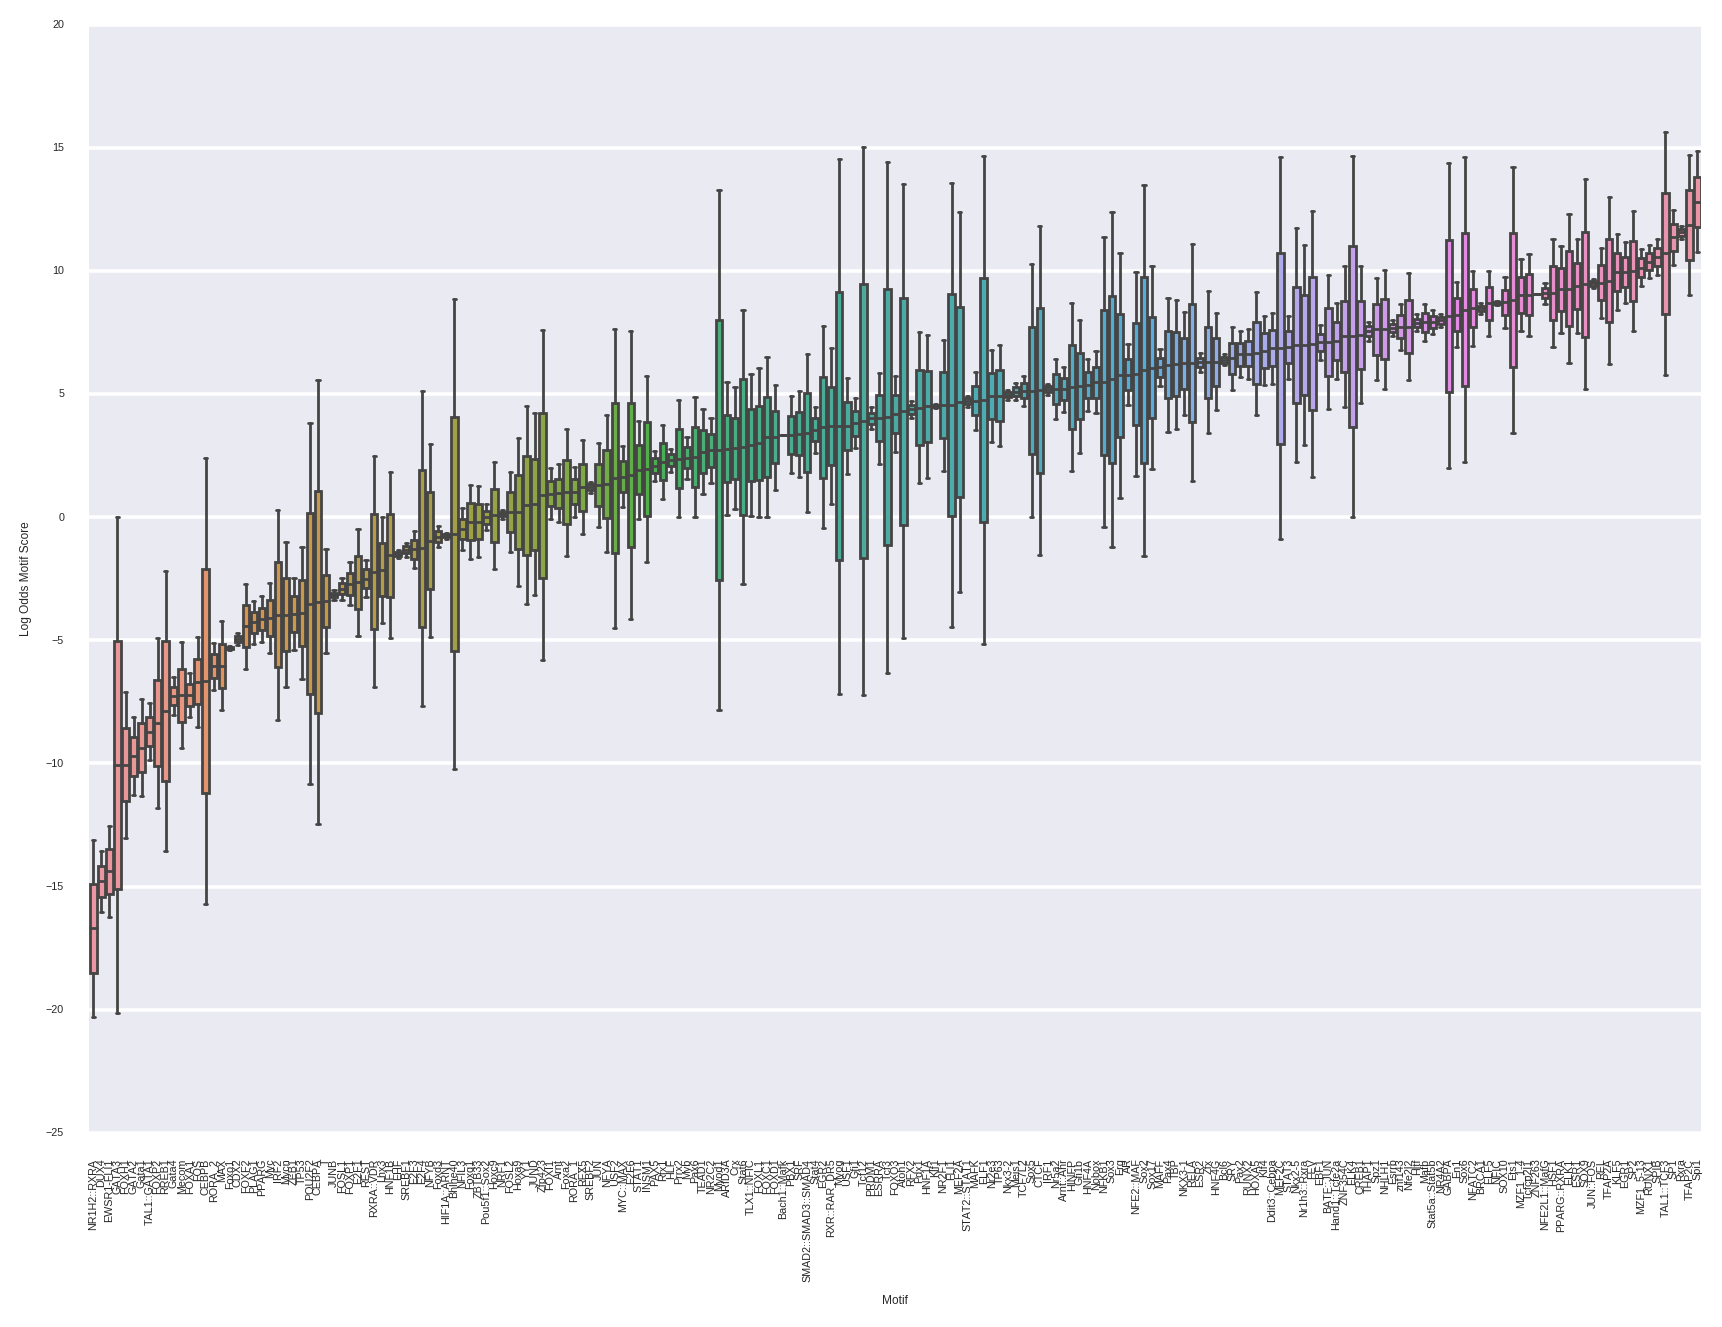

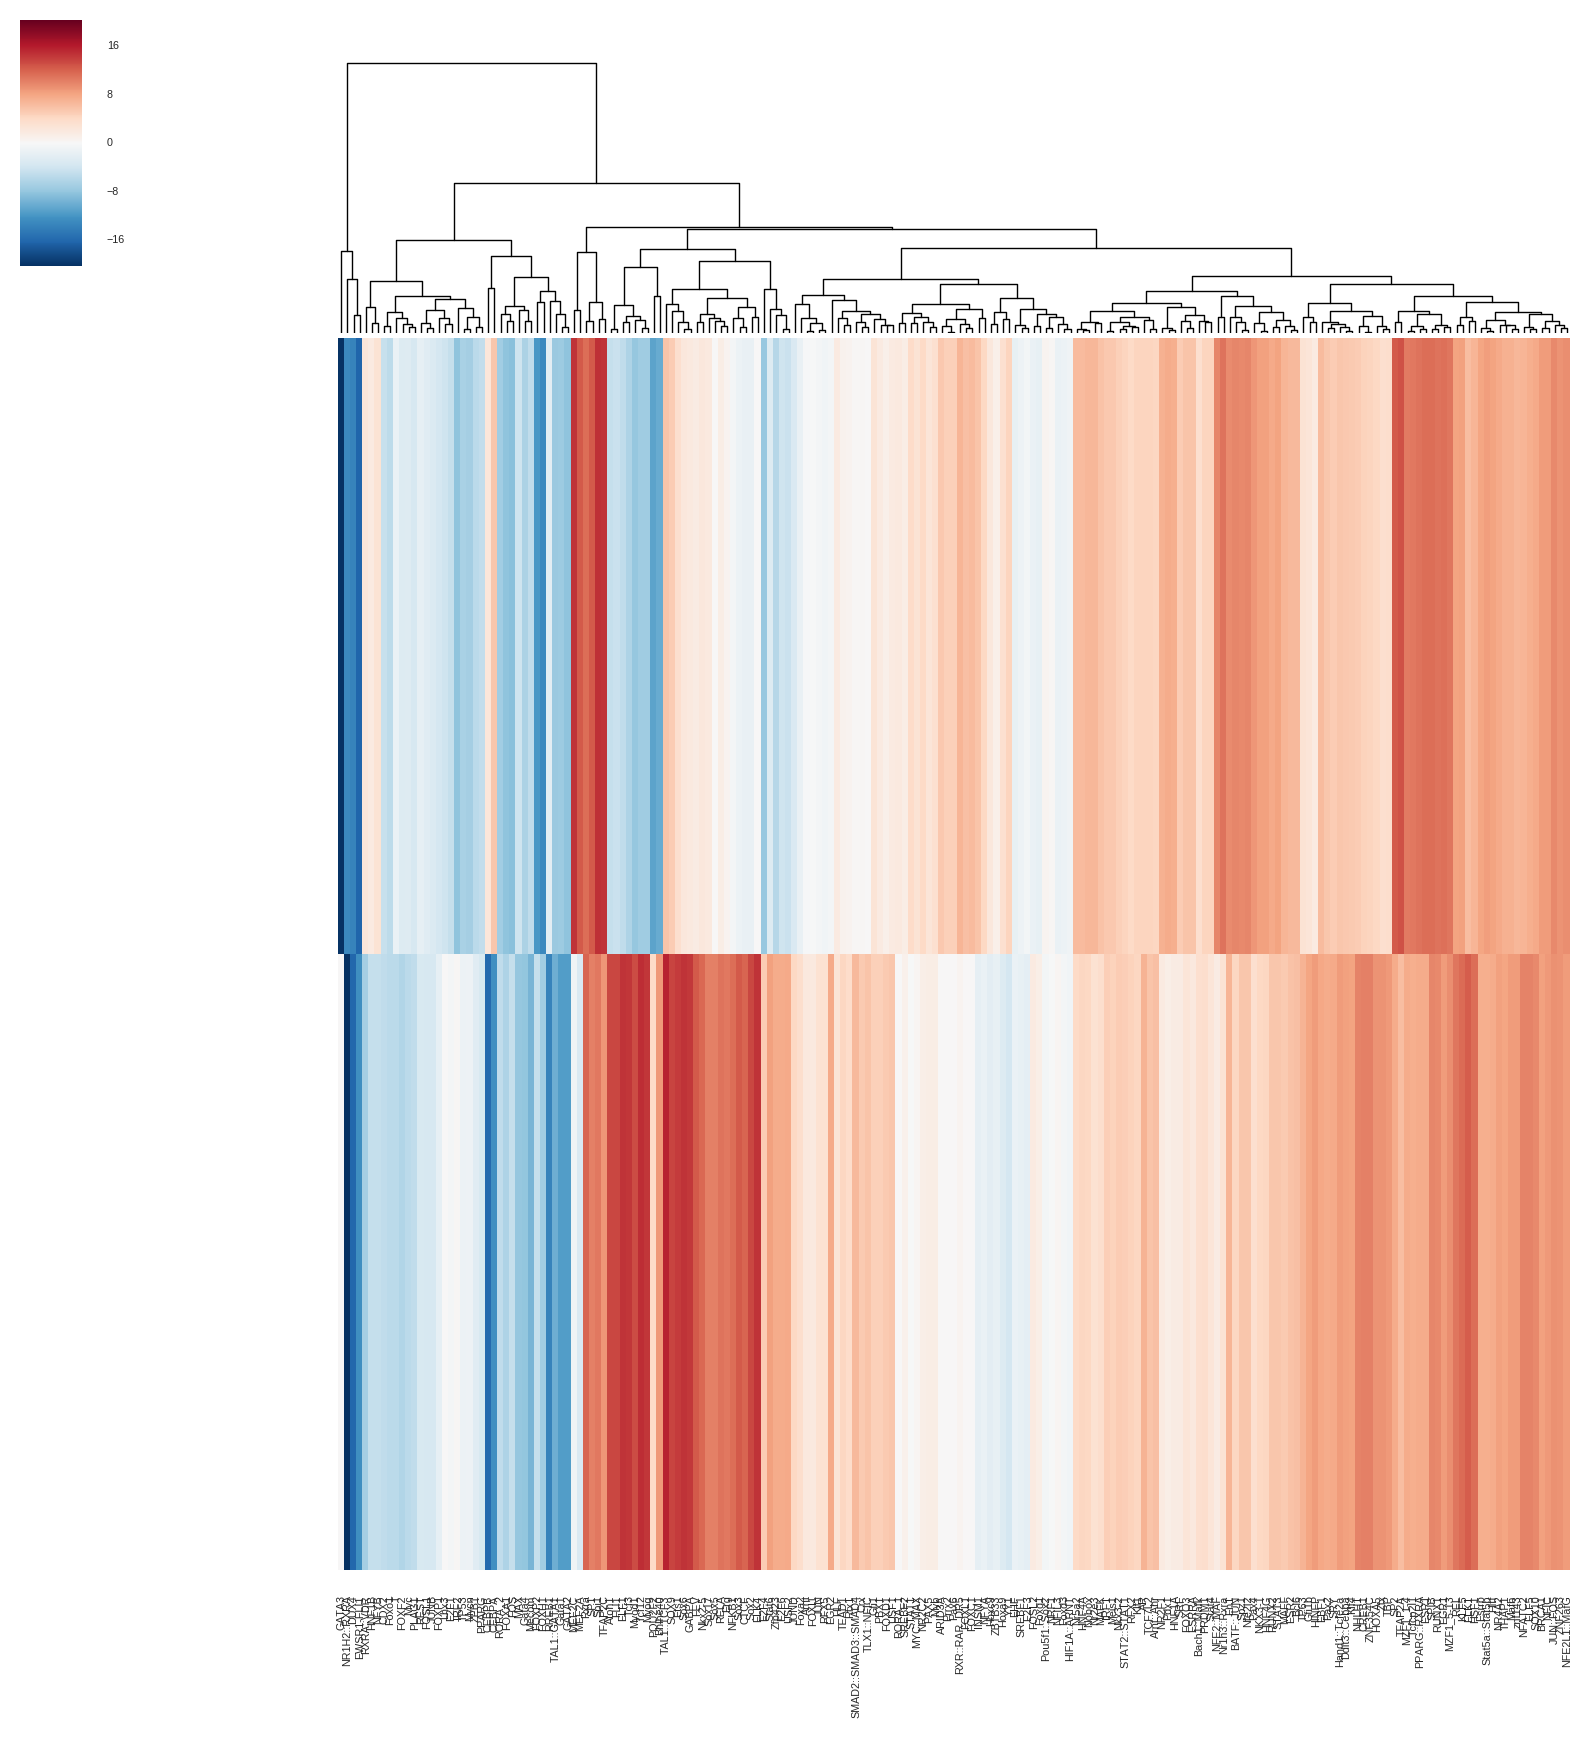

In [22]:
### score motifs for each cluster for each category of peaks ###

### for notx peaks
cg_notx = pickle.load(open('cg_notx.pickle','rb'))
notx_difference_frame['cluster'] = scipy.cluster.hierarchy.fcluster(cg_notx.dendrogram_row.linkage, numRowClusters, criterion="maxclust")

# peaks that look like activators
ids = notx_difference_frame[notx_difference_frame['cluster'] ==4]['ID'].values
scores = merged_motif_frame.ix[ids,:]

# plot distribution of motif scores
sns.set_context('talk', font_scale=0.3)
data_dict = {}
count = 0
sort_list = []
for col in scores.columns[3:]:
    data_dict[col] = scores[col].values
    sort_list.append((col, np.mean(scores[col].values)))
# sort_list = sorted(sort_list,key=lambda x:x[1])
sort_list = sorted(sort_list,key=lambda x:x[1])

order = [x[0] for x in sort_list]
sns.boxplot(pd.DataFrame(data_dict), 
            fliersize = 1.0,linewidth=1.0,
            order = order)
plt.xticks(rotation=90)
plt.xlabel("Motif")
plt.ylabel("Log Odds Motif Score")
plt.show()

sns.clustermap(scores.ix[:,3:],yticklabels=False, xticklabels=True, row_cluster=False)
plt.savefig('activator.pdf')
# for peaks that look like repressors
# ids = notx_difference_frame[notx_difference_frame['cluster'] ==6]['ID'].values
# scores = merged_motif_frame.ix[ids,:]



### for KLA peaks

### for shared peaks
sns.set_context('talk', font_scale=1.0)




## Tag Histograms for Marks of Activity

### Split Peaks and Create Split Peak Files

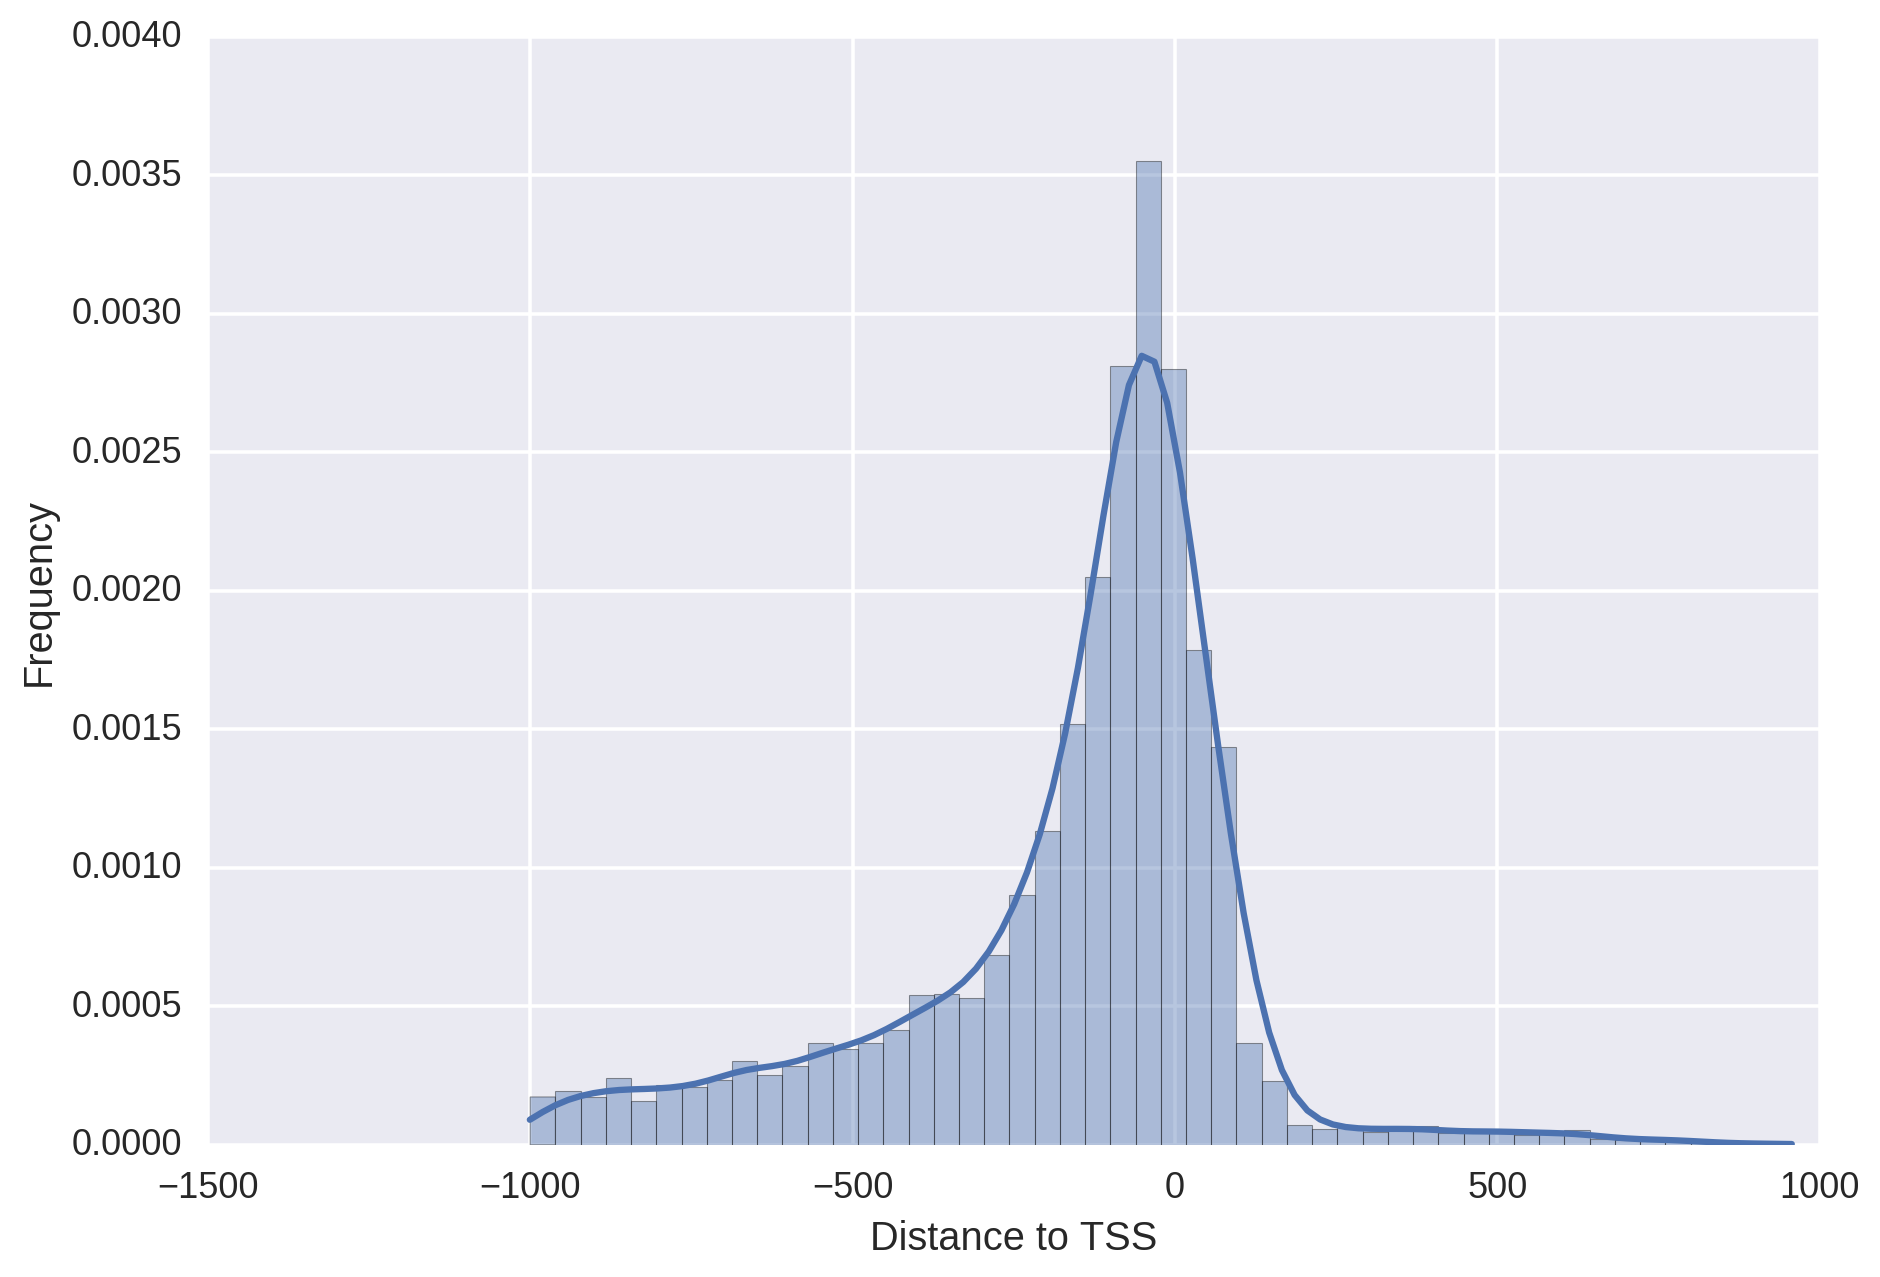

In [23]:
sns.distplot([id_tssDistance_dict[x] for x in [x for x in summary_frame['ID'] if id_annotation_dict[x] == 'promoter-TSS']])
plt.xlabel('Distance to TSS')
plt.ylabel('Frequency')

In [24]:
# shift promoter peaks to TSS
id_tssDistance_dict

outDirectory = '/home/jenhan/analysis/ncor_analysis/scratch/'
! if [ ! -d $outDirectory ]; then mkdir $outDirectory; fi

# for notx only peaks
notx_ids = summary_frame[(summary_frame['ncor_notx'] > 0) & (summary_frame['ncor_kla'] == 0)]['ID'].values
# for KLA only peaks
kla_ids = summary_frame[(summary_frame['ncor_notx'] == 0) & (summary_frame['ncor_kla'] > 0)]['ID'].values
# for shared peaks
shared_ids = summary_frame[(summary_frame['ncor_notx'] > 0) & (summary_frame['ncor_kla'] > 0)]['ID'].values
# for all notx peaks
notxAll_ids = summary_frame[summary_frame['ncor_notx'] > 0]['ID'].values
# for all KLA peaks
klaAll_ids = summary_frame[summary_frame['ncor_kla'] > 0]['ID'].values

### subset into enhancers vs promoters
notx_promoter_ids = [x for x in notx_ids if id_annotation_dict[x] == 'promoter-TSS']
notx_enhancer_ids = [x for x in notx_ids if id_annotation_dict[x] != 'promoter-TSS']

kla_promoter_ids = [x for x in kla_ids if id_annotation_dict[x] == 'promoter-TSS']
kla_enhancer_ids = [x for x in kla_ids if id_annotation_dict[x] != 'promoter-TSS']

shared_promoter_ids = [x for x in shared_ids if id_annotation_dict[x] == 'promoter-TSS']
shared_enhancer_ids = [x for x in shared_ids if id_annotation_dict[x] != 'promoter-TSS']

notxAll_promoter_ids = [x for x in notxAll_ids if id_annotation_dict[x] == 'promoter-TSS']
notxAll_enhancer_ids = [x for x in notxAll_ids if id_annotation_dict[x] != 'promoter-TSS']

klaAll_promoter_ids = [x for x in klaAll_ids if id_annotation_dict[x] == 'promoter-TSS']
klaAll_enhancer_ids = [x for x in klaAll_ids if id_annotation_dict[x] != 'promoter-TSS']

### generate peak files


def genPeakFile(summary_frame, ids, scoreColumn, outpath, id_tssDistance_dict):
    positions = summary_frame.ix[ids,'Position'].values
    starts = []
    ends = []
    chrs = summary_frame.ix[ids,'chr'].values
    scores = summary_frame.ix[ids,scoreColumn].values
    strands = ['+'] * len(ids)
    for i in range(len(positions)):
        x = positions[i]
        tokens = x.split(':')[1].strip().split('-')
        starts.append(int(tokens[0]) - int(id_tssDistance_dict[ids[i]]))
        ends.append(int(tokens[1]) - int(id_tssDistance_dict[ids[i]]))
    out_frame = pd.DataFrame({'#PeakID': ids,
                              'chr': chrs,
                              'start': starts,
                              'end': ends,
                              'strand': strands,
                              'score': scores})
    out_frame = out_frame[['#PeakID', 'chr', 'start', 'end', 'strand', 'score']]
    out_frame.to_csv(outpath, index=False, sep='\t')
    
genPeakFile(summary_frame, notx_promoter_ids, 'ncor_notx', outDirectory + '/notx_promoters_peaks.tsv', id_tssDistance_dict)
# genPeakFile(summary_frame, notx_enhancer_ids, 'ncor_notx', outDirectory + '/notx_enhancers_peaks.tsv', id_tssDistance_dict)

genPeakFile(summary_frame, kla_promoter_ids, 'ncor_kla', outDirectory + '/kla_promoters_peaks.tsv', id_tssDistance_dict)
# genPeakFile(summary_frame, kla_enhancer_ids, 'ncor_kla', outDirectory + '/kla_enhancers_peaks.tsv', id_tssDistance_dict)

genPeakFile(summary_frame, shared_promoter_ids, 'ncor_notx', outDirectory + '/shared_promoters_peaks.tsv', id_tssDistance_dict)
# genPeakFile(summary_frame, shared_enhancer_ids, 'ncor_notx', outDirectory + '/shared_enhancers_peaks.tsv', id_tssDistance_dict)

In [25]:
outDirectory = '/home/jenhan/analysis/ncor_analysis/scratch/'
! if [ ! -d $outDirectory ]; then mkdir $outDirectory; fi

# for notx only peaks
notx_ids = summary_frame[(summary_frame['ncor_notx'] > 0) & (summary_frame['ncor_kla'] == 0)]['ID'].values
# for KLA only peaks
kla_ids = summary_frame[(summary_frame['ncor_notx'] == 0) & (summary_frame['ncor_kla'] > 0)]['ID'].values
# for shared peaks
shared_ids = summary_frame[(summary_frame['ncor_notx'] > 0) & (summary_frame['ncor_kla'] > 0)]['ID'].values
# for all notx peaks
notxAll_ids = summary_frame[summary_frame['ncor_notx'] > 0]['ID'].values
# for all KLA peaks
klaAll_ids = summary_frame[summary_frame['ncor_kla'] > 0]['ID'].values

### subset into enhancers vs promoters
notx_promoter_ids = [x for x in notx_ids if id_annotation_dict[x] == 'promoter-TSS']
notx_enhancer_ids = [x for x in notx_ids if id_annotation_dict[x] != 'promoter-TSS']

kla_promoter_ids = [x for x in kla_ids if id_annotation_dict[x] == 'promoter-TSS']
kla_enhancer_ids = [x for x in kla_ids if id_annotation_dict[x] != 'promoter-TSS']

shared_promoter_ids = [x for x in shared_ids if id_annotation_dict[x] == 'promoter-TSS']
shared_enhancer_ids = [x for x in shared_ids if id_annotation_dict[x] != 'promoter-TSS']

### generate peak files
def genPeakFile(summary_frame, ids, scoreColumn, outpath):
    positions = summary_frame.ix[ids,'Position'].values
    starts = []
    ends = []
    chrs = summary_frame.ix[ids,'chr'].values
    scores = summary_frame.ix[ids,scoreColumn].values
    strands = ['+'] * len(ids)
    for x in positions:
        tokens = x.split(':')[1].strip().split('-')
        starts.append(int(tokens[0]))
        ends.append(int(tokens[1]))
    out_frame = pd.DataFrame({'#PeakID': ids,
                              'chr': chrs,
                              'start': starts,
                              'end': ends,
                              'strand': strands,
                              'score': scores})
    out_frame = out_frame[['#PeakID', 'chr', 'start', 'end', 'strand', 'score']]
    out_frame.to_csv(outpath, index=False, sep='\t')
    
# genPeakFile(summary_frame, notx_promoter_ids, 'ncor_notx', outDirectory + '/notx_promoters_peaks.tsv')
genPeakFile(summary_frame, notx_enhancer_ids, 'ncor_notx', outDirectory + '/notx_enhancers_peaks.tsv')

# genPeakFile(summary_frame, kla_promoter_ids, 'ncor_kla', outDirectory + '/kla_promoters_peaks.tsv')
genPeakFile(summary_frame, kla_enhancer_ids, 'ncor_kla', outDirectory + '/kla_enhancers_peaks.tsv')

# genPeakFile(summary_frame, shared_promoter_ids, 'ncor_notx', outDirectory + '/shared_promoters_peaks.tsv')
genPeakFile(summary_frame, shared_enhancer_ids, 'ncor_notx', outDirectory + '/shared_enhancers_peaks.tsv')



In [26]:
# for every group of peaks
for p in os.listdir(outDirectory):
    if not 'histAnnotated' in p and '.tsv' in p:
        outpath = outDirectory + '/' + p.replace('_peaks.tsv', '_histAnnotated.tsv')
#         !annotatePeaks.pl $outDirectory/$p mm10 -hist 20 -size 2000 -d tag_directories_enhancerMarks/*> $outpath 
        !annotatePeaks.pl $outDirectory/$p mm10 -pc 3 -hist 20 -size 2000 -d /home/jenhan/analysis/ncor_analysis/tag_directories_enhancerMarks/*> $outpath 


	Peak file = /home/jenhan/analysis/ncor_analysis/scratch//kla_lowBin_peaks.tsv
	Genome = mm10
	Organism = mouse
	Maximum count per bp will be set to 3
	-----------------------------------------------------
	Histogram mode activated (bin size = 20 bp)
	-----------------------------------------------------
	Peak Region set to 2000
	Tag Directories:
		/home/jenhan/analysis/ncor_analysis/tag_directories_enhancerMarks/BMDM_NCoR-KO_ChIP_H3K27Ac_KLA-1h_JSS_14-11-04
		/home/jenhan/analysis/ncor_analysis/tag_directories_enhancerMarks/BMDM_NCoR-KO_ChIP_H3K27Ac_KLA-1h_JSS_15-07-14
		/home/jenhan/analysis/ncor_analysis/tag_directories_enhancerMarks/BMDM_NCoR-KO_ChIP_H3K27Ac_Veh_JSS_14-11-04
		/home/jenhan/analysis/ncor_analysis/tag_directories_enhancerMarks/BMDM_NCoR-KO_ChIP_H3K27Ac_Veh_JSS_15-07-14
		/home/jenhan/analysis/ncor_analysis/tag_directories_enhancerMarks/BMDM_NCoR-KO_ChIP_H3K4me1_KLA-6h_Josh_14-09-03
		/home/jenhan/analysis/ncor_analysis/tag_directories_enhancerMarks/BMDM_NCoR-KO_ChIP

In [27]:
plotting_frame = None
first = True
for p in os.listdir(outDirectory):
    if 'histAnnotated' in p:
        annotation = p.split('_')[1]
        peakType = p.split('_')[0]
        factor = p.replace('_histAnnotated.tsv', '')
        data=pd.read_csv(outDirectory + '/' + p, sep='\t')
        columns = [x for x in data.columns.values if 'Coverage' in x]
        columns = [data.columns.values[0]] + columns
        data = data[columns]
        columns = data.columns.values
        columns[0] = 'Position'
        newColumns = []
        for x in columns:
            if '/' in x:
                tokens = x.replace('_ChIP','').replace('Veh','notx').split('/')[-1].split('_')[:-2]
                nc = '_'.join(tokens[:-1]) + '_' + tokens[-1].split('-')[0]
                newColumns.append(nc)
            else:
                newColumns.append(x)
        data.columns = newColumns
        # create data frame for making plots
        unique_cols = sorted(set(data.columns.values[1:]))
        for col in unique_cols:
            
            positions = data['Position'].values
            # average coverage across replicates
            if len(data[col].shape) > 1:
                coverage = np.mean(data[col], axis=1)
            else:
                coverage = data[col]
            # get metadata
            tokens = col.split('_')
            cellType = [tokens[0] ] * len(positions)
            genotype = [tokens[1]] * len(positions)
            signal = [tokens[2]] * len(positions)
            treatment = [tokens[3]] * len(positions)
            annotations = [annotation] * len(positions)
            peakTypes = [peakType] * len(positions)

            current_frame = pd.DataFrame({'Position':positions,
                                         'Coverage': coverage,
                                         'cellType':cellType,
                                         'genotype':genotype,
                                         'signal':signal,
                                         'treatment':treatment,
                                         'annotation':annotations,
                                         'peakType': peakTypes})
            current_frame = current_frame[['Position',
                                         'Coverage',
                                         'cellType',
                                         'genotype',
                                         'signal',
                                         'treatment',
                                         'annotation',
                                         'peakType']]
            # concatenate data frames
            if first == True:
                first = False
                plotting_frame = current_frame
            else:
                plotting_frame = pd.concat([plotting_frame, current_frame])


In [ ]:
row_order = ['H3K4me1', 'H3K4me3', 'H3K27Ac', 'PolII', 'Gro']
g= sns.factorplot(x='Position', 
               y='Coverage', 
               row='signal',
               col='annotation',
               hue='genotype', 
               scale=0.5,  
               size=10,
               margin_titles=True,
               col_order = ['enhancers','promoters'],
               row_order = row_order,
               sharey=False,
               markers='.',
               data = plotting_frame[(plotting_frame['peakType']=='notx') & (plotting_frame['treatment']=='notx')])
g.set_xticklabels(rotation=90)
plt.savefig('notx.pdf')

In [ ]:
g= sns.factorplot(x='Position', 
               y='Coverage', 
               row='signal',
               col='annotation',
               hue='genotype', 
               scale=0.5,  
               size=10,
               margin_titles=True,
               sharey=False,
               markers='.',
               col_order = ['enhancers','promoters'],
               row_order = row_order,
               data = plotting_frame[(plotting_frame['peakType']=='kla') & (plotting_frame['treatment']=='KLA')])
g.set_xticklabels(rotation=90)
plt.savefig('kla.pdf')

In [ ]:
shared_plotting_frame = plotting_frame[plotting_frame['peakType']=='shared']
shared_plotting_frame['genotype-treatment'] = shared_plotting_frame['genotype'] + '_' + shared_plotting_frame['treatment']

g= sns.factorplot(x='Position', 
               y='Coverage', 
               row='signal',
               col='annotation',
               hue='genotype-treatment', 
               scale=0.5,  
               size=10,
               margin_titles=True,
               sharey=False,
               markers='.',
               col_order = ['enhancers','promoters'],
               row_order = row_order,
               data = shared_plotting_frame)
g.set_xticklabels(rotation=90)
plt.savefig('shared.pdf')



In [ ]:
g= sns.factorplot(x='Position', 
               y='Coverage', 
               row='signal',
               col='annotation',
               hue='genotype', 
               scale=0.5,  
               size=10,
               margin_titles=True,
               sharey=False,
               markers='.',
               col_order = ['enhancers','promoters'],
               row_order = row_order,
               data = plotting_frame[(plotting_frame['peakType']=='shared') & (plotting_frame['treatment']=='notx')])
g.set_xticklabels(rotation=90)
plt.savefig('shared_notx.pdf')
g= sns.factorplot(x='Position', 
               y='Coverage', 
               row='signal',
               col='annotation',
               hue='genotype', 
               scale=0.5,  
               size=10,
               margin_titles=True,
               sharey=False,
               markers='.',
               col_order = ['enhancers','promoters'],
               row_order = row_order,
               data = plotting_frame[(plotting_frame['peakType']=='shared') & (plotting_frame['treatment']=='KLA')])
g.set_xticklabels(rotation=90)
plt.savefig('shared_kla.pdf')

### Create Variant for no ncor, low ncor, high ncor

In [32]:
# read in RPKM values
rpkm_frame = pd.read_csv("rpkm.tsv",sep="\t")
columns = rpkm_frame.columns.values
columns[0] = "refseq"
for i in range(len(columns)):
    if "FPKM" in columns[i]:
        columns[i] = columns[i].split("/")[-1].split()[0]
rpkm_frame.columns = columns    
rpkm_frame['gene'] = [x.split("|")[0] for x in rpkm_frame['Annotation/Divergence']]
columns = list(rpkm_frame.columns.values)
columns = columns[:-1]
columns.insert(1,'gene')
rpkm_frame = rpkm_frame[columns]
rpkm_frame.columns = [
'refseq',
'gene',
'chr',
'start',
'end',
'strand',
'Length',
'Copies',
'Annotation/Divergence',
'NCoR_KO_KLA',
'NCoR_KO_KLA',
'NCoR_KO_KLA',
'NCoR_KO_notx',
'NCoR_KO_notx',
'NCoR_KO_notx',
'NCoR_WT_KLA-6h',
'NCoR_WT_KLA-6h',
'NCoR_WT_KLA-6h',
'NCoR_WT_notx-6h',
'NCoR_WT_notx-6h',
'NCoR_WT_notx-6h'
]
filtered_rpkm_frame =rpkm_frame[[
                                'gene',
                                'chr',
                                'start',
                                'end',
                                'strand']]
# annotate peaks works from peak center, which is now the start of the gene
filtered_rpkm_frame.loc[filtered_rpkm_frame['strand']=='+',
                        'end'] = filtered_rpkm_frame.loc[filtered_rpkm_frame['strand']=='+','start'].values + 1
filtered_rpkm_frame.loc[filtered_rpkm_frame['strand']=='+',
                        'start'] = filtered_rpkm_frame.loc[filtered_rpkm_frame['strand']=='+','start'].values -1

filtered_rpkm_frame.loc[filtered_rpkm_frame['strand']=='-',
                        'end'] = filtered_rpkm_frame.loc[filtered_rpkm_frame['strand']=='-','end'].values + 1
filtered_rpkm_frame.loc[filtered_rpkm_frame['strand']=='-',
                        'start'] = filtered_rpkm_frame.loc[filtered_rpkm_frame['strand']=='-','end'].values - 1



for col in ['NCoR_KO_KLA','NCoR_KO_notx','NCoR_WT_KLA-6h','NCoR_WT_notx-6h']:
    filtered_rpkm_frame[col] = np.mean(rpkm_frame[col], axis=1)
filtered_rpkm_frame = filtered_rpkm_frame[filtered_rpkm_frame.ix[:,-4:].sum(axis=1) > 1]
filtered_rpkm_frame.to_csv('rpkm_peaks.tsv',sep='\t', index=False)




/bioinformatics/software/anaconda3/lib/python3.4/site-packages/pandas/core/indexing.py:385: SettingWithCopyWarning: A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index,col_indexer] = value instead
  self.obj[item] = s


In [33]:
!annotatePeaks.pl /home/jenhan/analysis/ncor_analysis/rpkm_peaks.tsv mm10 -size 1000 -d tag_directories_chip/Sample_Coro2AWT_BMDM_ChIP_NCoR_KLA_1h_JSS_15_02_02/ tag_directories_chip/Sample_NCoRWT_BMDM_NCoR_KLA_1h_JSS_14_11_04 tag_directories_chip/Sample_Coro2AWT_BMDM_ChIP_NCoR_NoTx_JSS_15_02_02 tag_directories_chip/Sample_NCoRWT_BMDM_NCoR_NoTx_JSS_14_11_04 > rpkm_annotated_peaks.tsv


	Peak file = /home/jenhan/analysis/ncor_analysis/rpkm_peaks.tsv
	Genome = mm10
	Organism = mouse
	Peak Region set to 1000
	Tag Directories:
		tag_directories_chip/Sample_Coro2AWT_BMDM_ChIP_NCoR_KLA_1h_JSS_15_02_02/
		tag_directories_chip/Sample_NCoRWT_BMDM_NCoR_KLA_1h_JSS_14_11_04
		tag_directories_chip/Sample_Coro2AWT_BMDM_ChIP_NCoR_NoTx_JSS_15_02_02
		tag_directories_chip/Sample_NCoRWT_BMDM_NCoR_NoTx_JSS_14_11_04
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 12268
		Duplicated Peak IDs: 0

	Peak File Statistics:
		Total Peaks: 12268
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Resizing peaks...
	Reading Positions...
	-----------------------
	Finding Closest TSS...
	Annotating:.....................
		Annotation	Number of peaks	Total size (bp

In [34]:
annotated_peak_frame = pd.read_csv('rpkm_annotated_peaks.tsv', sep='\t')
columns = annotated_peak_frame.columns.values
columns[0] = 'PeakID'

annotated_peak_frame.columns = columns

annotated_peak_frame['NCoR_KLA'] = np.mean(annotated_peak_frame.ix[:,[-4,-3]], axis=1)
annotated_peak_frame['NCoR_notx'] = np.mean(annotated_peak_frame.ix[:,[-2,-1]], axis=1)

annotated_peak_frame = annotated_peak_frame[['PeakID', 'Chr', 'Start', 'End', 'Strand', 'NCoR_notx', 'NCoR_KLA']]


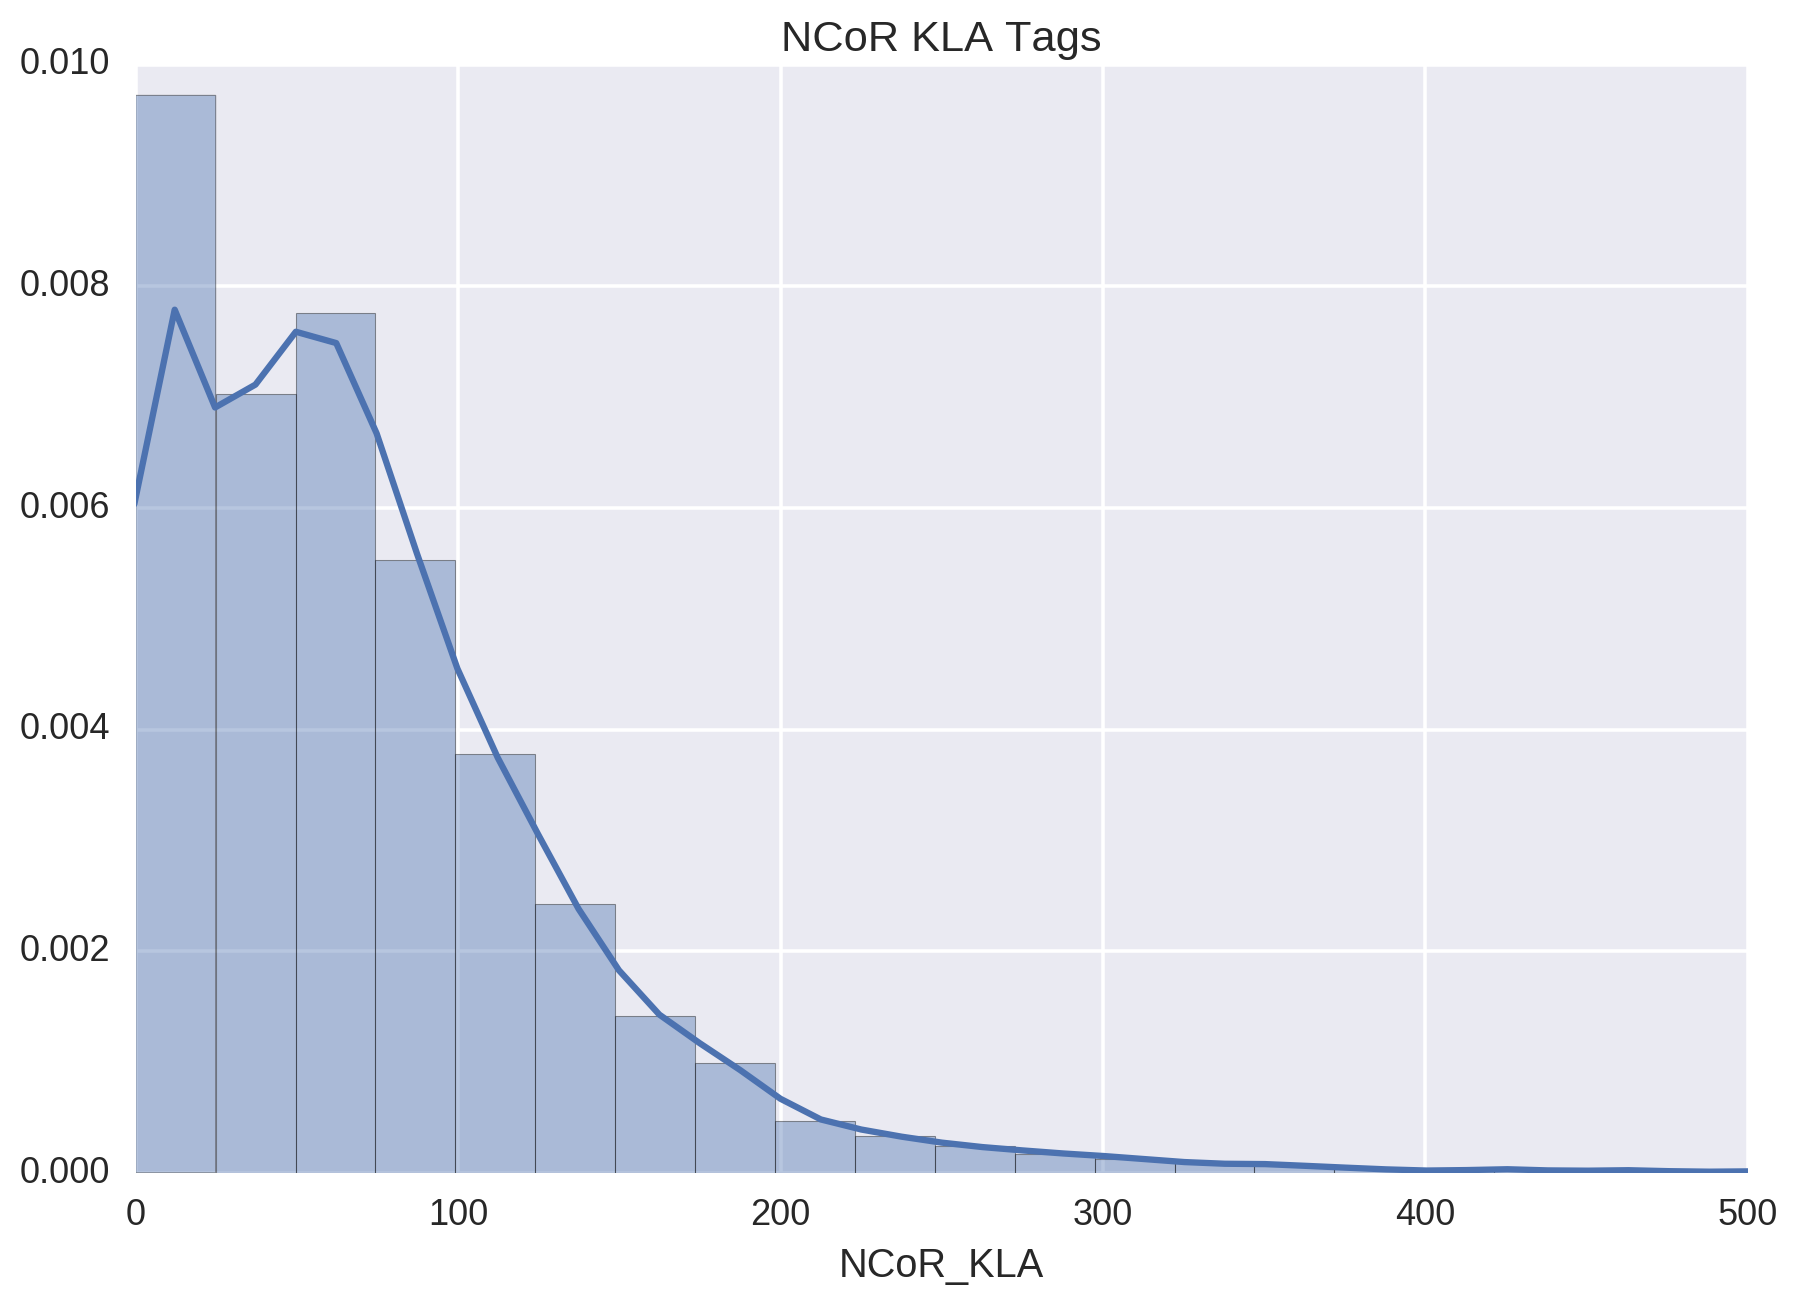

(0, 500)

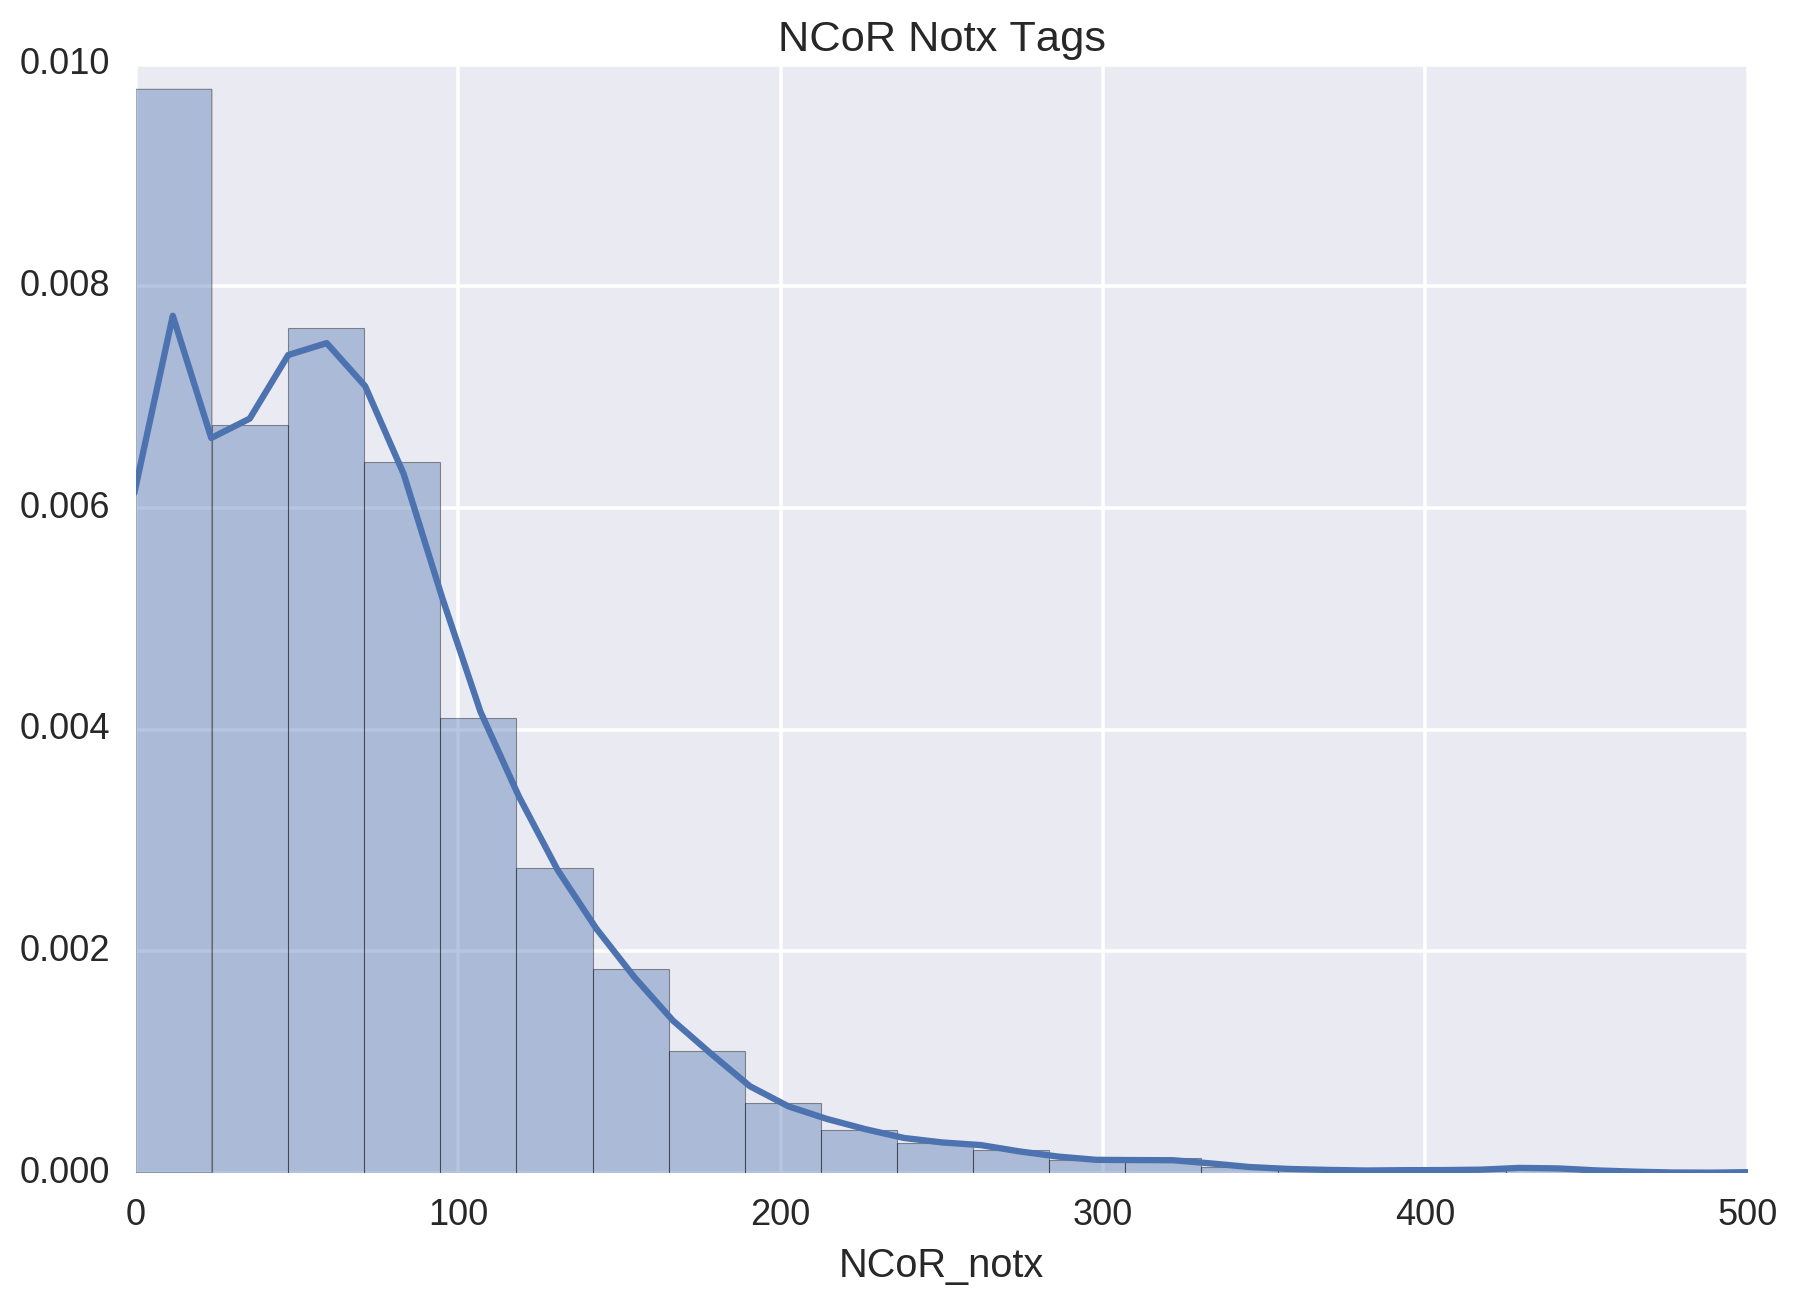

In [35]:
sns.distplot(annotated_peak_frame['NCoR_KLA'])
plt.title('NCoR KLA Tags')
plt.xlim([0,500])
plt.show()
sns.distplot(annotated_peak_frame['NCoR_notx'])
plt.title('NCoR Notx Tags')
plt.xlim([0,500])

In [36]:
notx_threshold = np.percentile(annotated_peak_frame['NCoR_notx'], 50)
kla_threshold = np.percentile(annotated_peak_frame['NCoR_KLA'], 50)

notx_none_peaks = annotated_peak_frame[annotated_peak_frame['NCoR_notx'] == 0]
notx_none_peaks.to_csv('./scratch/notx_noneBin_peaks.tsv',sep='\t', index=False)
notx_low_peaks = annotated_peak_frame[annotated_peak_frame['NCoR_notx'] <= notx_threshold]
notx_low_peaks.to_csv('./scratch/notx_lowBin_peaks.tsv',sep='\t', index=False)                                                 
notx_high_peaks = annotated_peak_frame[annotated_peak_frame['NCoR_notx'] > notx_threshold]
notx_high_peaks.to_csv('./scratch/notx_highBin_peaks.tsv',sep='\t', index=False)  

kla_none_peaks = annotated_peak_frame[annotated_peak_frame['NCoR_KLA'] == 0]
kla_none_peaks.to_csv('./scratch/kla_noneBin_peaks.tsv',sep='\t', index=False)
kla_low_peaks = annotated_peak_frame[annotated_peak_frame['NCoR_KLA'] <= kla_threshold]
kla_low_peaks.to_csv('./scratch/kla_lowBin_peaks.tsv',sep='\t', index=False)                                                 
kla_high_peaks = annotated_peak_frame[annotated_peak_frame['NCoR_KLA'] > kla_threshold]
kla_high_peaks.to_csv('./scratch/kla_highBin_peaks.tsv',sep='\t', index=False)                                                                 

In [37]:
outDirectory = '/home/jenhan/analysis/ncor_analysis/scratch/'
# for every group of peaks
for p in os.listdir(outDirectory):
    if not 'histAnnotated' in p and 'Bin' in p:
        outpath = outDirectory + '/' + p.replace('_peaks.tsv', '_histAnnotated.tsv')
        print(p, outpath)
#         !annotatePeaks.pl $outDirectory/$p mm10 -hist 20 -size 2000 -d tag_directories_enhancerMarks/*> $outpath 
        !annotatePeaks.pl $outDirectory/$p mm10 -pc 3 -hist 20 -size 2000 -d /home/jenhan/analysis/ncor_analysis/tag_directories_enhancerMarks/*> $outpath 





kla_lowBin_peaks.tsv /home/jenhan/analysis/ncor_analysis/scratch//kla_lowBin_histAnnotated.tsv

	Peak file = /home/jenhan/analysis/ncor_analysis/scratch//kla_lowBin_peaks.tsv
	Genome = mm10
	Organism = mouse
	Maximum count per bp will be set to 3
	-----------------------------------------------------
	Histogram mode activated (bin size = 20 bp)
	-----------------------------------------------------
	Peak Region set to 2000
	Tag Directories:
		/home/jenhan/analysis/ncor_analysis/tag_directories_enhancerMarks/BMDM_NCoR-KO_ChIP_H3K27Ac_KLA-1h_JSS_14-11-04
		/home/jenhan/analysis/ncor_analysis/tag_directories_enhancerMarks/BMDM_NCoR-KO_ChIP_H3K27Ac_KLA-1h_JSS_15-07-14
		/home/jenhan/analysis/ncor_analysis/tag_directories_enhancerMarks/BMDM_NCoR-KO_ChIP_H3K27Ac_Veh_JSS_14-11-04
		/home/jenhan/analysis/ncor_analysis/tag_directories_enhancerMarks/BMDM_NCoR-KO_ChIP_H3K27Ac_Veh_JSS_15-07-14
		/home/jenhan/analysis/ncor_analysis/tag_directories_enhancerMarks/BMDM_NCoR-KO_ChIP_H3K4me1_KLA-6h_Josh

In [38]:
plotting_frame = None
first = True
for p in os.listdir(outDirectory):
    if 'histAnnotated' in p and 'Bin' in p:
        annotation = p.split('_')[1]
        peakType = p.split('_')[0]

        data=pd.read_csv(outDirectory + '/' + p, sep='\t')
        columns = [x for x in data.columns.values if 'Coverage' in x]
        columns = [data.columns.values[0]] + columns
        data = data[columns]
        columns = data.columns.values
        columns[0] = 'Position'
        newColumns = []
        for x in columns:
            if '/' in x:
                tokens = x.replace('_ChIP','').replace('Veh','notx').split('/')[-1].split('_')[:-2]
                nc = '_'.join(tokens[:-1]) + '_' + tokens[-1].split('-')[0]
                newColumns.append(nc)
            else:
                newColumns.append(x)
        data.columns = newColumns
        # create data frame for making plots
        unique_cols = sorted(set(data.columns.values[1:]))
        for col in unique_cols:
            
            positions = data['Position'].values
            # average coverage across replicates
            if len(data[col].shape) > 1:
                coverage = np.mean(data[col], axis=1)
            else:
                coverage = data[col]
            # get metadata
            tokens = col.split('_')
            cellType = [tokens[0] ] * len(positions)
            genotype = [tokens[1]] * len(positions)
            signal = [tokens[2]] * len(positions)
            treatment = [tokens[3]] * len(positions)
            annotations = [annotation] * len(positions)
            peakTypes = [peakType] * len(positions)

            current_frame = pd.DataFrame({'Position':positions,
                                         'Coverage': coverage,
                                         'cellType':cellType,
                                         'genotype':genotype,
                                         'signal':signal,
                                         'treatment':treatment,
                                         'annotation':annotations,
                                         'peakType': peakTypes})
            current_frame = current_frame[['Position',
                                         'Coverage',
                                         'cellType',
                                         'genotype',
                                         'signal',
                                         'treatment',
                                         'annotation',
                                         'peakType']]
            # concatenate data frames
            if first == True:
                first = False
                plotting_frame = current_frame
            else:
                plotting_frame = pd.concat([plotting_frame, current_frame])

In [ ]:
g= sns.factorplot(x='Position', 
               y='Coverage', 
               row='signal',
               col='annotation',
               hue='genotype', 
               scale=0.5,  
               size=12,
               margin_titles=True,
               sharey=False,
               markers='.',
               col_order = ['noneBin','lowBin', 'highBin'],
               row_order = row_order,
               data = plotting_frame[(plotting_frame['peakType']=='notx') & (plotting_frame['treatment']=='notx')])
g.set_xticklabels(rotation=90)

plt.savefig('notx_ncorBinned.pdf')

g= sns.factorplot(x='Position', 
               y='Coverage', 
               row='signal',
               col='annotation',
               hue='genotype', 
               scale=0.5,  
               size=12,
               margin_titles=True,
               sharey=False,
               markers='.',
               col_order = ['noneBin','lowBin', 'highBin'],
               row_order = row_order,
               data = plotting_frame[(plotting_frame['peakType']=='kla') & (plotting_frame['treatment']=='KLA')])
g.set_xticklabels(rotation=90)
plt.savefig('kla_ncorBinned.pdf')

In [ ]:
g= sns.factorplot(x='Position', 
               y='Coverage', 
               row='signal',
               col='annotation',
               hue='genotype', 
               scale=0.5,  
               size=12,
               margin_titles=True,
               sharey=True,
               markers='.',
               col_order = ['noneBin','lowBin', 'highBin'],
               row_order = row_order,
               data = plotting_frame[(plotting_frame['peakType']=='notx') & (plotting_frame['treatment']=='notx')])
g.set_xticklabels(rotation=90)

plt.savefig('notx_ncorBinned_sharey.pdf')

g= sns.factorplot(x='Position', 
               y='Coverage', 
               row='signal',
               col='annotation',
               hue='genotype', 
               scale=0.5,  
               size=12,
               margin_titles=True,
               sharey=True,
               markers='.',
               col_order = ['noneBin','lowBin', 'highBin'],
               row_order = row_order,
               data = plotting_frame[(plotting_frame['peakType']=='kla') & (plotting_frame['treatment']=='KLA')])
g.set_xticklabels(rotation=90)
plt.savefig('kla_ncorBinned_sharey.pdf')

## LXR and PPary Analysis

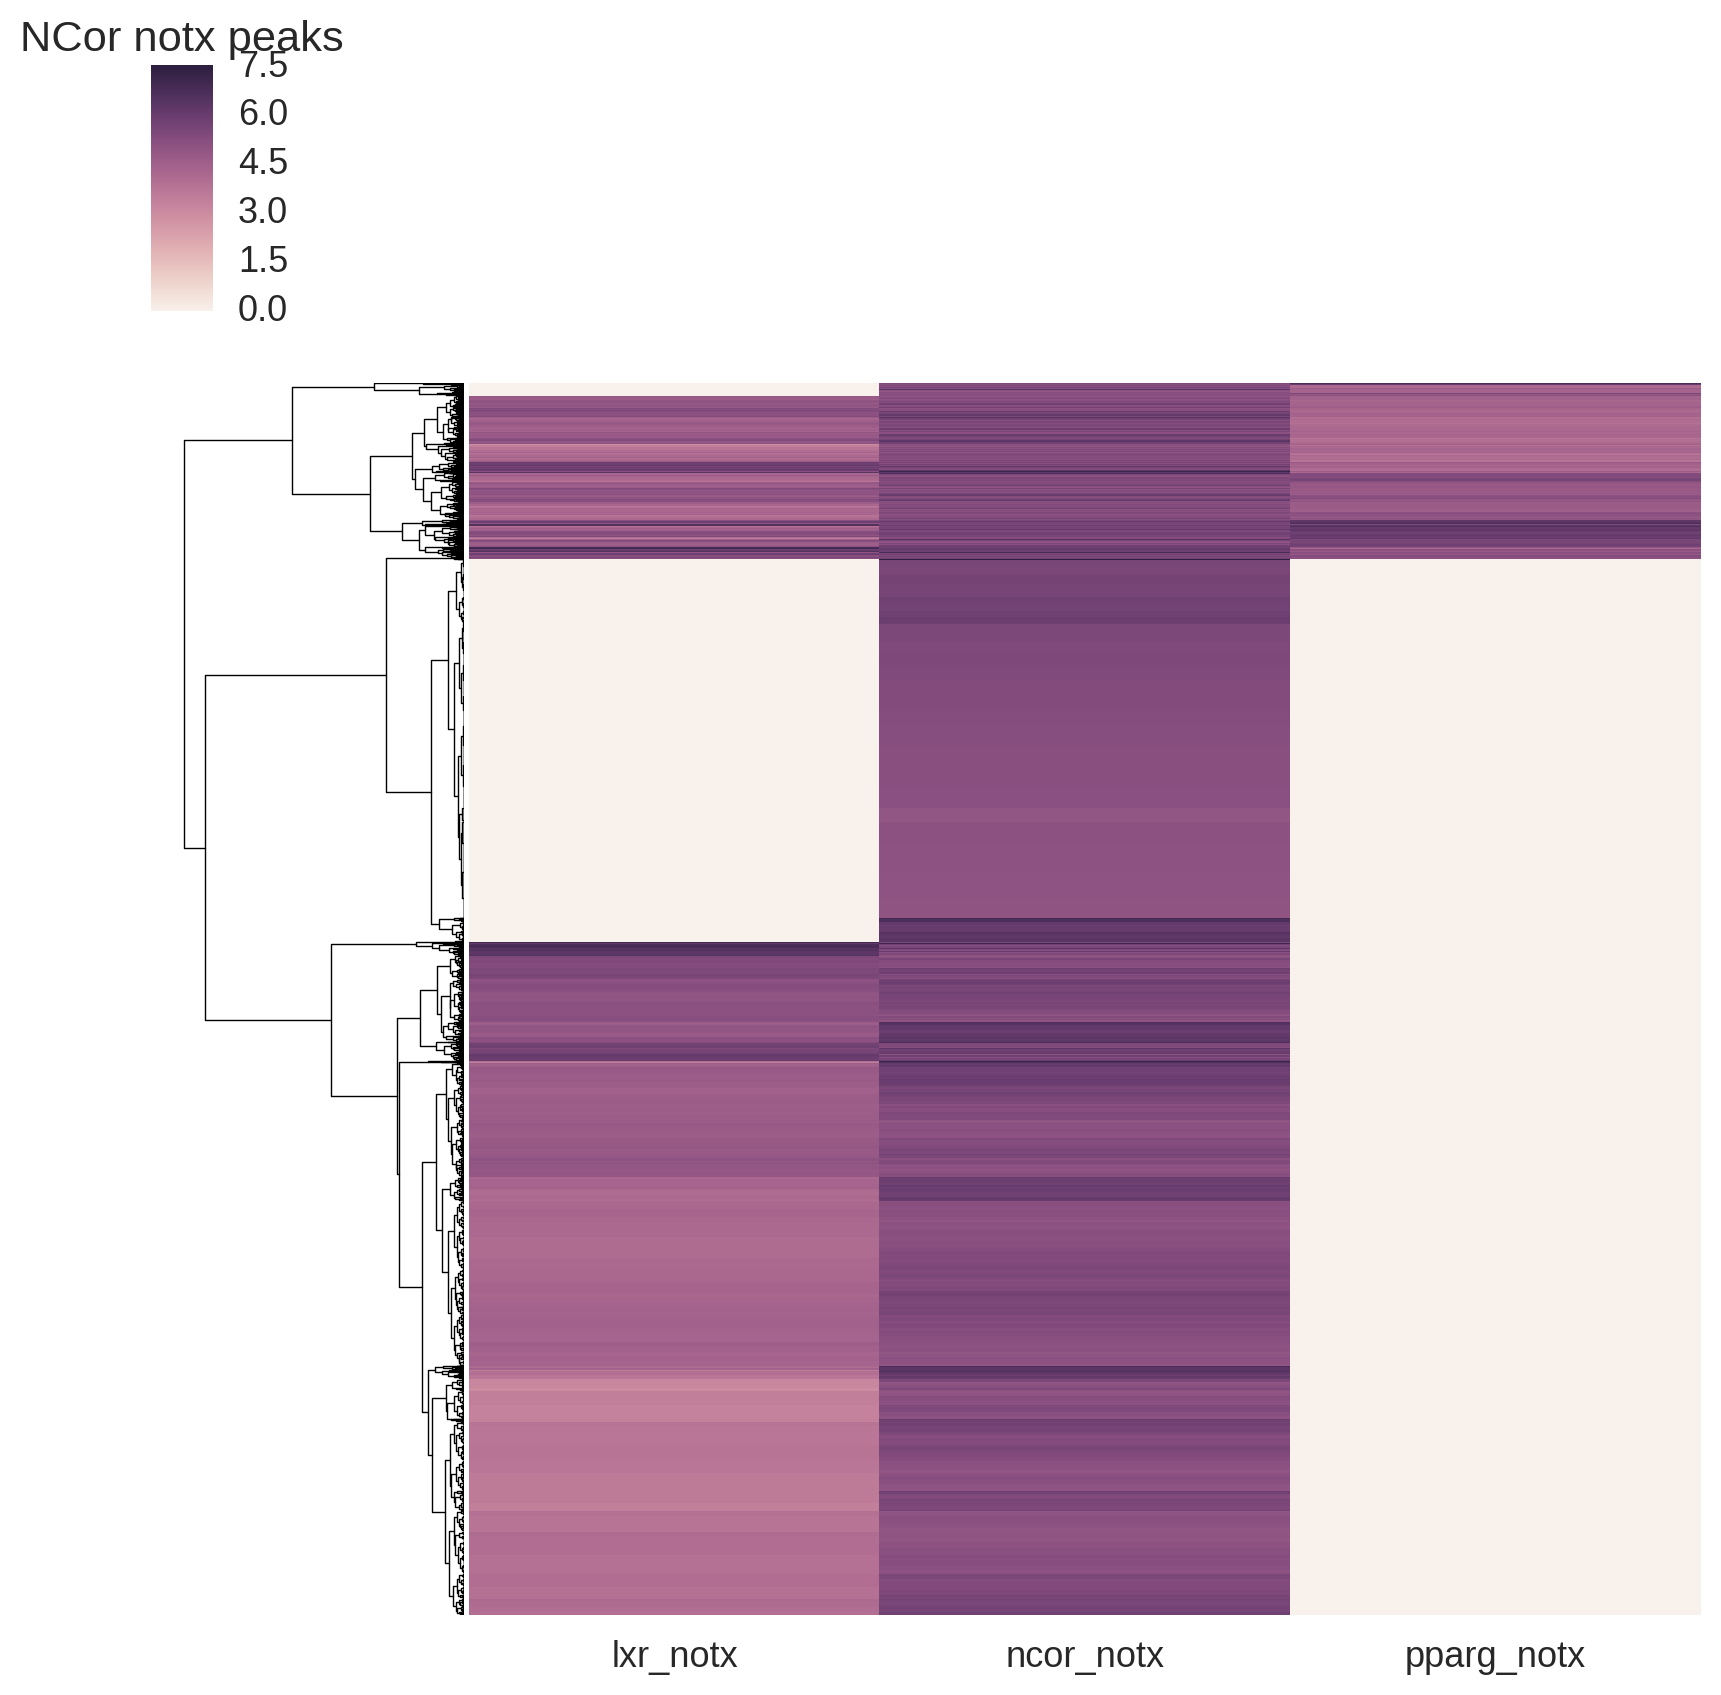

In [41]:
data = summary_frame[['lxr_notx', 'ncor_notx','pparg_notx']]
data = data[data['ncor_notx'] > 0]
data = data[data.sum(axis=1) > 0]

sns.clustermap(np.log2(data+1), col_cluster=False, yticklabels=False)
plt.title('NCor notx peaks')

In [42]:
# separation=70

# # for ncor only
# ncor_ids = summary_frame[(summary_frame['ncor_notx'] > 0) 
#                          & (summary_frame['lxr_notx'] == 0) 
#                          & (summary_frame['pparg_notx'] == 0)]['ID'].values

# sns.clustermap(difference_frame.ix[ncor_ids,-3:],
#               col_cluster=False,
#               yticklabels=False,
#               cmap=sns.diverging_palette(265, 10, s=90, l=40, sep=separation, as_cmap=True))
# plt.title('NCoR only')
# plt.show()

# # for ncor and lxr
# ncor_lxr_ids = summary_frame[(summary_frame['ncor_notx'] > 0) 
#                          & (summary_frame['lxr_notx'] > 0) 
#                          & (summary_frame['pparg_notx'] == 0)]['ID'].values
# sns.clustermap(difference_frame.ix[ncor_lxr_ids,-3:],
#               col_cluster=False,
#               yticklabels=False,
#               cmap=sns.diverging_palette(265, 10, s=90, l=40, sep=separation, as_cmap=True))
# plt.title('NCoR and LXR')
# plt.show()

# # for ncor, lxr, and pparg only
# ncor_lxr_pparg_ids = summary_frame[(summary_frame['ncor_notx'] > 0) 
#                          & (summary_frame['lxr_notx'] > 0) 
#                          & (summary_frame['pparg_notx'] > 0)]['ID'].values
# sns.clustermap(difference_frame.ix[ncor_lxr_pparg_ids,-3:],
#               col_cluster=False,
#               yticklabels=False,
#               cmap=sns.diverging_palette(265, 10, s=90, l=40, sep=separation, as_cmap=True))
# plt.title('NCoR, LXR, and PParg')
# plt.show()


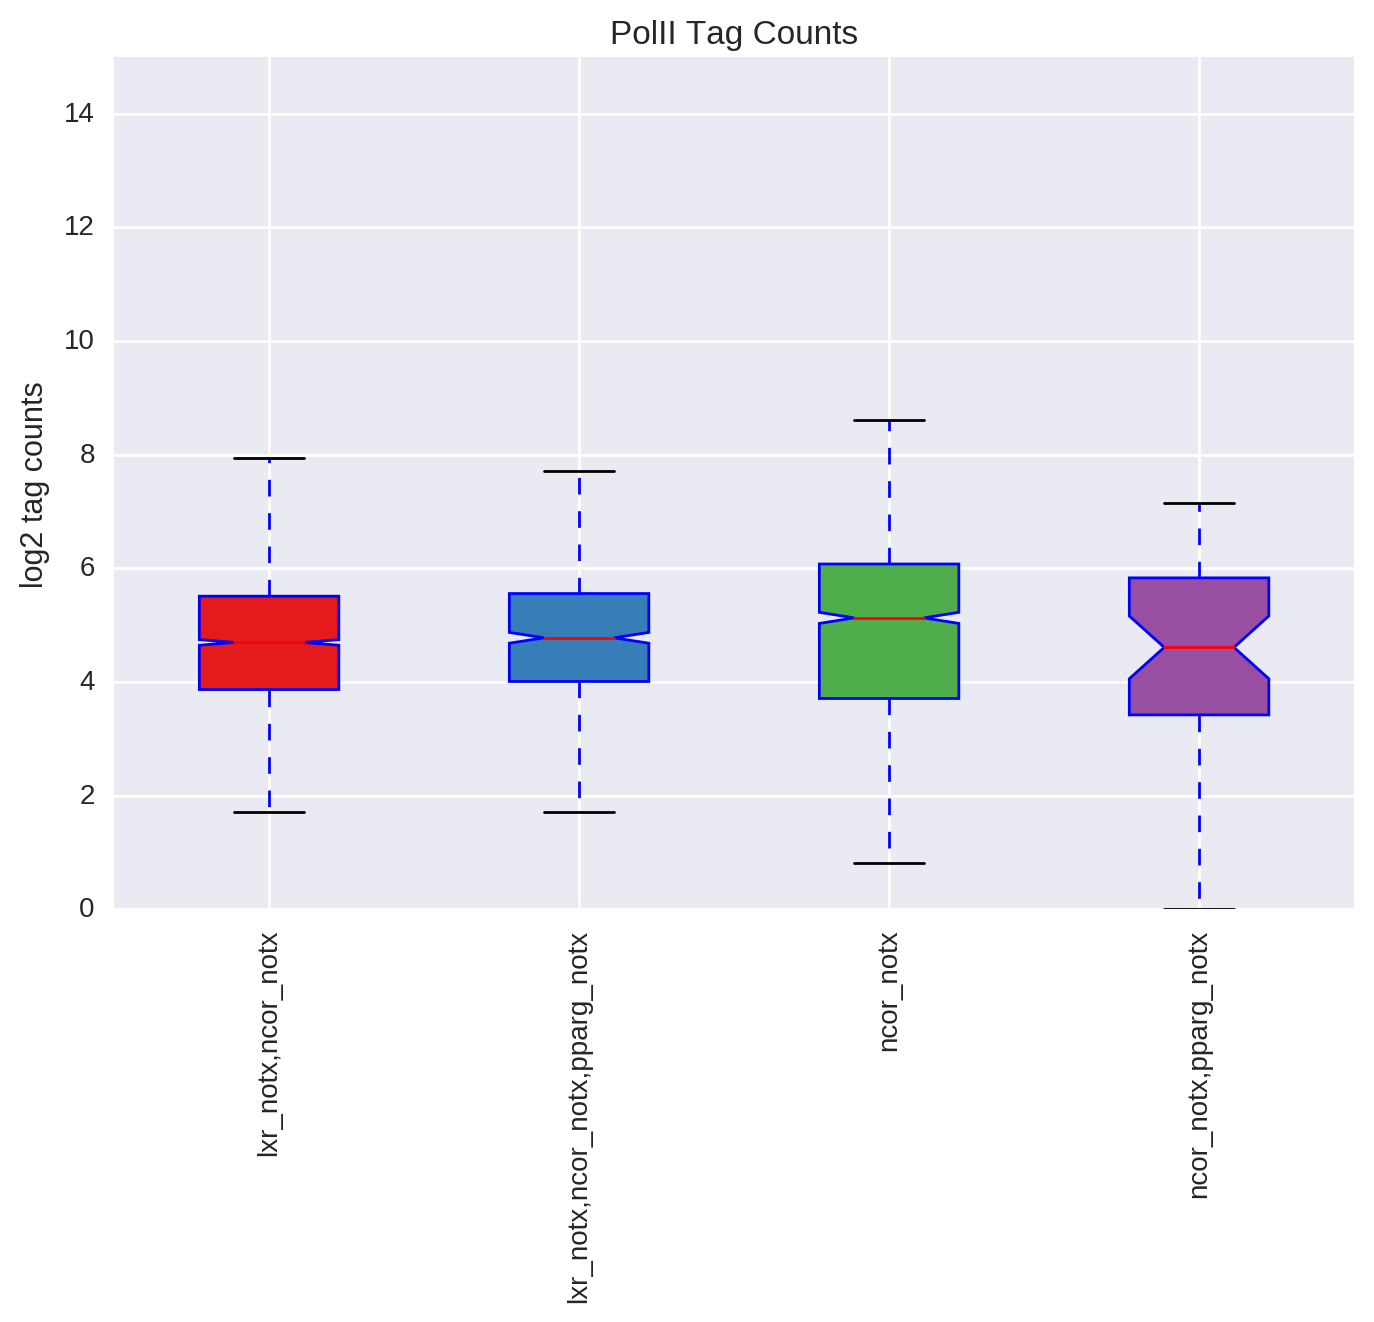

lxr_notx,ncor_notx | lxr_notx,ncor_notx,pparg_notx : 0.244876078753
lxr_notx,ncor_notx | ncor_notx : 7.57518243656e-05
lxr_notx,ncor_notx | ncor_notx,pparg_notx : 0.516145503733
lxr_notx,ncor_notx,pparg_notx | ncor_notx : 0.100713632394
lxr_notx,ncor_notx,pparg_notx | ncor_notx,pparg_notx : 0.331665426089
ncor_notx | ncor_notx,pparg_notx : 0.191095278276


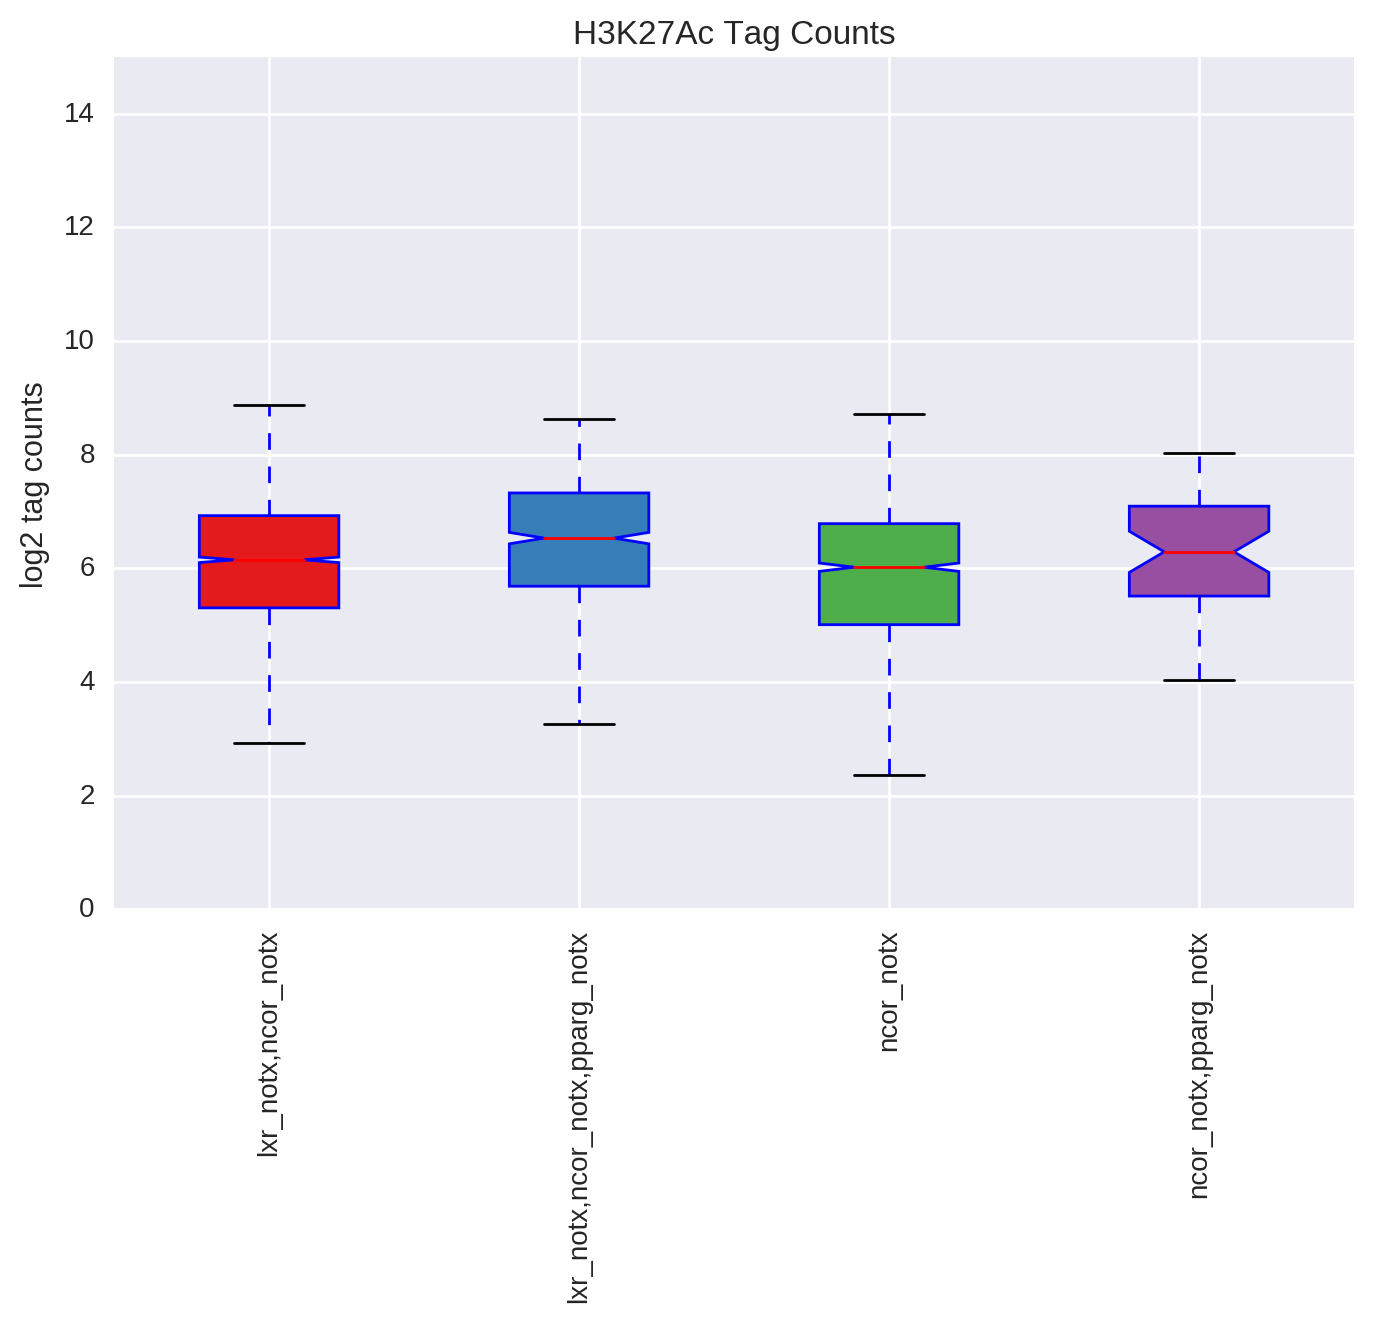

lxr_notx,ncor_notx | lxr_notx,ncor_notx,pparg_notx : 2.55054809011e-12
lxr_notx,ncor_notx | ncor_notx : 7.1699482446e-09
lxr_notx,ncor_notx | ncor_notx,pparg_notx : 0.436769513617
lxr_notx,ncor_notx,pparg_notx | ncor_notx : 3.69051978939e-23
lxr_notx,ncor_notx,pparg_notx | ncor_notx,pparg_notx : 0.188768204067
ncor_notx | ncor_notx,pparg_notx : 0.0568975527537


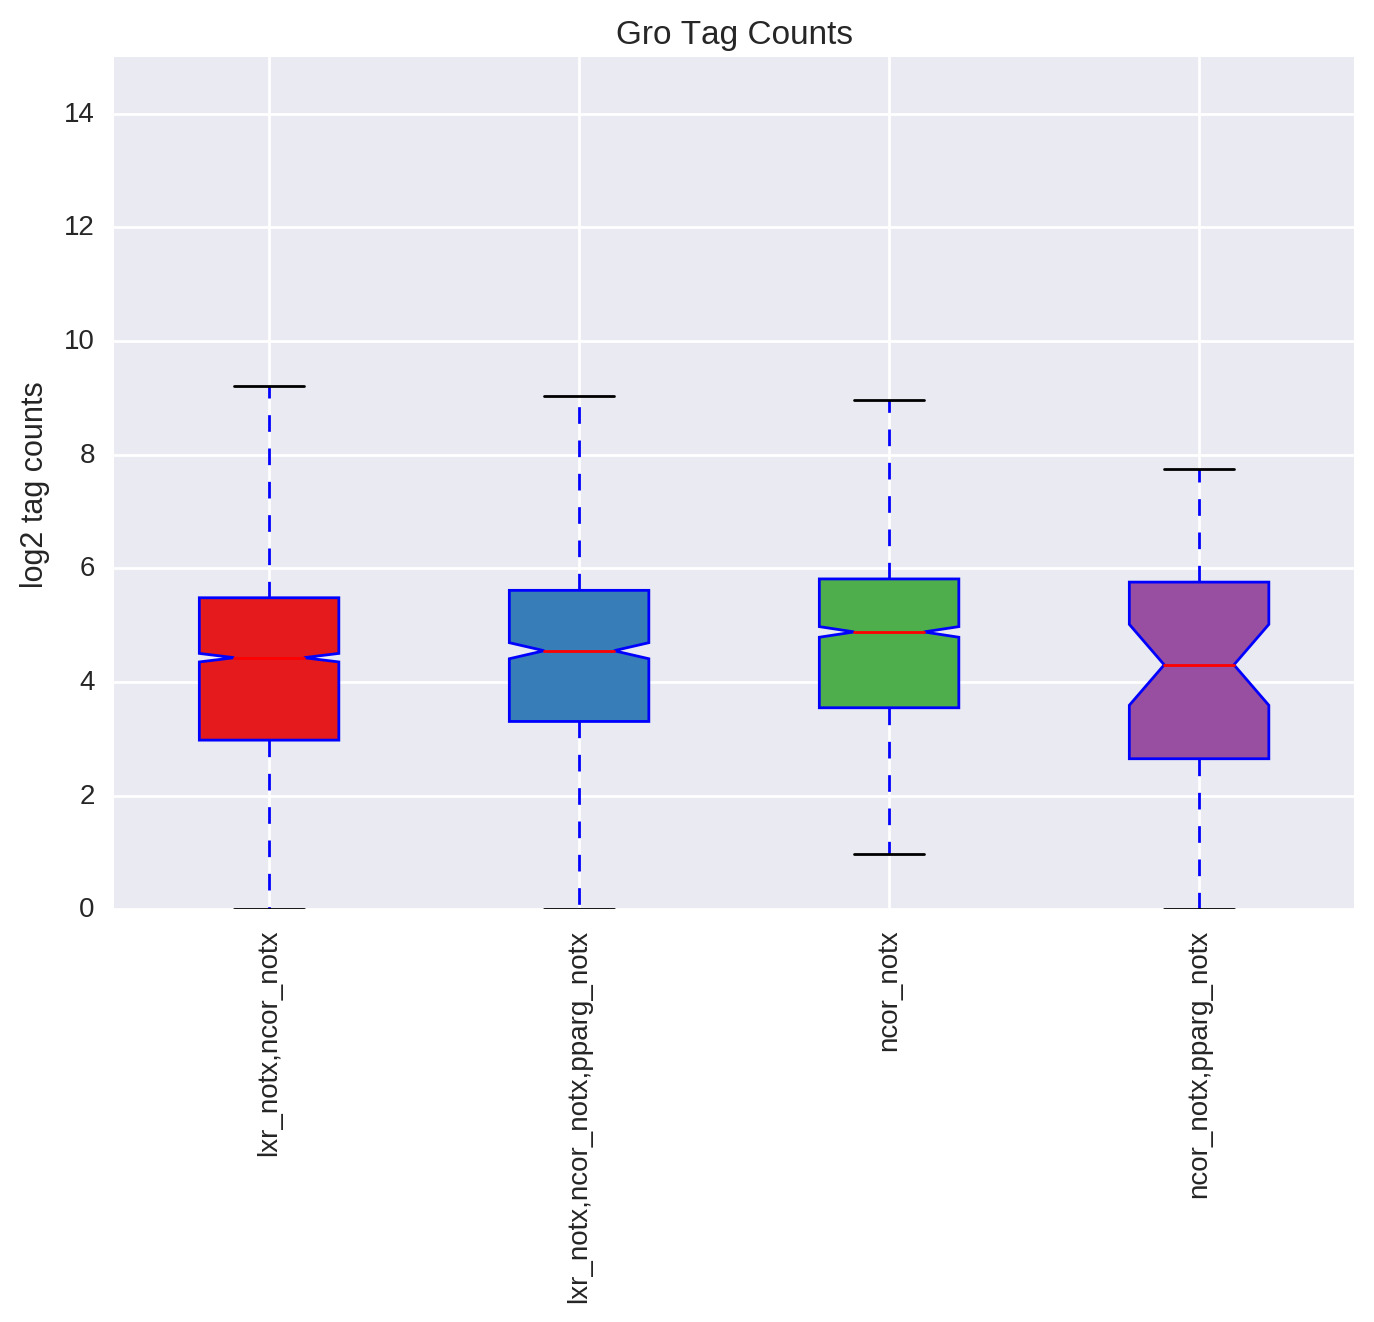

lxr_notx,ncor_notx | lxr_notx,ncor_notx,pparg_notx : 0.00423176271029
lxr_notx,ncor_notx | ncor_notx : 5.74107025016e-08
lxr_notx,ncor_notx | ncor_notx,pparg_notx : 0.910481978613
lxr_notx,ncor_notx,pparg_notx | ncor_notx : 0.246122670062
lxr_notx,ncor_notx,pparg_notx | ncor_notx,pparg_notx : 0.336653965745
ncor_notx | ncor_notx,pparg_notx : 0.201830017619


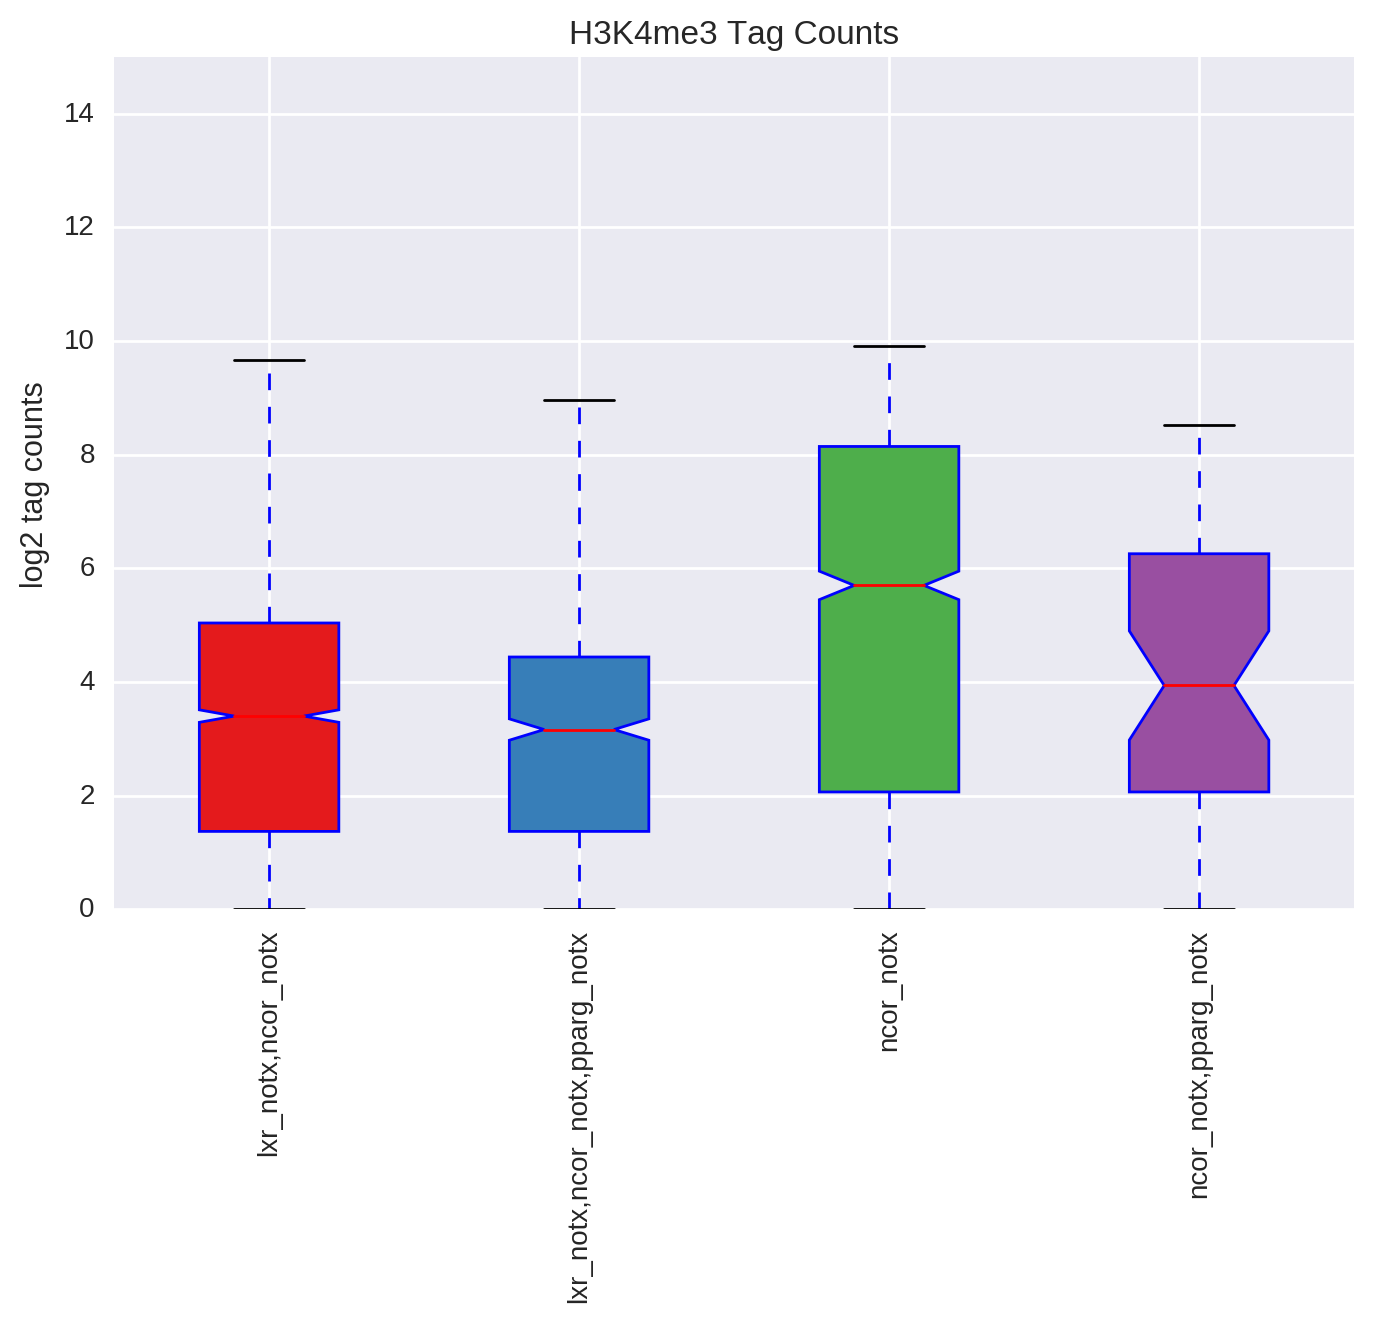

lxr_notx,ncor_notx | lxr_notx,ncor_notx,pparg_notx : 0.000143579813495
lxr_notx,ncor_notx | ncor_notx : 2.83982886836e-70
lxr_notx,ncor_notx | ncor_notx,pparg_notx : 0.151068991765
lxr_notx,ncor_notx,pparg_notx | ncor_notx : 2.64761860345e-46
lxr_notx,ncor_notx,pparg_notx | ncor_notx,pparg_notx : 0.00565595844413
ncor_notx | ncor_notx,pparg_notx : 0.0216973161756


In [257]:
# factor_groups = set(summary_frame['Factors'].values)
numColors = 16
colorDict = dict(zip(range(numColors),sns.color_palette("Set1") + sns.color_palette("Set2") + sns.color_palette("colorblind")))

summary_frame['tempFactors'] = [','.join([y for y in x.split(',') if ('ncor' in y or 'lxr' in y or 'pparg' in y) and 'notx' in y]) 
                                for x in summary_frame['Factors'].values]

factor_groups =['lxr_notx,ncor_notx',
 'lxr_notx,ncor_notx,pparg_notx',
 'ncor_notx',
 'ncor_notx,pparg_notx'
 ]

colorValues = list(colorDict.values())
colors = []

for i in range(len(factor_groups)):
    colors.append(colorValues[i])

# for Pol II
counts = []
labels = []

for cluster in factor_groups:
    cluster_name = cluster
    ids = summary_frame[summary_frame['tempFactors'] == cluster_name].index.values
    notx_values = summary_frame.ix[ids,'PolII-notx'].values
    notx_values = np.log2(notx_values + 1)


    if np.sum(notx_values) > 0 or np.sum(kla_values) > 0 :
        labels.append(cluster_name)
        counts.append(notx_values)
box = plt.boxplot(counts, notch=True, patch_artist=True);

for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

plt.xticks(range(1,len(labels)+1), labels, rotation =90);
plt.ylim([0,15])
plt.ylabel('log2 tag counts')
plt.title('PolII Tag Counts')
plt.show()

for i in range(len(counts) -1):
    for j in range(i+1, len(counts)):
        stat, p = scipy.stats.ttest_ind(counts[i],counts[j])
        print(labels[i], '|', labels[j], ':', p)

# for h3k27ac
counts = []
labels = []

for cluster in factor_groups:
    cluster_name = cluster
    ids = summary_frame[summary_frame['tempFactors'] == cluster_name].index.values
    notx_values = summary_frame.ix[ids,'H3K27Ac-notx'].values
    notx_values = np.log2(notx_values + 1)


    if np.sum(notx_values) > 0 or np.sum(kla_values) > 0 :
        labels.append(cluster_name)
        counts.append(notx_values)
box = plt.boxplot(counts, notch=True, patch_artist=True);

for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

plt.xticks(range(1,len(labels)+1), labels, rotation =90);
plt.ylim([0,15])
plt.ylabel('log2 tag counts')
plt.title('H3K27Ac Tag Counts')
plt.show()
for i in range(len(counts) -1):
    for j in range(i+1, len(counts)):
        stat, p = scipy.stats.ttest_ind(counts[i],counts[j])
        print(labels[i], '|', labels[j], ':', p)
        
# for Gro
counts = []
labels = []

for cluster in factor_groups:
    cluster_name = cluster
    ids = summary_frame[summary_frame['tempFactors'] == cluster_name].index.values
    notx_values = summary_frame.ix[ids,'Gro-notx'].values
    notx_values = np.log2(notx_values + 1)


    if np.sum(notx_values) > 0 or np.sum(kla_values) > 0 :
        labels.append(cluster_name)
        counts.append(notx_values)
box = plt.boxplot(counts, notch=True, patch_artist=True);

for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

plt.xticks(range(1,len(labels)+1), labels, rotation =90);
plt.ylim([0,15])
plt.ylabel('log2 tag counts')
plt.title('Gro Tag Counts')
plt.show()
for i in range(len(counts) -1):
    for j in range(i+1, len(counts)):
        stat, p = scipy.stats.ttest_ind(counts[i],counts[j])
        print(labels[i], '|', labels[j], ':', p)


# for H3K4me3
counts = []
labels = []

for cluster in factor_groups:
    cluster_name = cluster
    ids = summary_frame[summary_frame['tempFactors'] == cluster_name].index.values
    notx_values = summary_frame.ix[ids,'H3K4me3-notx'].values
    notx_values = np.log2(notx_values + 1)


    if np.sum(notx_values) > 0 or np.sum(kla_values) > 0 :
        labels.append(cluster_name)
        counts.append(notx_values)
box = plt.boxplot(counts, notch=True, patch_artist=True);

for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

plt.xticks(range(1,len(labels)+1), labels, rotation =90);
plt.ylim([0,15])
plt.ylabel('log2 tag counts')
plt.title('H3K4me3 Tag Counts')
plt.show()
for i in range(len(counts) -1):
    for j in range(i+1, len(counts)):
        stat, p = scipy.stats.ttest_ind(counts[i],counts[j])
        print(labels[i], '|', labels[j], ':', p)
del summary_frame['tempFactors']

## GPS2 Stuff

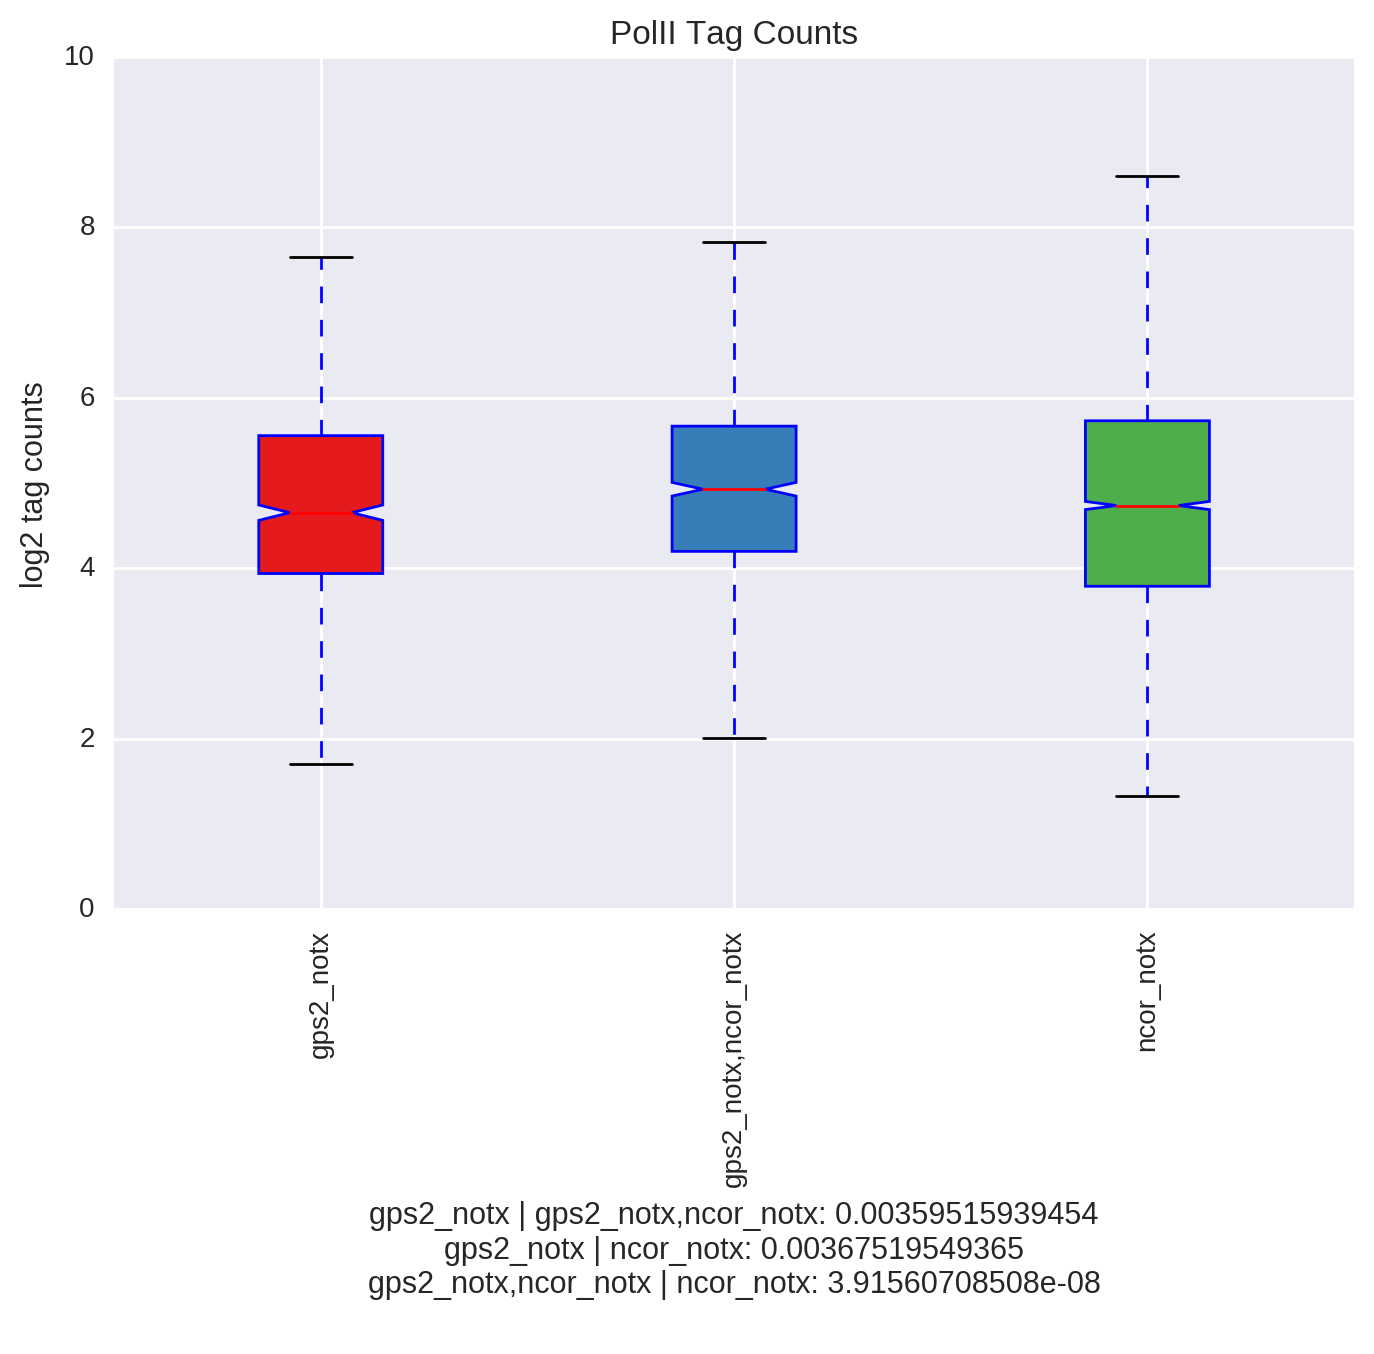

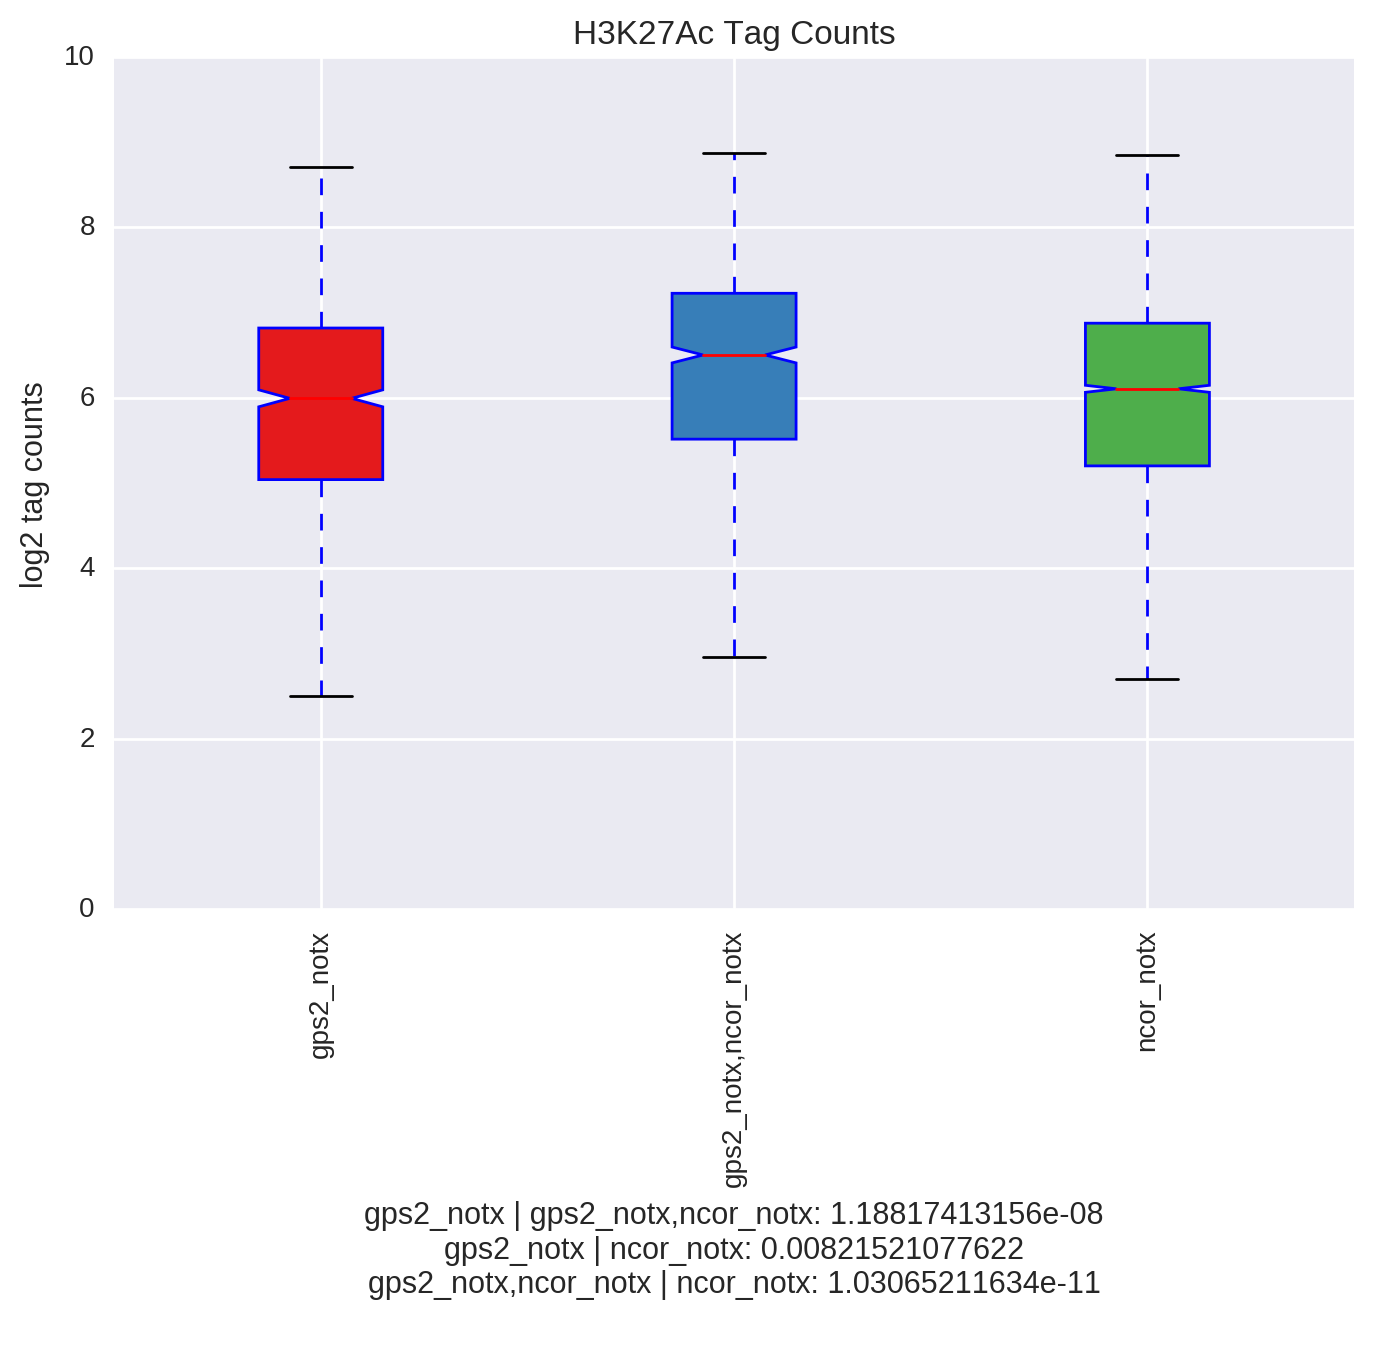

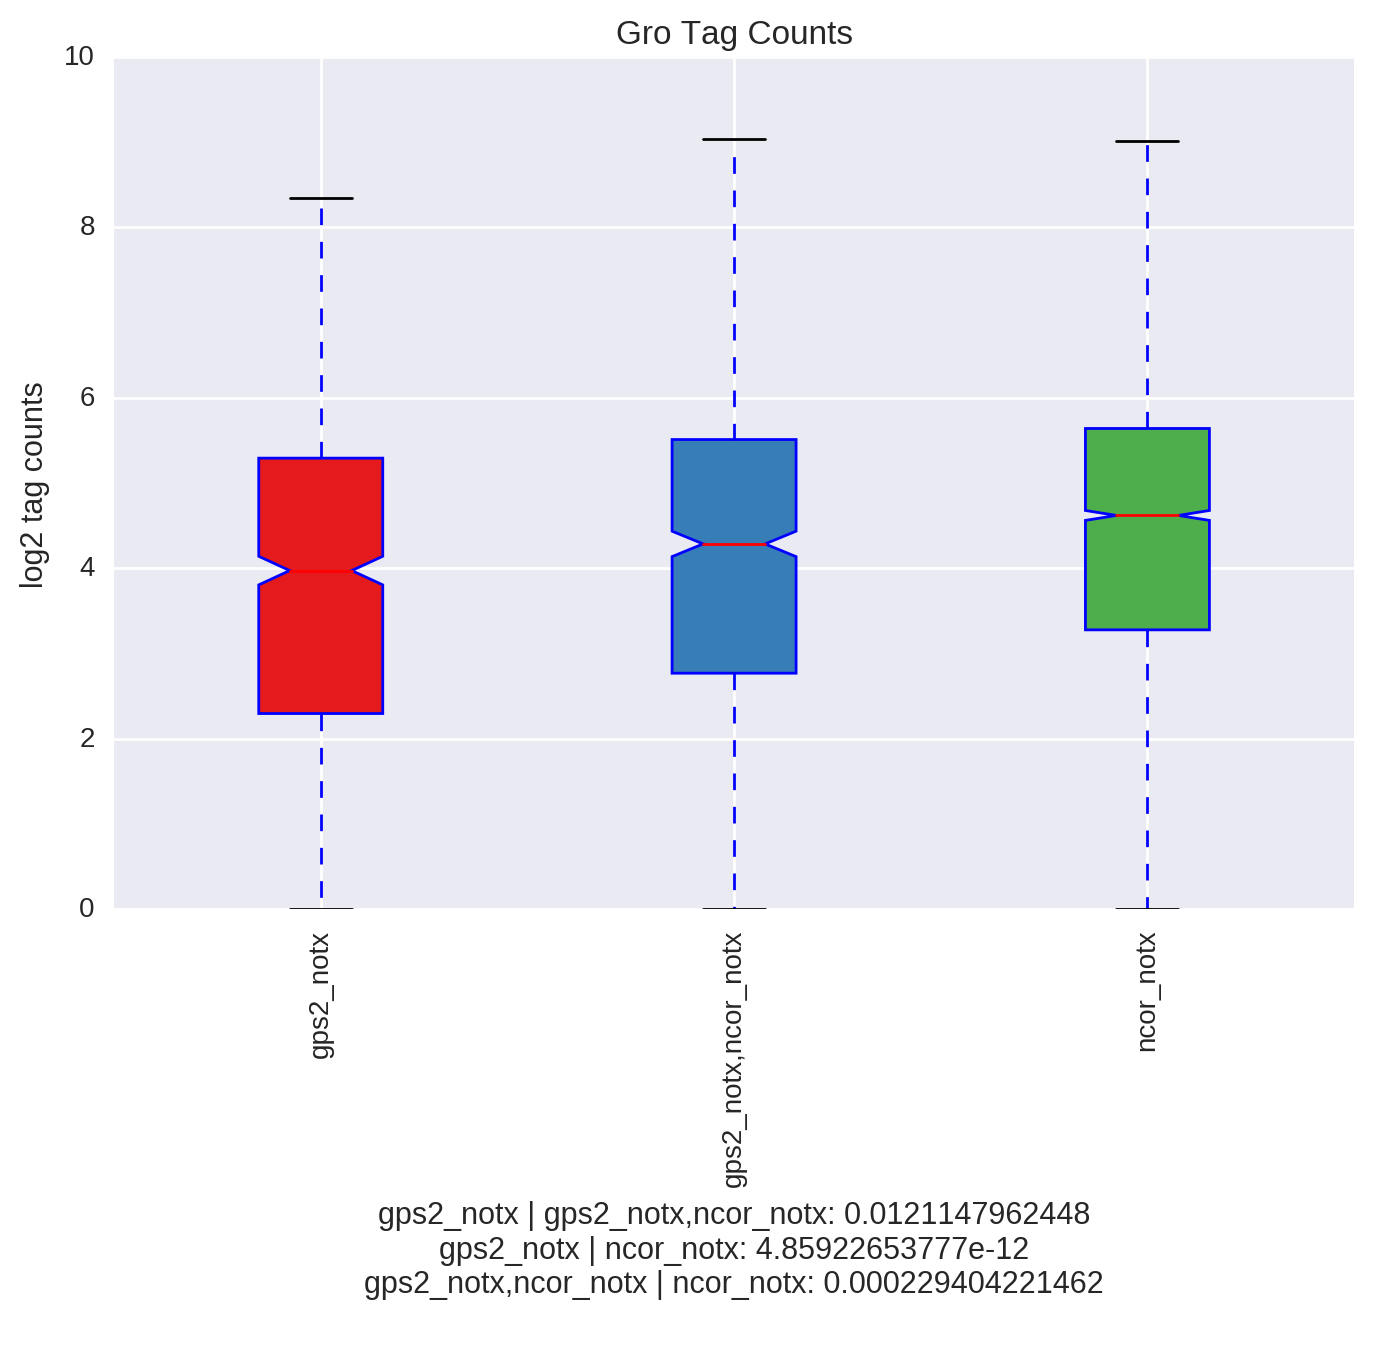

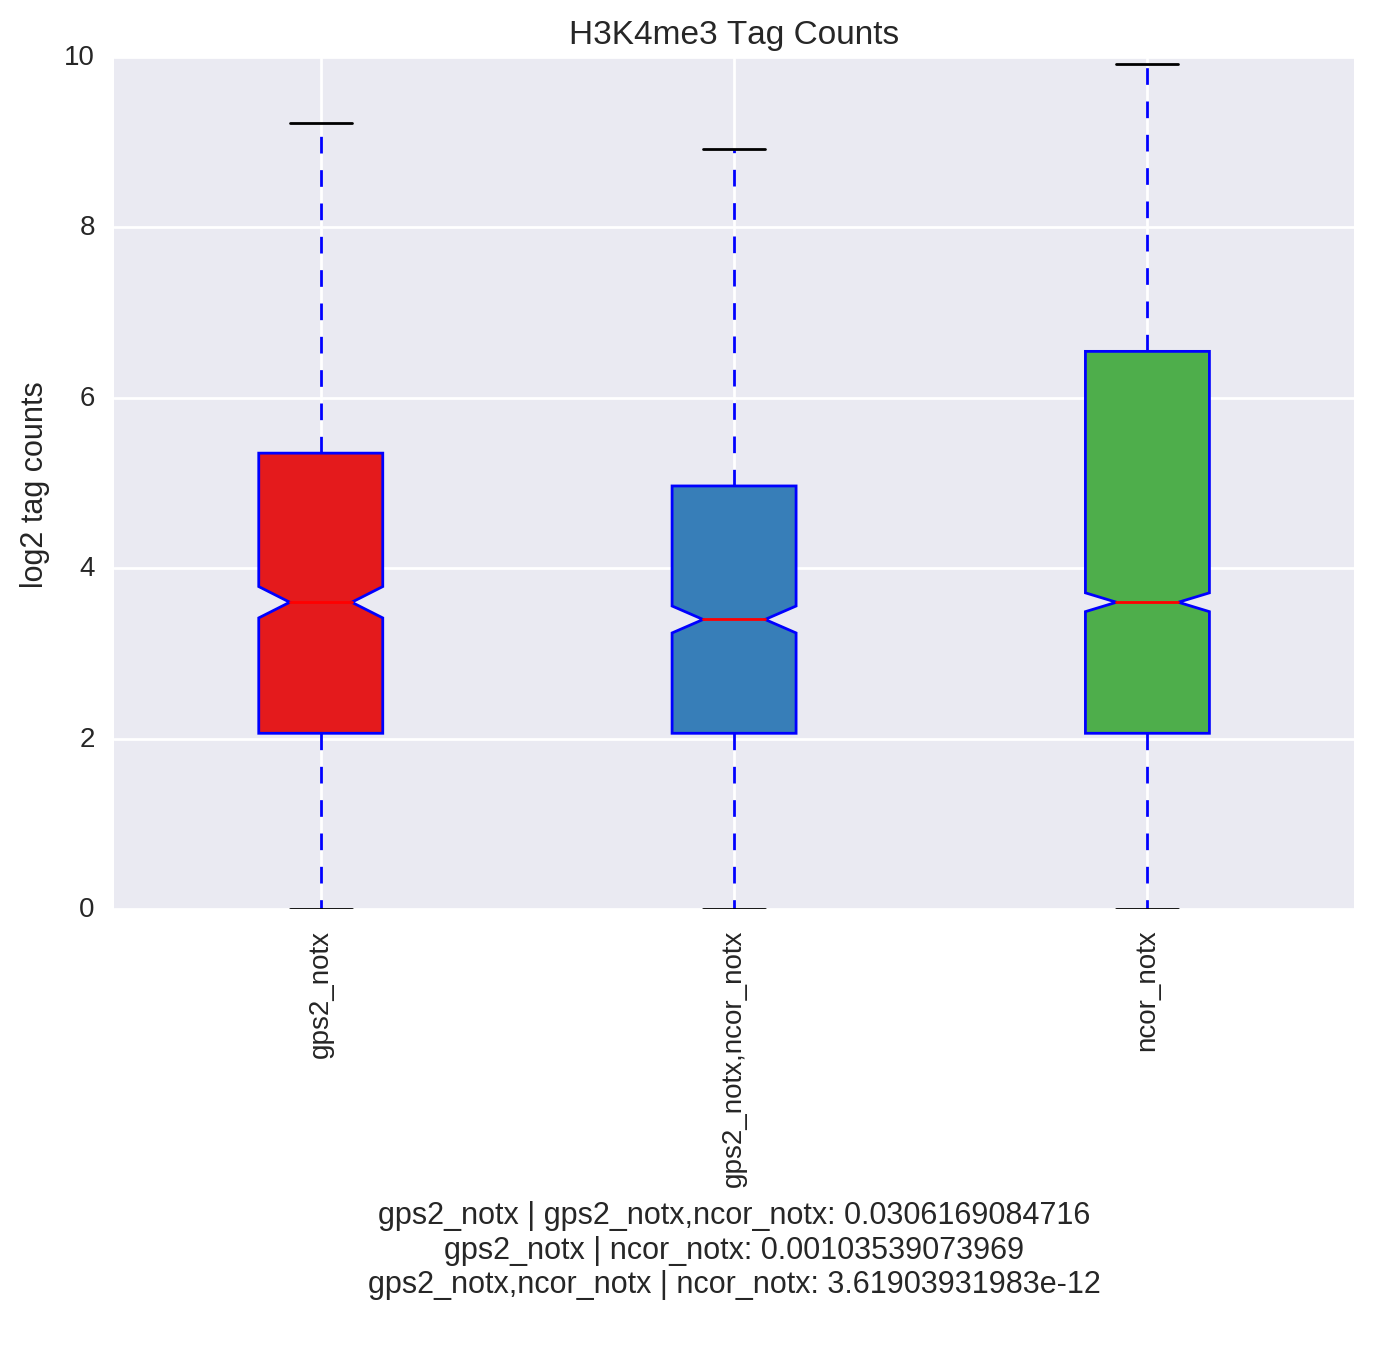

In [279]:
# factor_groups = set(summary_frame['Factors'].values)
numColors = 16
colorDict = dict(zip(range(numColors),sns.color_palette("Set1") + sns.color_palette("Set2") + sns.color_palette("colorblind")))

summary_frame['tempFactors'] = [','.join([y for y in x.split(',') if ('ncor' in y or 'gps2' in y ) and 'notx' in y]) 
                                for x in summary_frame['Factors'].values]

factor_groups =['gps2_notx', 'gps2_notx,ncor_notx', 'ncor_notx']

colorValues = list(colorDict.values())
colors = []

for i in range(len(factor_groups)):
    colors.append(colorValues[i])

# for Pol II
counts = []
labels = []

for cluster in factor_groups:
    cluster_name = cluster
    ids = summary_frame[summary_frame['tempFactors'] == cluster_name].index.values
    notx_values = summary_frame.ix[ids,'PolII-notx'].values
    notx_values = np.log2(notx_values + 1)


    if np.sum(notx_values) > 0 or np.sum(kla_values) > 0 :
        labels.append(cluster_name)
        counts.append(notx_values)
box = plt.boxplot(counts, notch=True, patch_artist=True);

for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

plt.xticks(range(1,len(labels)+1), labels, rotation =90);
plt.ylim([0,10])

plt.ylabel('log2 tag counts')
plt.title('PolII Tag Counts')
xlabel=''
for i in range(len(counts) -1):
    for j in range(i+1, len(counts)):
        stat, p = scipy.stats.ks_2samp(counts[i],counts[j])
        xlabel= xlabel +labels[i]+ ' | ' + labels[j]+ ': ' + str(p) + '\n'
plt.xlabel(xlabel)
plt.show()

# for h3k27ac
counts = []
labels = []

for cluster in factor_groups:
    cluster_name = cluster
    ids = summary_frame[summary_frame['tempFactors'] == cluster_name].index.values
    notx_values = summary_frame.ix[ids,'H3K27Ac-notx'].values
    notx_values = np.log2(notx_values + 1)


    if np.sum(notx_values) > 0 or np.sum(kla_values) > 0 :
        labels.append(cluster_name)
        counts.append(notx_values)
box = plt.boxplot(counts, notch=True, patch_artist=True);

for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

plt.xticks(range(1,len(labels)+1), labels, rotation =90);
plt.ylim([0,10])

plt.ylabel('log2 tag counts')
plt.title('H3K27Ac Tag Counts')
xlabel=''
for i in range(len(counts) -1):
    for j in range(i+1, len(counts)):
        stat, p = scipy.stats.ks_2samp(counts[i],counts[j])
        xlabel= xlabel +labels[i]+ ' | ' + labels[j]+ ': ' + str(p) + '\n'
plt.xlabel(xlabel)
plt.show()
        
# for Gro
counts = []
labels = []

for cluster in factor_groups:
    cluster_name = cluster
    ids = summary_frame[summary_frame['tempFactors'] == cluster_name].index.values
    notx_values = summary_frame.ix[ids,'Gro-notx'].values
    notx_values = np.log2(notx_values + 1)


    if np.sum(notx_values) > 0 or np.sum(kla_values) > 0 :
        labels.append(cluster_name)
        counts.append(notx_values)
box = plt.boxplot(counts, notch=True, patch_artist=True);

for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

plt.xticks(range(1,len(labels)+1), labels, rotation =90);
plt.ylim([0,10])

plt.ylabel('log2 tag counts')
plt.title('Gro Tag Counts')
xlabel=''
for i in range(len(counts) -1):
    for j in range(i+1, len(counts)):
        stat, p = scipy.stats.ks_2samp(counts[i],counts[j])
        xlabel= xlabel +labels[i]+ ' | ' + labels[j]+ ': ' + str(p) + '\n'

    plt.xlabel(xlabel)
plt.show()

# for H3K4me3
counts = []
labels = []

for cluster in factor_groups:
    cluster_name = cluster
    ids = summary_frame[summary_frame['tempFactors'] == cluster_name].index.values
    notx_values = summary_frame.ix[ids,'H3K4me3-notx'].values
    notx_values = np.log2(notx_values + 1)


    if np.sum(notx_values) > 0 or np.sum(kla_values) > 0 :
        labels.append(cluster_name)
        counts.append(notx_values)
box = plt.boxplot(counts, notch=True, patch_artist=True);

for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

plt.xticks(range(1,len(labels)+1), labels, rotation =90);
plt.ylim([0,10])
plt.ylabel('log2 tag counts')
plt.title('H3K4me3 Tag Counts')
xlabel=''
for i in range(len(counts) -1):
    for j in range(i+1, len(counts)):
        stat, p = scipy.stats.ks_2samp(counts[i],counts[j])
        xlabel= xlabel +labels[i]+ ' | ' + labels[j]+ ': ' + str(p) + '\n'
plt.xlabel(xlabel)
plt.show()

del summary_frame['tempFactors']

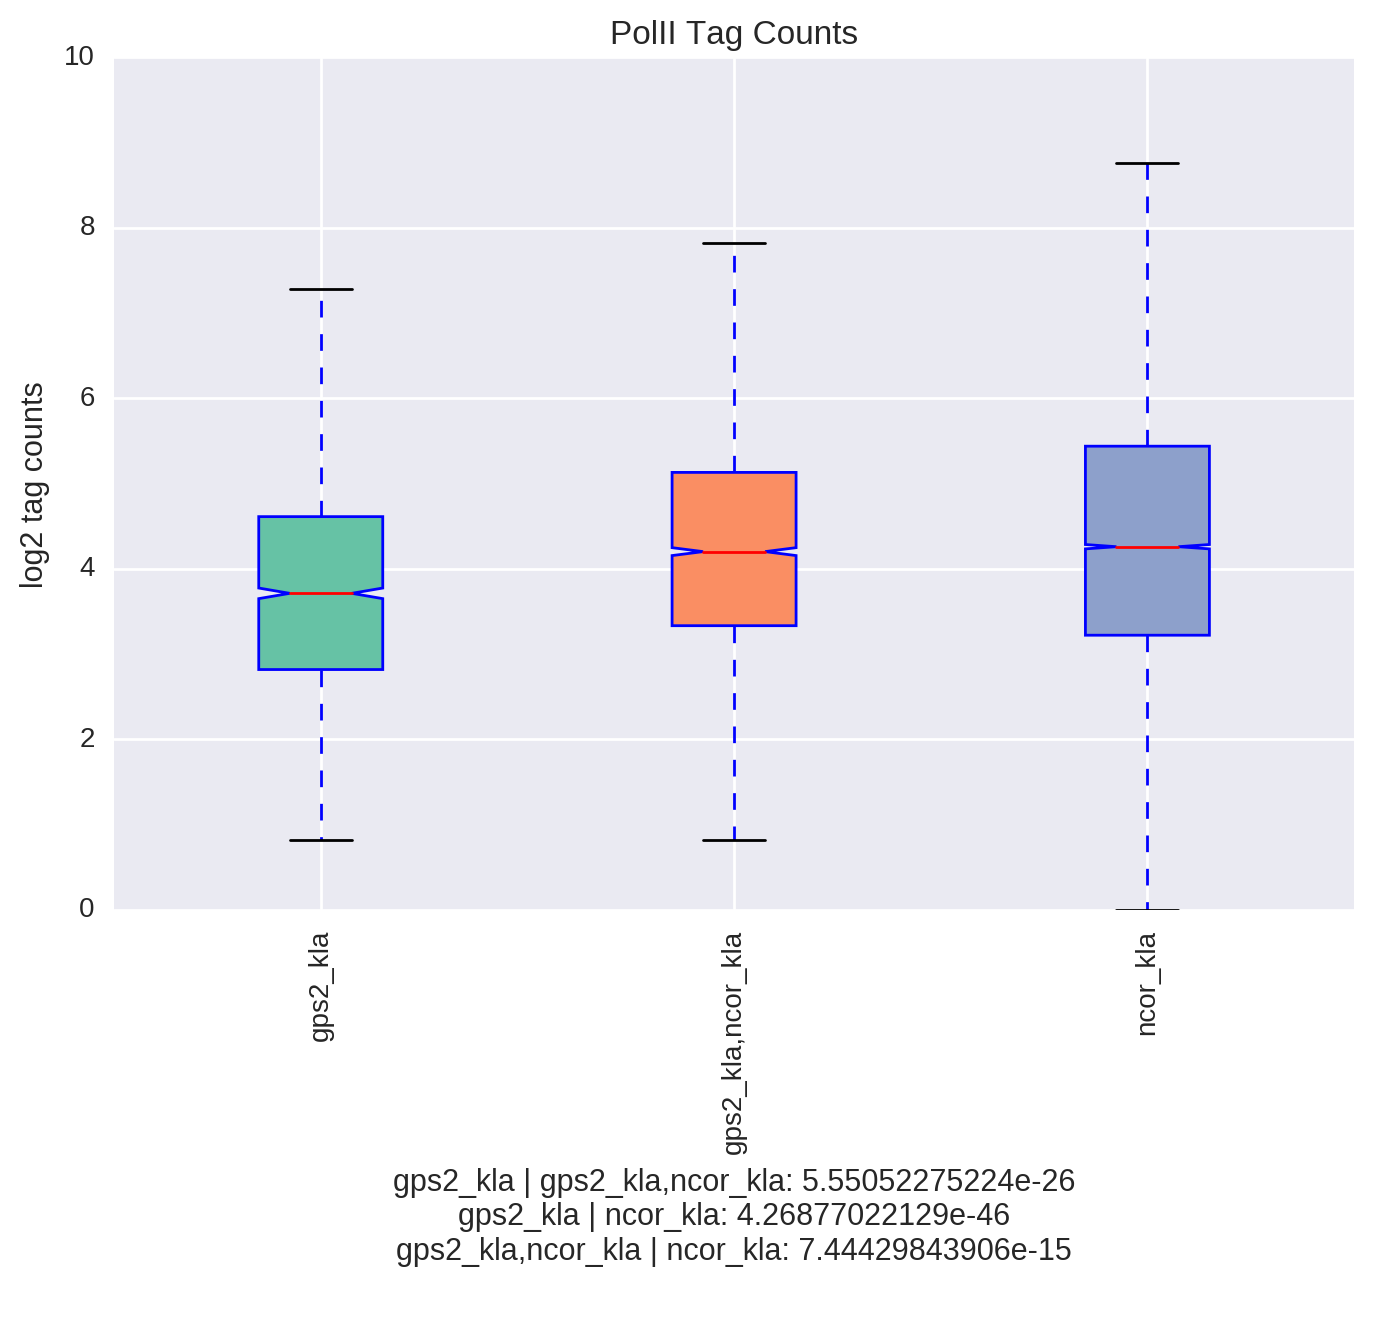

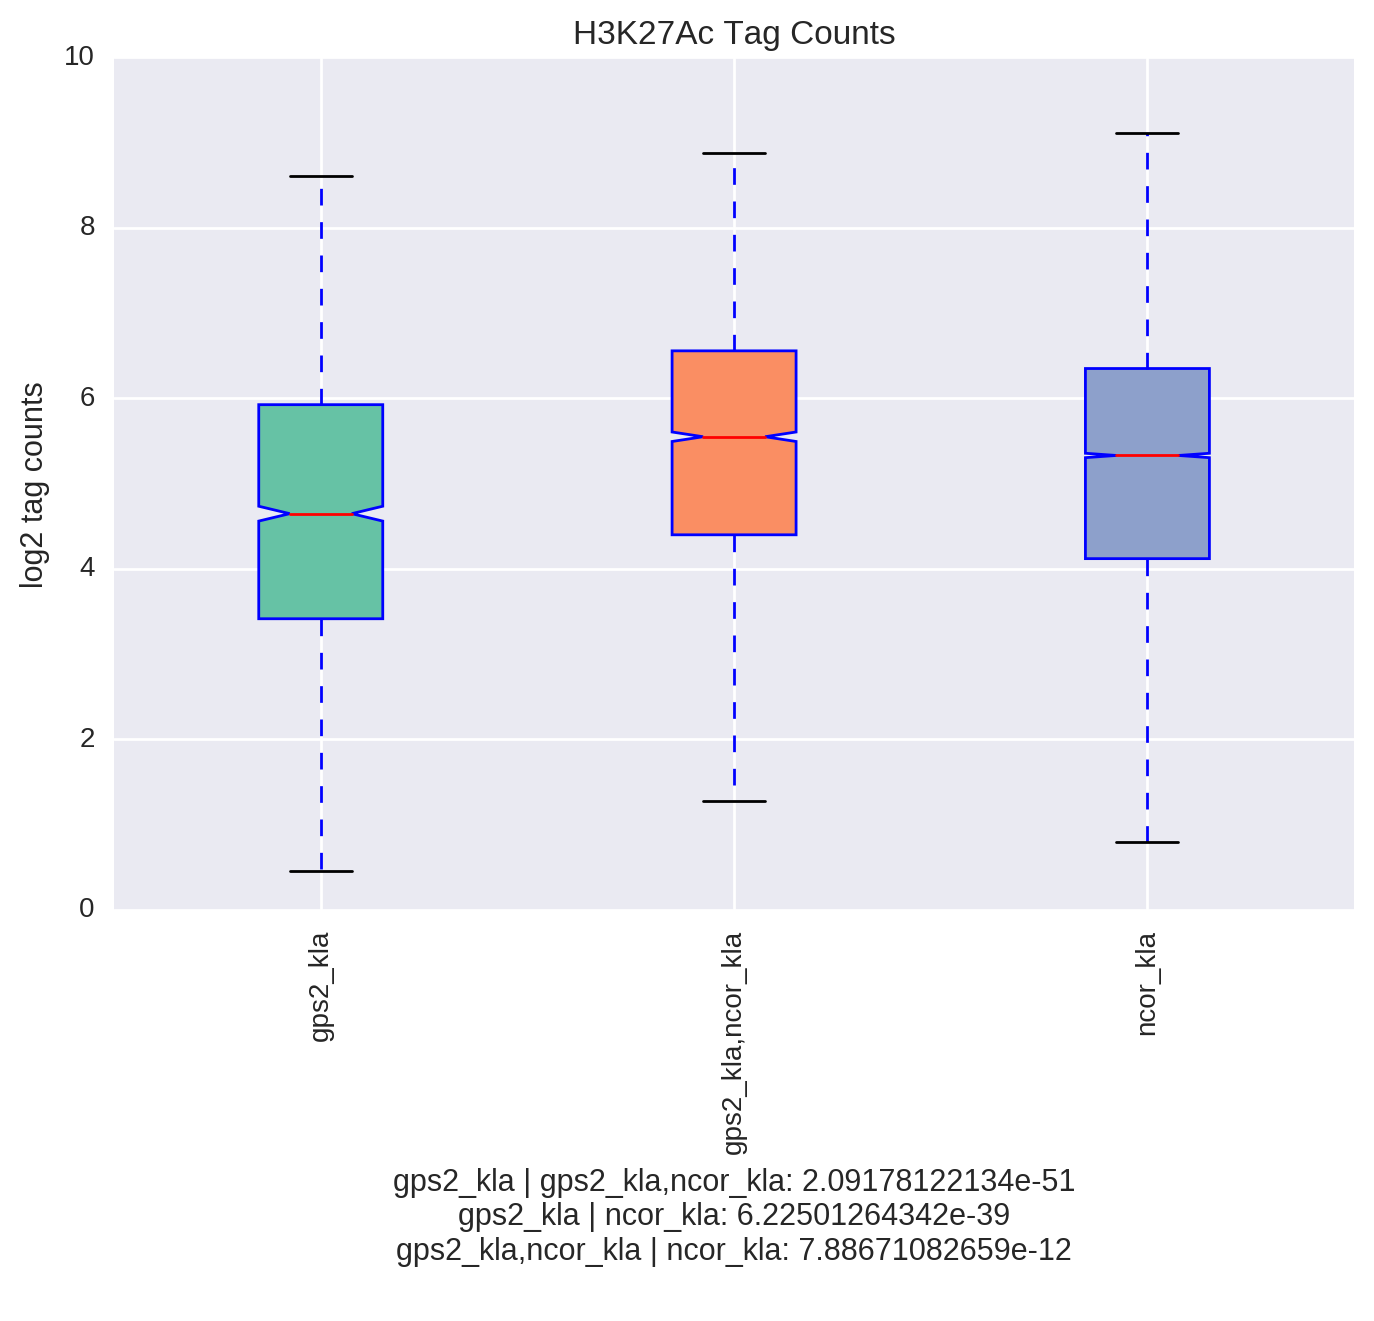

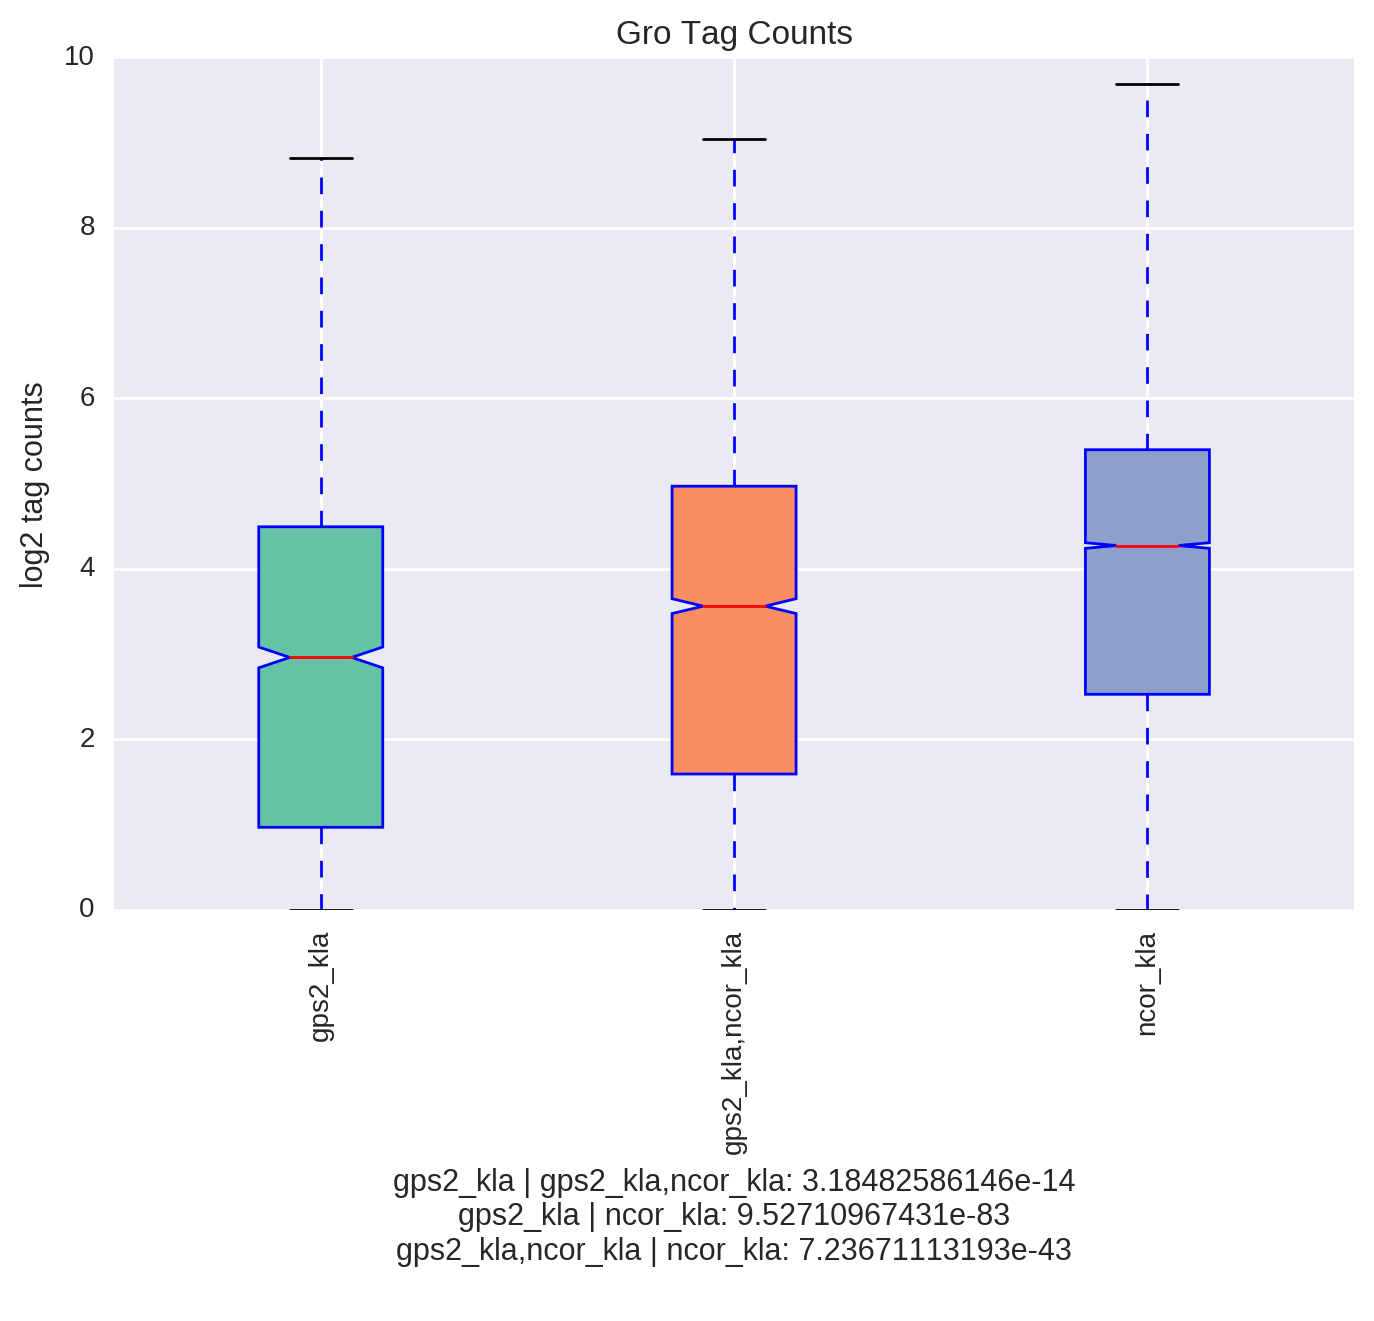

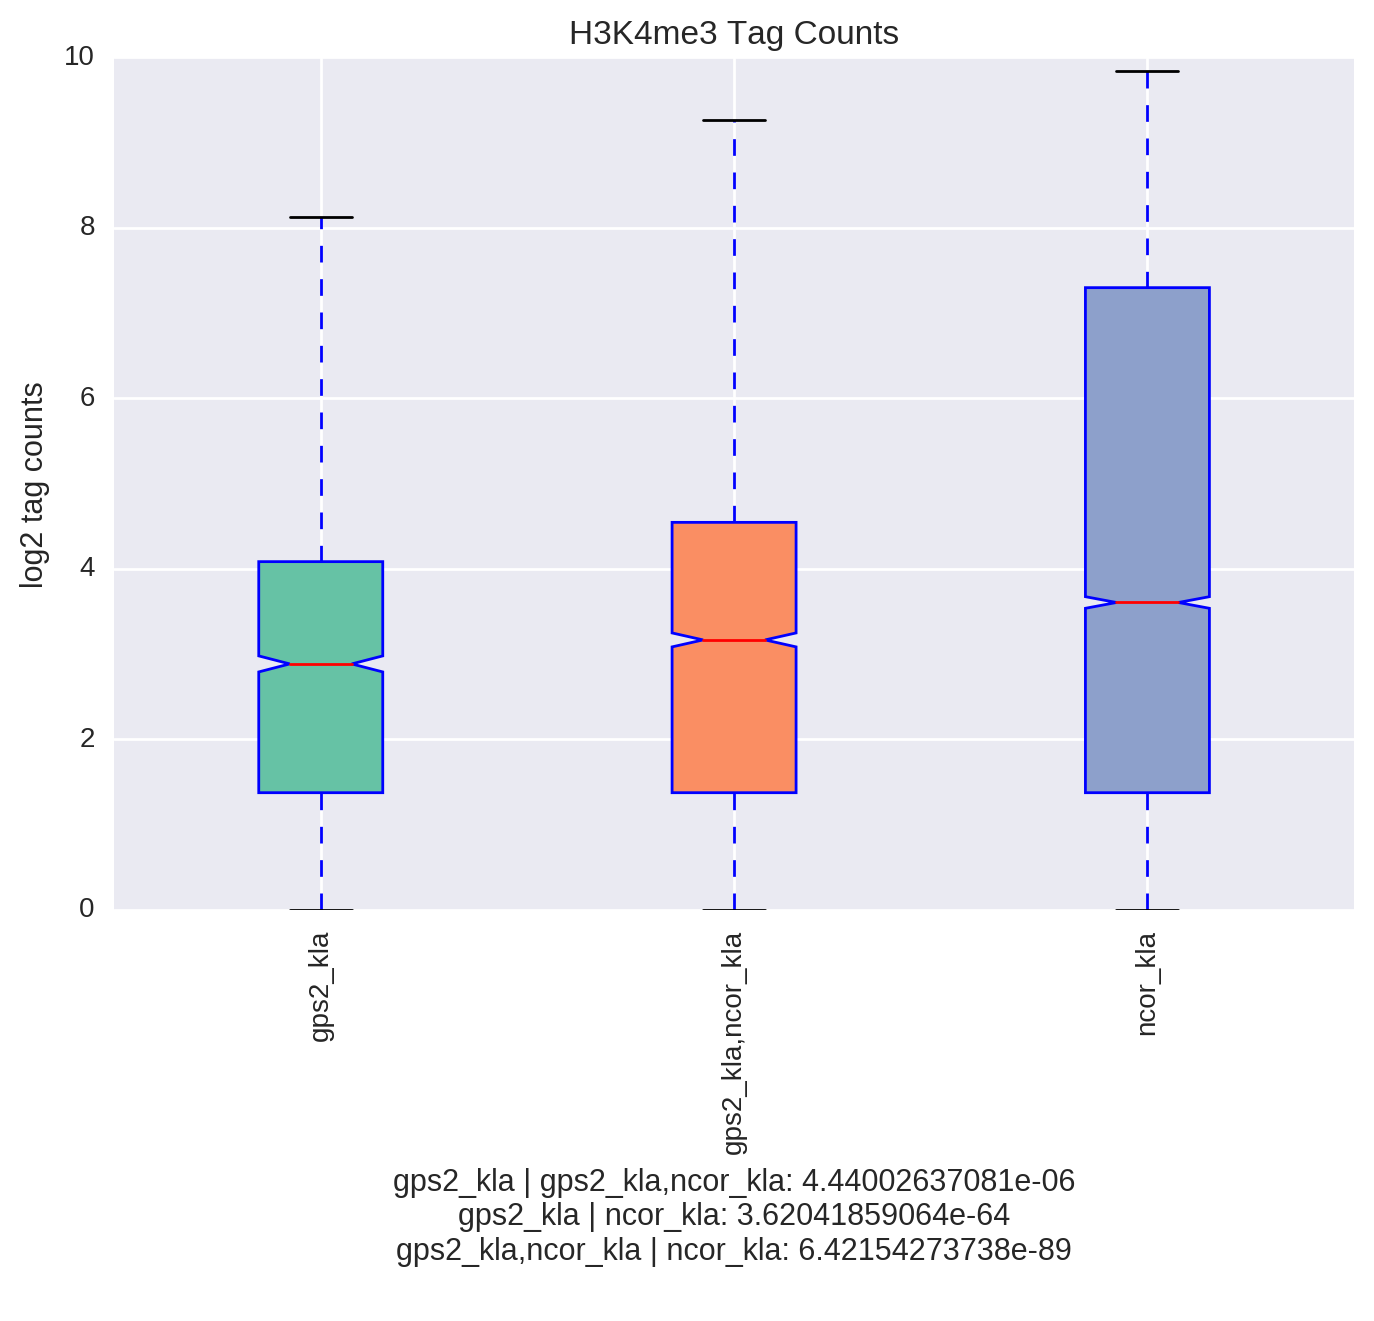

In [278]:
# factor_groups = set(summary_frame['Factors'].values)
numColors = 16
colorDict = dict(zip(range(numColors),sns.color_palette("Set2") + sns.color_palette("Set1") + sns.color_palette("colorblind")))

summary_frame['tempFactors'] = [','.join([y for y in x.split(',') if ('ncor' in y or 'gps2' in y ) and 'kla' in y]) 
                                for x in summary_frame['Factors'].values]

factor_groups =['gps2_kla', 'gps2_kla,ncor_kla', 'ncor_kla']

colorValues = list(colorDict.values())
colors = []

for i in range(len(factor_groups)):
    colors.append(colorValues[i])

# for Pol II
counts = []
labels = []

for cluster in factor_groups:
    cluster_name = cluster
    ids = summary_frame[summary_frame['tempFactors'] == cluster_name].index.values
    notx_values = summary_frame.ix[ids,'PolII-notx'].values
    notx_values = np.log2(notx_values + 1)


    if np.sum(notx_values) > 0 or np.sum(kla_values) > 0 :
        labels.append(cluster_name)
        counts.append(notx_values)
box = plt.boxplot(counts, notch=True, patch_artist=True);

for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

plt.xticks(range(1,len(labels)+1), labels, rotation =90);
plt.ylim([0,10])

plt.ylabel('log2 tag counts')
plt.title('PolII Tag Counts')
xlabel=''
for i in range(len(counts) -1):
    for j in range(i+1, len(counts)):
        stat, p = scipy.stats.ks_2samp(counts[i],counts[j])
        xlabel= xlabel +labels[i]+ ' | ' + labels[j]+ ': ' + str(p) + '\n'
plt.xlabel(xlabel)
plt.show()

# for h3k27ac
counts = []
labels = []

for cluster in factor_groups:
    cluster_name = cluster
    ids = summary_frame[summary_frame['tempFactors'] == cluster_name].index.values
    notx_values = summary_frame.ix[ids,'H3K27Ac-notx'].values
    notx_values = np.log2(notx_values + 1)


    if np.sum(notx_values) > 0 or np.sum(kla_values) > 0 :
        labels.append(cluster_name)
        counts.append(notx_values)
box = plt.boxplot(counts, notch=True, patch_artist=True);

for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

plt.xticks(range(1,len(labels)+1), labels, rotation =90);
plt.ylim([0,10])

plt.ylabel('log2 tag counts')
plt.title('H3K27Ac Tag Counts')
xlabel=''
for i in range(len(counts) -1):
    for j in range(i+1, len(counts)):
        stat, p = scipy.stats.ks_2samp(counts[i],counts[j])
        xlabel= xlabel +labels[i]+ ' | ' + labels[j]+ ': ' + str(p) + '\n'
plt.xlabel(xlabel)
plt.show()
        
# for Gro
counts = []
labels = []

for cluster in factor_groups:
    cluster_name = cluster
    ids = summary_frame[summary_frame['tempFactors'] == cluster_name].index.values
    notx_values = summary_frame.ix[ids,'Gro-notx'].values
    notx_values = np.log2(notx_values + 1)


    if np.sum(notx_values) > 0 or np.sum(kla_values) > 0 :
        labels.append(cluster_name)
        counts.append(notx_values)
box = plt.boxplot(counts, notch=True, patch_artist=True);

for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

plt.xticks(range(1,len(labels)+1), labels, rotation =90);
plt.ylim([0,10])

plt.ylabel('log2 tag counts')
plt.title('Gro Tag Counts')
xlabel=''
for i in range(len(counts) -1):
    for j in range(i+1, len(counts)):
        stat, p = scipy.stats.ks_2samp(counts[i],counts[j])
        xlabel= xlabel +labels[i]+ ' | ' + labels[j]+ ': ' + str(p) + '\n'

    plt.xlabel(xlabel)
plt.show()

# for H3K4me3
counts = []
labels = []

for cluster in factor_groups:
    cluster_name = cluster
    ids = summary_frame[summary_frame['tempFactors'] == cluster_name].index.values
    notx_values = summary_frame.ix[ids,'H3K4me3-notx'].values
    notx_values = np.log2(notx_values + 1)


    if np.sum(notx_values) > 0 or np.sum(kla_values) > 0 :
        labels.append(cluster_name)
        counts.append(notx_values)
box = plt.boxplot(counts, notch=True, patch_artist=True);

for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

plt.xticks(range(1,len(labels)+1), labels, rotation =90);
plt.ylim([0,10])
plt.ylabel('log2 tag counts')
plt.title('H3K4me3 Tag Counts')
xlabel=''
for i in range(len(counts) -1):
    for j in range(i+1, len(counts)):
        stat, p = scipy.stats.ks_2samp(counts[i],counts[j])
        xlabel= xlabel +labels[i]+ ' | ' + labels[j]+ ': ' + str(p) + '\n'
plt.xlabel(xlabel)
plt.show()

del summary_frame['tempFactors']



In [265]:
set(summary_frame['tempFactors'].values)

{'', 'gps2_kla', 'gps2_kla,ncor_kla', 'ncor_kla'}